In [1]:
#%install_ext https://raw.github.com/cpcloud/ipython-autotime/master/autotime.py
%load_ext autotime
import osmnx as ox, geopandas as gpd, pandas as pd, networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString, Polygon, MultiPolygon
from IPython.display import Image
from descartes import PolygonPatch
from itertools import combinations, combinations_with_replacement
%matplotlib inline
ox.config(log_console=True, use_cache=True)
%config IPCompleter.greedy=True

import libpysal as lp

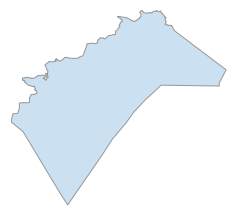

time: 139 ms


In [2]:
city = ox.gdf_from_place('Busan, South Korea')
#city = ox.project_gdf(city)
fig, ax = ox.plot_shape(city, figsize=(4,4))
ox.save_gdf_shapefile(city)

In [3]:
crs =  {'init': 'epsg:4326'}
city.crs = crs
city

bbox_east  bbox_north  bbox_south    bbox_west  \
0  129.4889527  35.3892236  34.7252504  128.7568072   

                                            geometry          place_name  
0  POLYGON ((128.7568072 35.0072555, 128.7962547 ...  Busan, South Korea

time: 18 ms


1642
data max index: 1641
number of NA prices: 0
average bedroom price 53.535857200893766
pointinpoly length: 1641
check contains: True
check if there are NAs: False


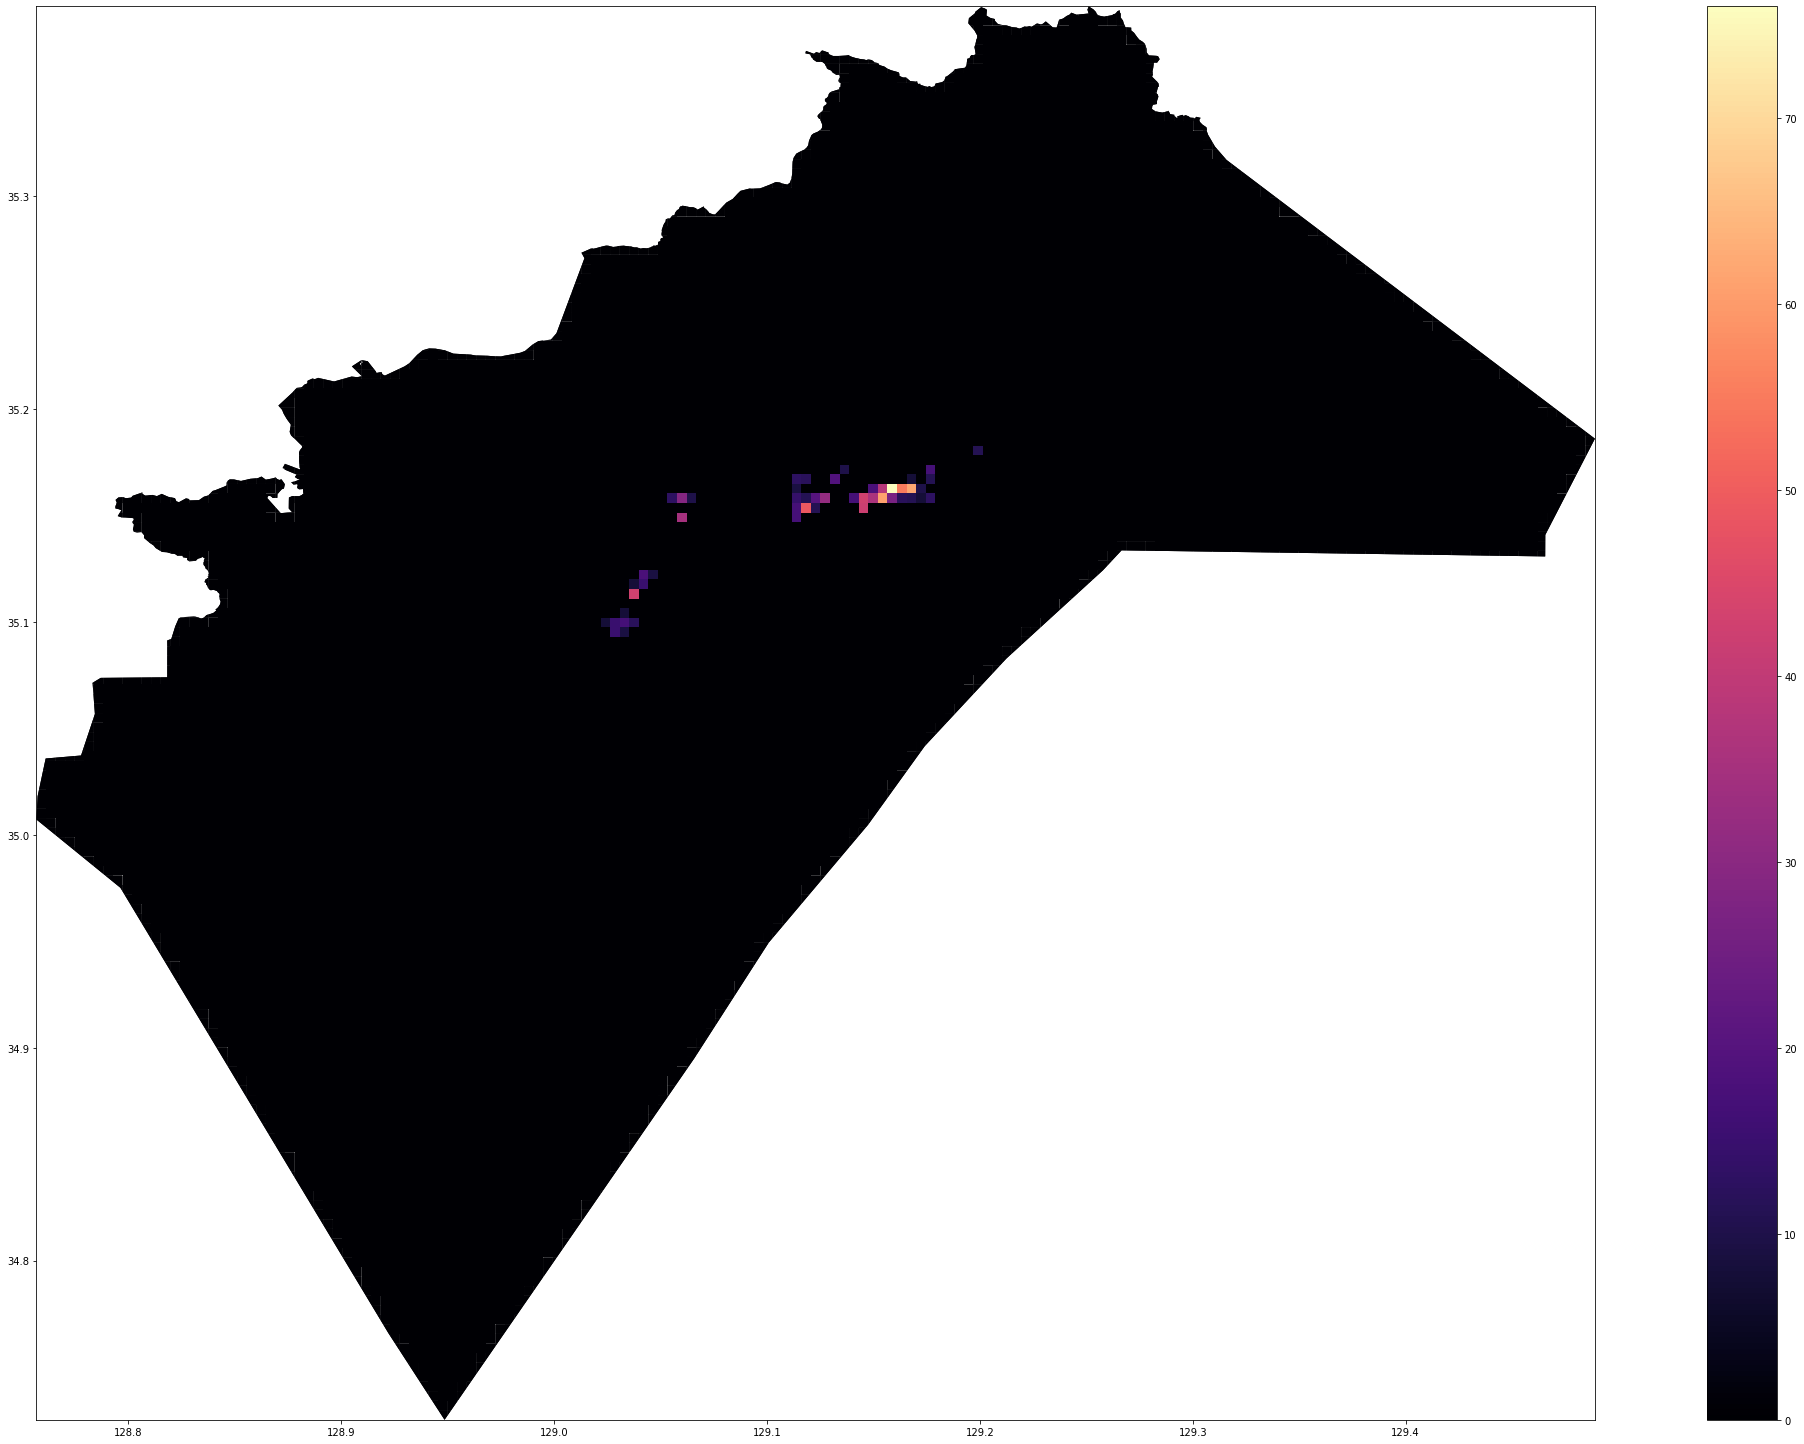

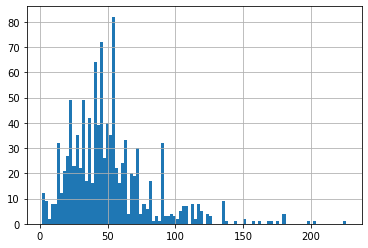

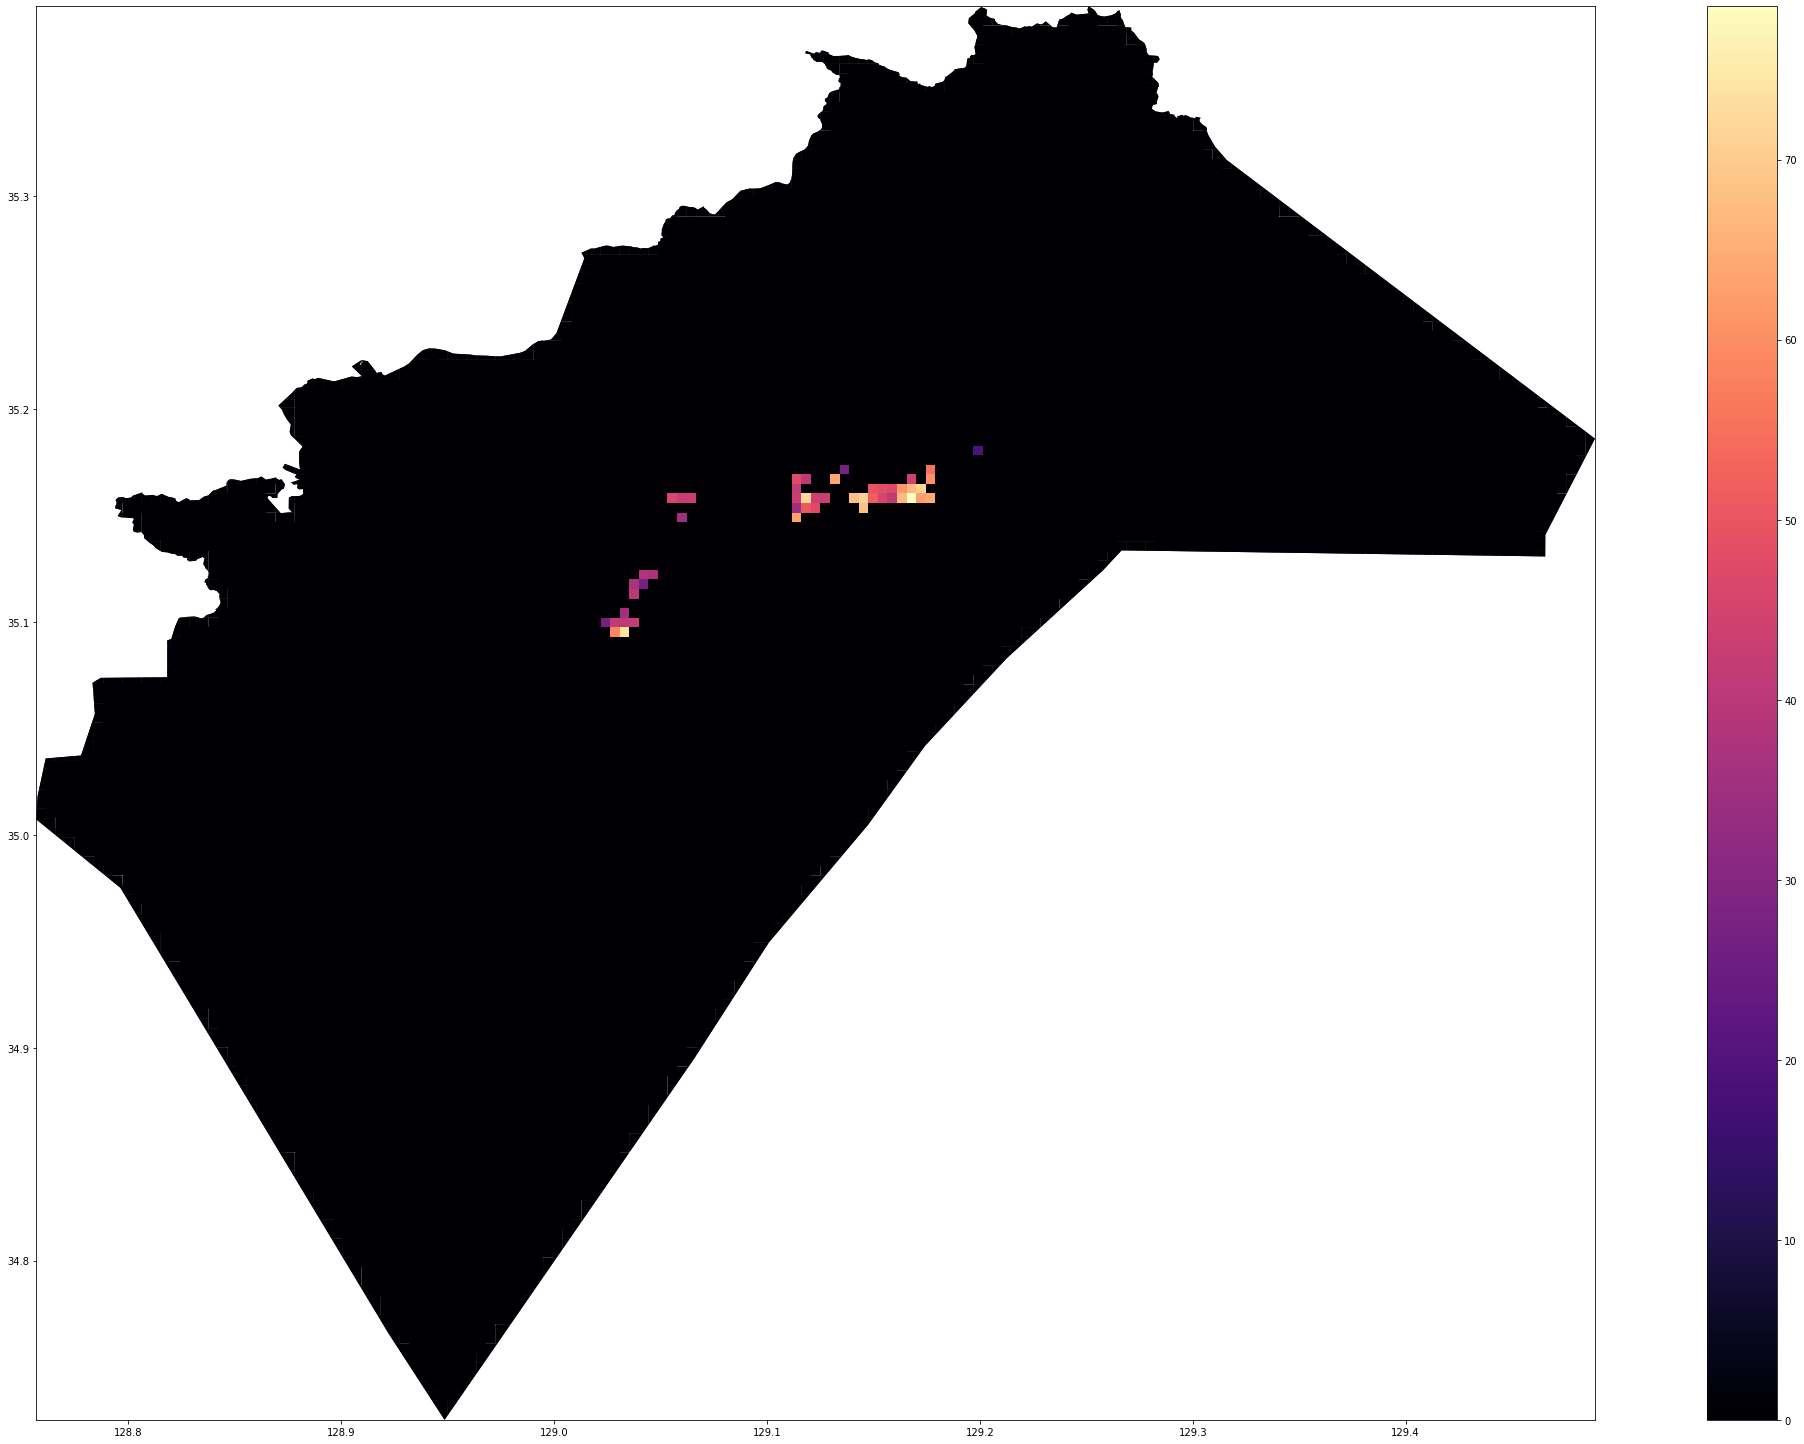

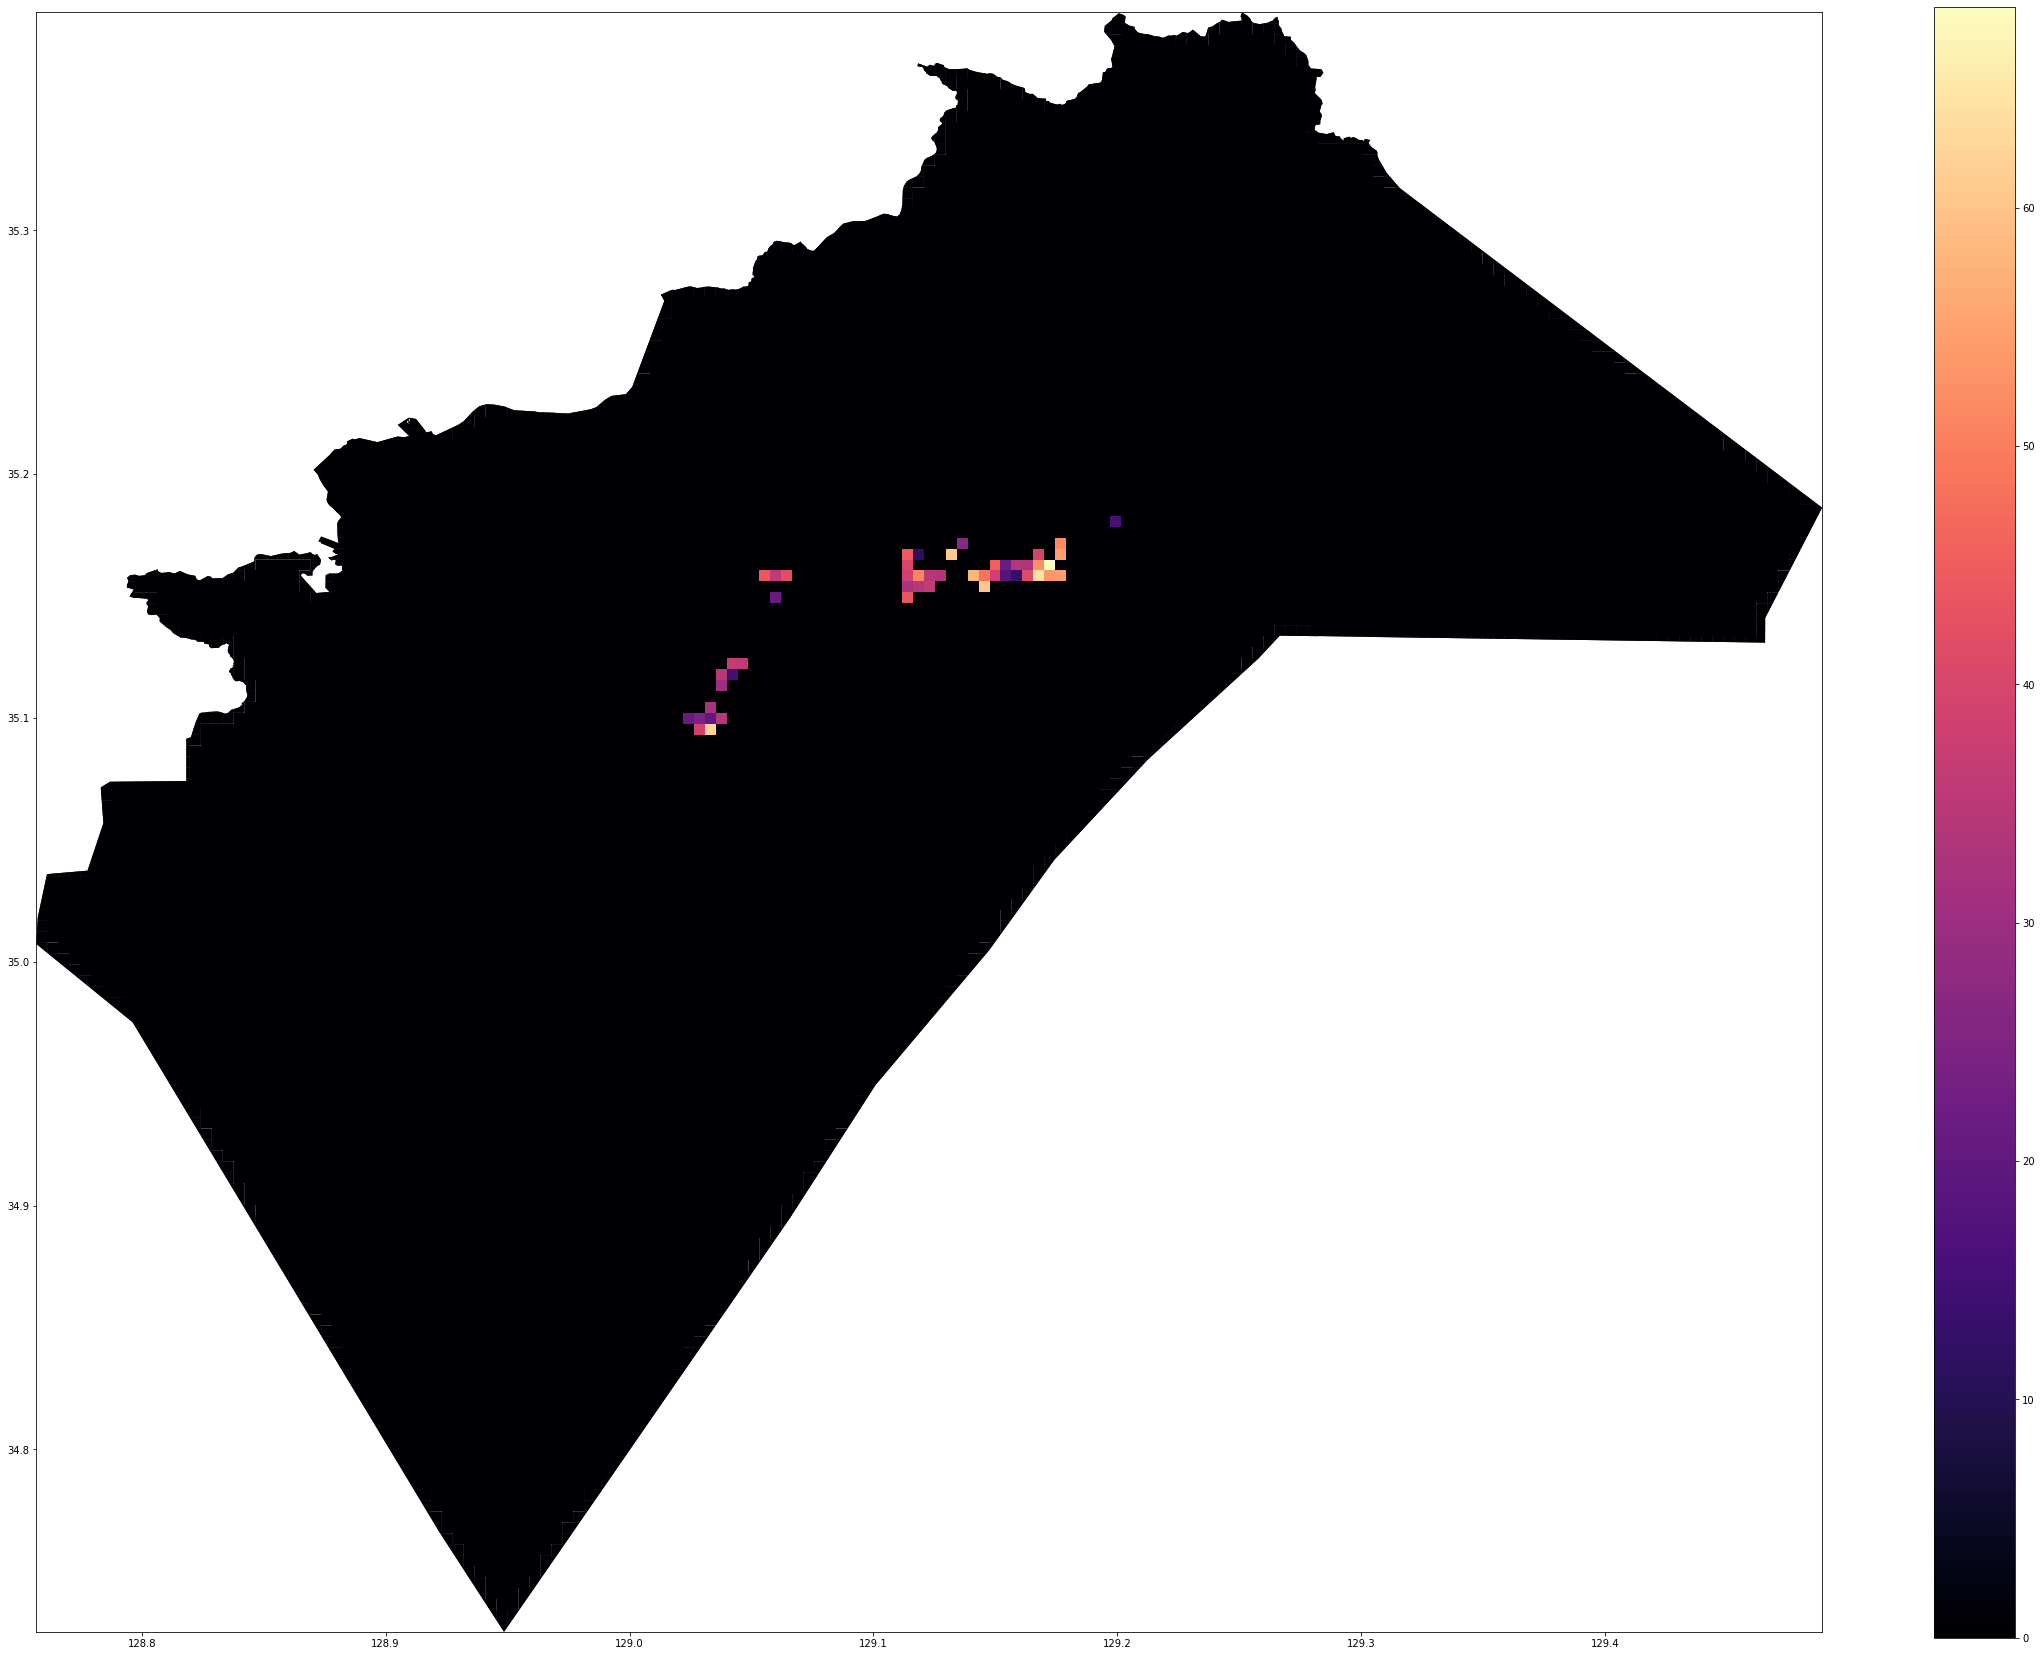

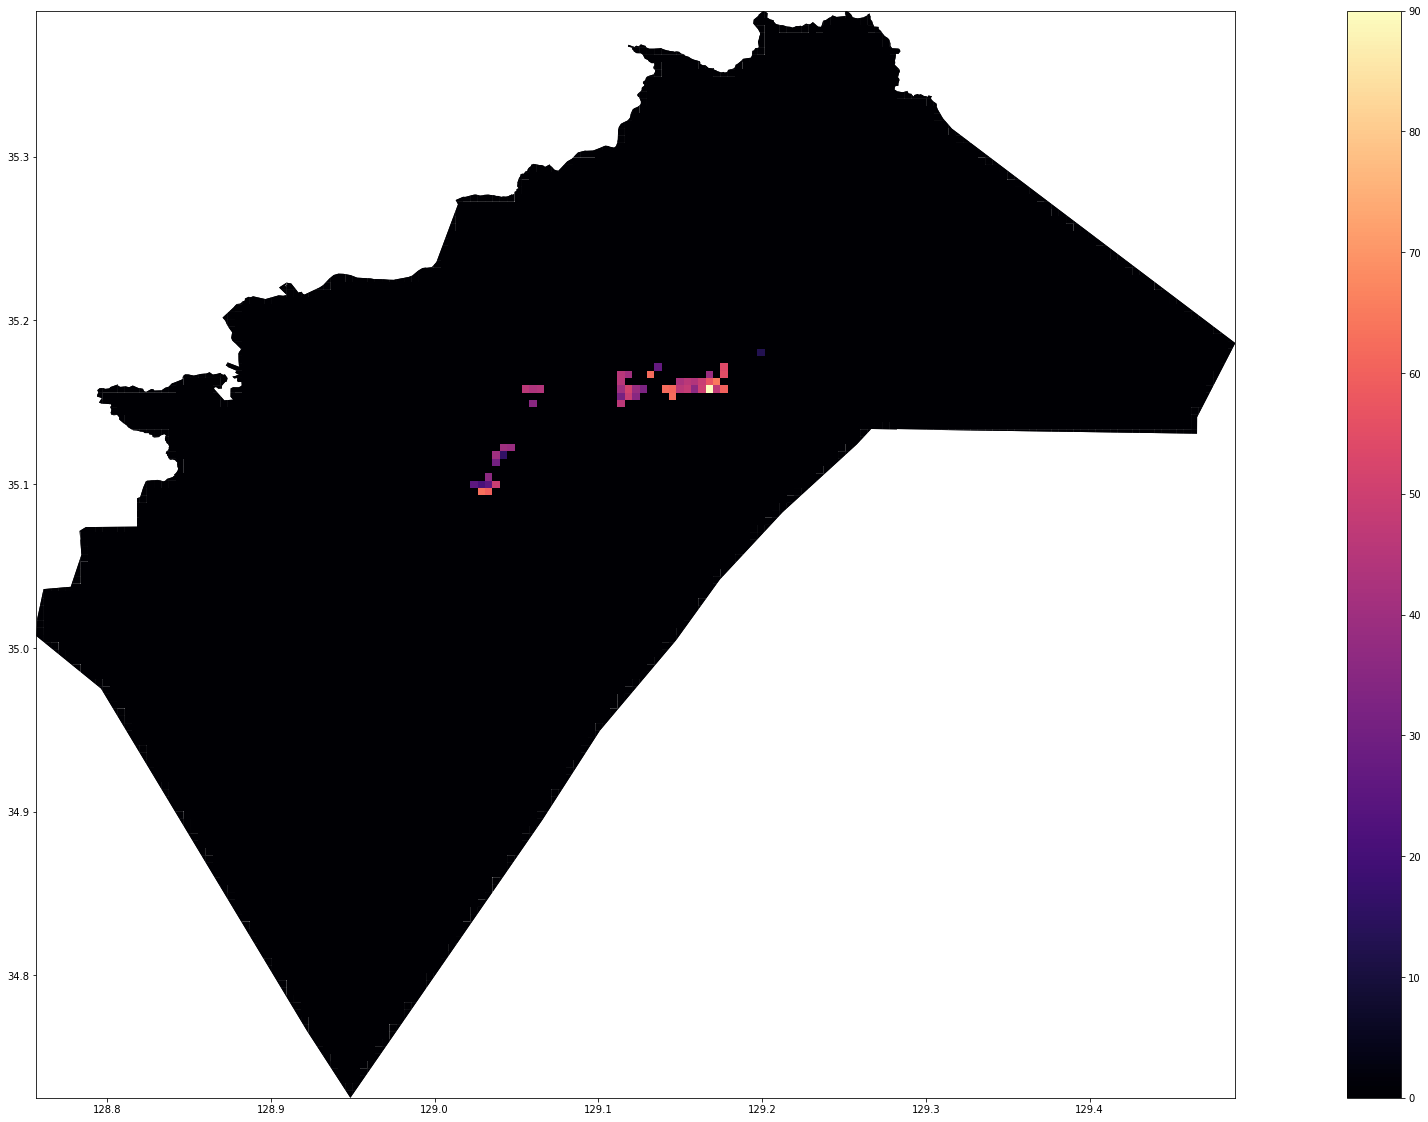

time: 51.7 s


In [4]:
data = pd.read_csv('data/Airbnb_Busan.csv', header=0, index_col=0)
data = data[['room_id','latitude', 'longitude', 'bedrooms', 'price']]
print(len(data))

data.reset_index(drop=True, inplace=True)
print("data max index:", data.index.max())
print("number of NA prices:", data.price.isna().sum())

data.loc[data.bedrooms == 0, 'bedrooms'] = 1

price_proom = np.divide(np.array(data[pd.notnull(data['bedrooms'])].price),np.array(data[pd.notnull(data['bedrooms'])].bedrooms))
mean_bed = np.mean(price_proom)
print("average bedroom price",mean_bed)

nan_list = data[data.bedrooms.isna()].index.tolist()
data.loc[data.bedrooms.isna(), 'bedrooms'] = np.ceil(data.loc[data.bedrooms.isna(), 'price']/mean_bed)

geometry = [Point(xy) for xy in zip(data.longitude, data.latitude)]
#data = data.drop(['longitude', 'latitude'], axis=1)
crs = {'init': 'epsg:4326'}
gdf = gpd.GeoDataFrame(data, crs=crs, geometry=geometry)

meter_500 = 0.00899928/2


# make the geometry a multipolygon if it's not already
geometry = city['geometry'].iloc[0]
if isinstance(geometry, Polygon):
    geometry = MultiPolygon([geometry])
    
# quadrat_width is in the units the geometry is in, so we'll do a tenth of a degree
geometry_cut = ox.quadrat_cut_geometry(geometry, quadrat_width=meter_500)

city['coords'] = city['geometry'].apply(lambda x: x.representative_point().coords[:])
city['coords'] = [coords[0] for coords in city['coords']]

polylist = [p for p in geometry_cut]
# plot the city
# west, south, east, north = city.unary_union.bounds
# fig, ax = plt.subplots(figsize=(60,40))
# for polygon, n in zip(geometry_cut, np.arange(len(polylist))):
#     p = polygon.representative_point().coords[:][0]
#     patch = PolygonPatch(polygon, fc='#ffffff', ec='#000000', alpha=0.5, zorder=2)
#     ax.add_patch(patch)
#     plt.annotate(s=n, xy=p,
#                  horizontalalignment='center', size=6)
    
# ax.set_xlim(west, east)
# ax.set_ylim(south, north)
# #ax.axis('off')
# plt.show()


polyframe = gpd.GeoDataFrame(geometry=polylist)
polyframe.crs = city.geometry.crs
polyframe['center_lon'] = polyframe['geometry'].apply(lambda x: x.centroid.coords[0][0])
polyframe['center_lat'] = polyframe['geometry'].apply(lambda x: x.centroid.coords[0][1])


pointInPoly = gpd.sjoin(polyframe, gdf, op='contains')
print("pointinpoly length:",len(pointInPoly))

#pointInPoly.sort_values(['PlateID', 'Time'], inplace=True)
pointInPoly['index'] = pointInPoly.index
pointInPoly.reset_index(drop=True, inplace=True)


present_ind = list(pointInPoly['index_right'])
gdf_test_dropped = gdf.iloc[present_ind,:]
gdf_dropped = gdf_test_dropped.copy()
gdf_dropped.reset_index(drop=True, inplace=True)

print("check contains:",polyframe.iloc[pointInPoly.loc[len(pointInPoly)-1, 'index']].geometry.contains(gdf_dropped.loc[len(pointInPoly)-1,'geometry']))
gdf_dropped['pindex'] = pointInPoly['index']

print("check if there are NAs:", gdf_dropped.isna().values.any())

pindex = gdf_dropped.pindex.unique()
airbnb_dict = dict(gdf_dropped.pindex.value_counts())
counts = pd.DataFrame(list(airbnb_dict.items()), columns=['key', 'count'])
counts = counts[counts['count']>7]
counts = counts.copy()
airbnb_dict = dict(zip(list(counts['key']), list(counts['count'])))
polyair = polyframe.copy()
polyair['count'] = 0
polyair['count'].update(pd.Series(airbnb_dict))

# plot the city
west, south, east, north = city.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,26))
# for polygon, n in zip(geometry_cut, np.arange(len(polylist))):
#     p = polygon.representative_point().coords[:][0]
#     patch = PolygonPatch(polygon, fc='#ffffff', ec='#000000', zorder=2)
#     ax.add_patch(patch)
#     plt.annotate(s=n, xy=p,
#                  horizontalalignment='center', size=7)

polyframe.plot(ax=ax, color='#000004')
polyair.plot(column='count',  legend=True, cmap='magma', ax=ax)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()


gdf_dropped = gdf_dropped[gdf_dropped.pindex.isin(airbnb_dict.keys())]
gdf_dropped = gdf_dropped.copy()
gdf_dropped = gdf_dropped[gdf_dropped['price'] > 0]
gdf_dropped = gdf_dropped.copy()
gdf_dropped['price_normalized'] = gdf_dropped.price.divide(gdf_dropped.bedrooms)
gdf_dropped = gdf_dropped[gdf_dropped.price_normalized<270]
gdf_dropped = gdf_dropped.copy()
gdf_dropped.reset_index(drop=True, inplace=True)
gdf_dropped.price_normalized.hist(bins=100)

prices_dict = dict(gdf_dropped.groupby('pindex')['price_normalized'].mean())
from scipy import stats
hmean_prices_dict = dict(gdf_dropped.groupby('pindex')['price_normalized'].apply(lambda x: stats.hmean(x)))
median_prices_dict = dict(gdf_dropped.groupby('pindex')['price_normalized'].median())

polyair['prices'] = 0
polyair['hmean_prices'] = 0
polyair['median_prices'] = 0
polyair['prices'].update(pd.Series(prices_dict))
polyair['hmean_prices'].update(pd.Series(hmean_prices_dict))
polyair['median_prices'].update(pd.Series(median_prices_dict))


# plot the city
west, south, east, north = city.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,26))
# for polygon, n in zip(geometry_cut, np.arange(len(polylist))):
#     p = polygon.representative_point().coords[:][0]
#     patch = PolygonPatch(polygon, fc='#ffffff', ec='#000000', zorder=2)
#     ax.add_patch(patch)
#     plt.annotate(s=n, xy=p,
#                  horizontalalignment='center', size=7)

polyframe.plot(ax=ax, color='#000004')
polyair.plot(column='prices',  legend=True, cmap='magma', ax=ax)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()



# plot the city
west, south, east, north = city.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,30))
# for polygon, n in zip(geometry_cut, np.arange(len(polylist))):
#     p = polygon.representative_point().coords[:][0]
#     patch = PolygonPatch(polygon, fc='#ffffff', ec='#000000', zorder=2)
#     ax.add_patch(patch)
#     plt.annotate(s=n, xy=p,
#                  horizontalalignment='center', size=7)

polyframe.plot(ax=ax, color='#000004')
polyair.plot(column='hmean_prices',  legend=True, cmap='magma', ax=ax)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()


# plot the city
west, south, east, north = city.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,20))
# for polygon, n in zip(geometry_cut, np.arange(len(polylist))):
#     p = polygon.representative_point().coords[:][0]
#     patch = PolygonPatch(polygon, fc='#ffffff', ec='#000000', zorder=2)
#     ax.add_patch(patch)
#     plt.annotate(s=n, xy=p,
#                  horizontalalignment='center', size=7)

polyframe.plot(ax=ax, color='#000004')
polyair.plot(column='median_prices',  legend=True, cmap='magma', ax=ax)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()


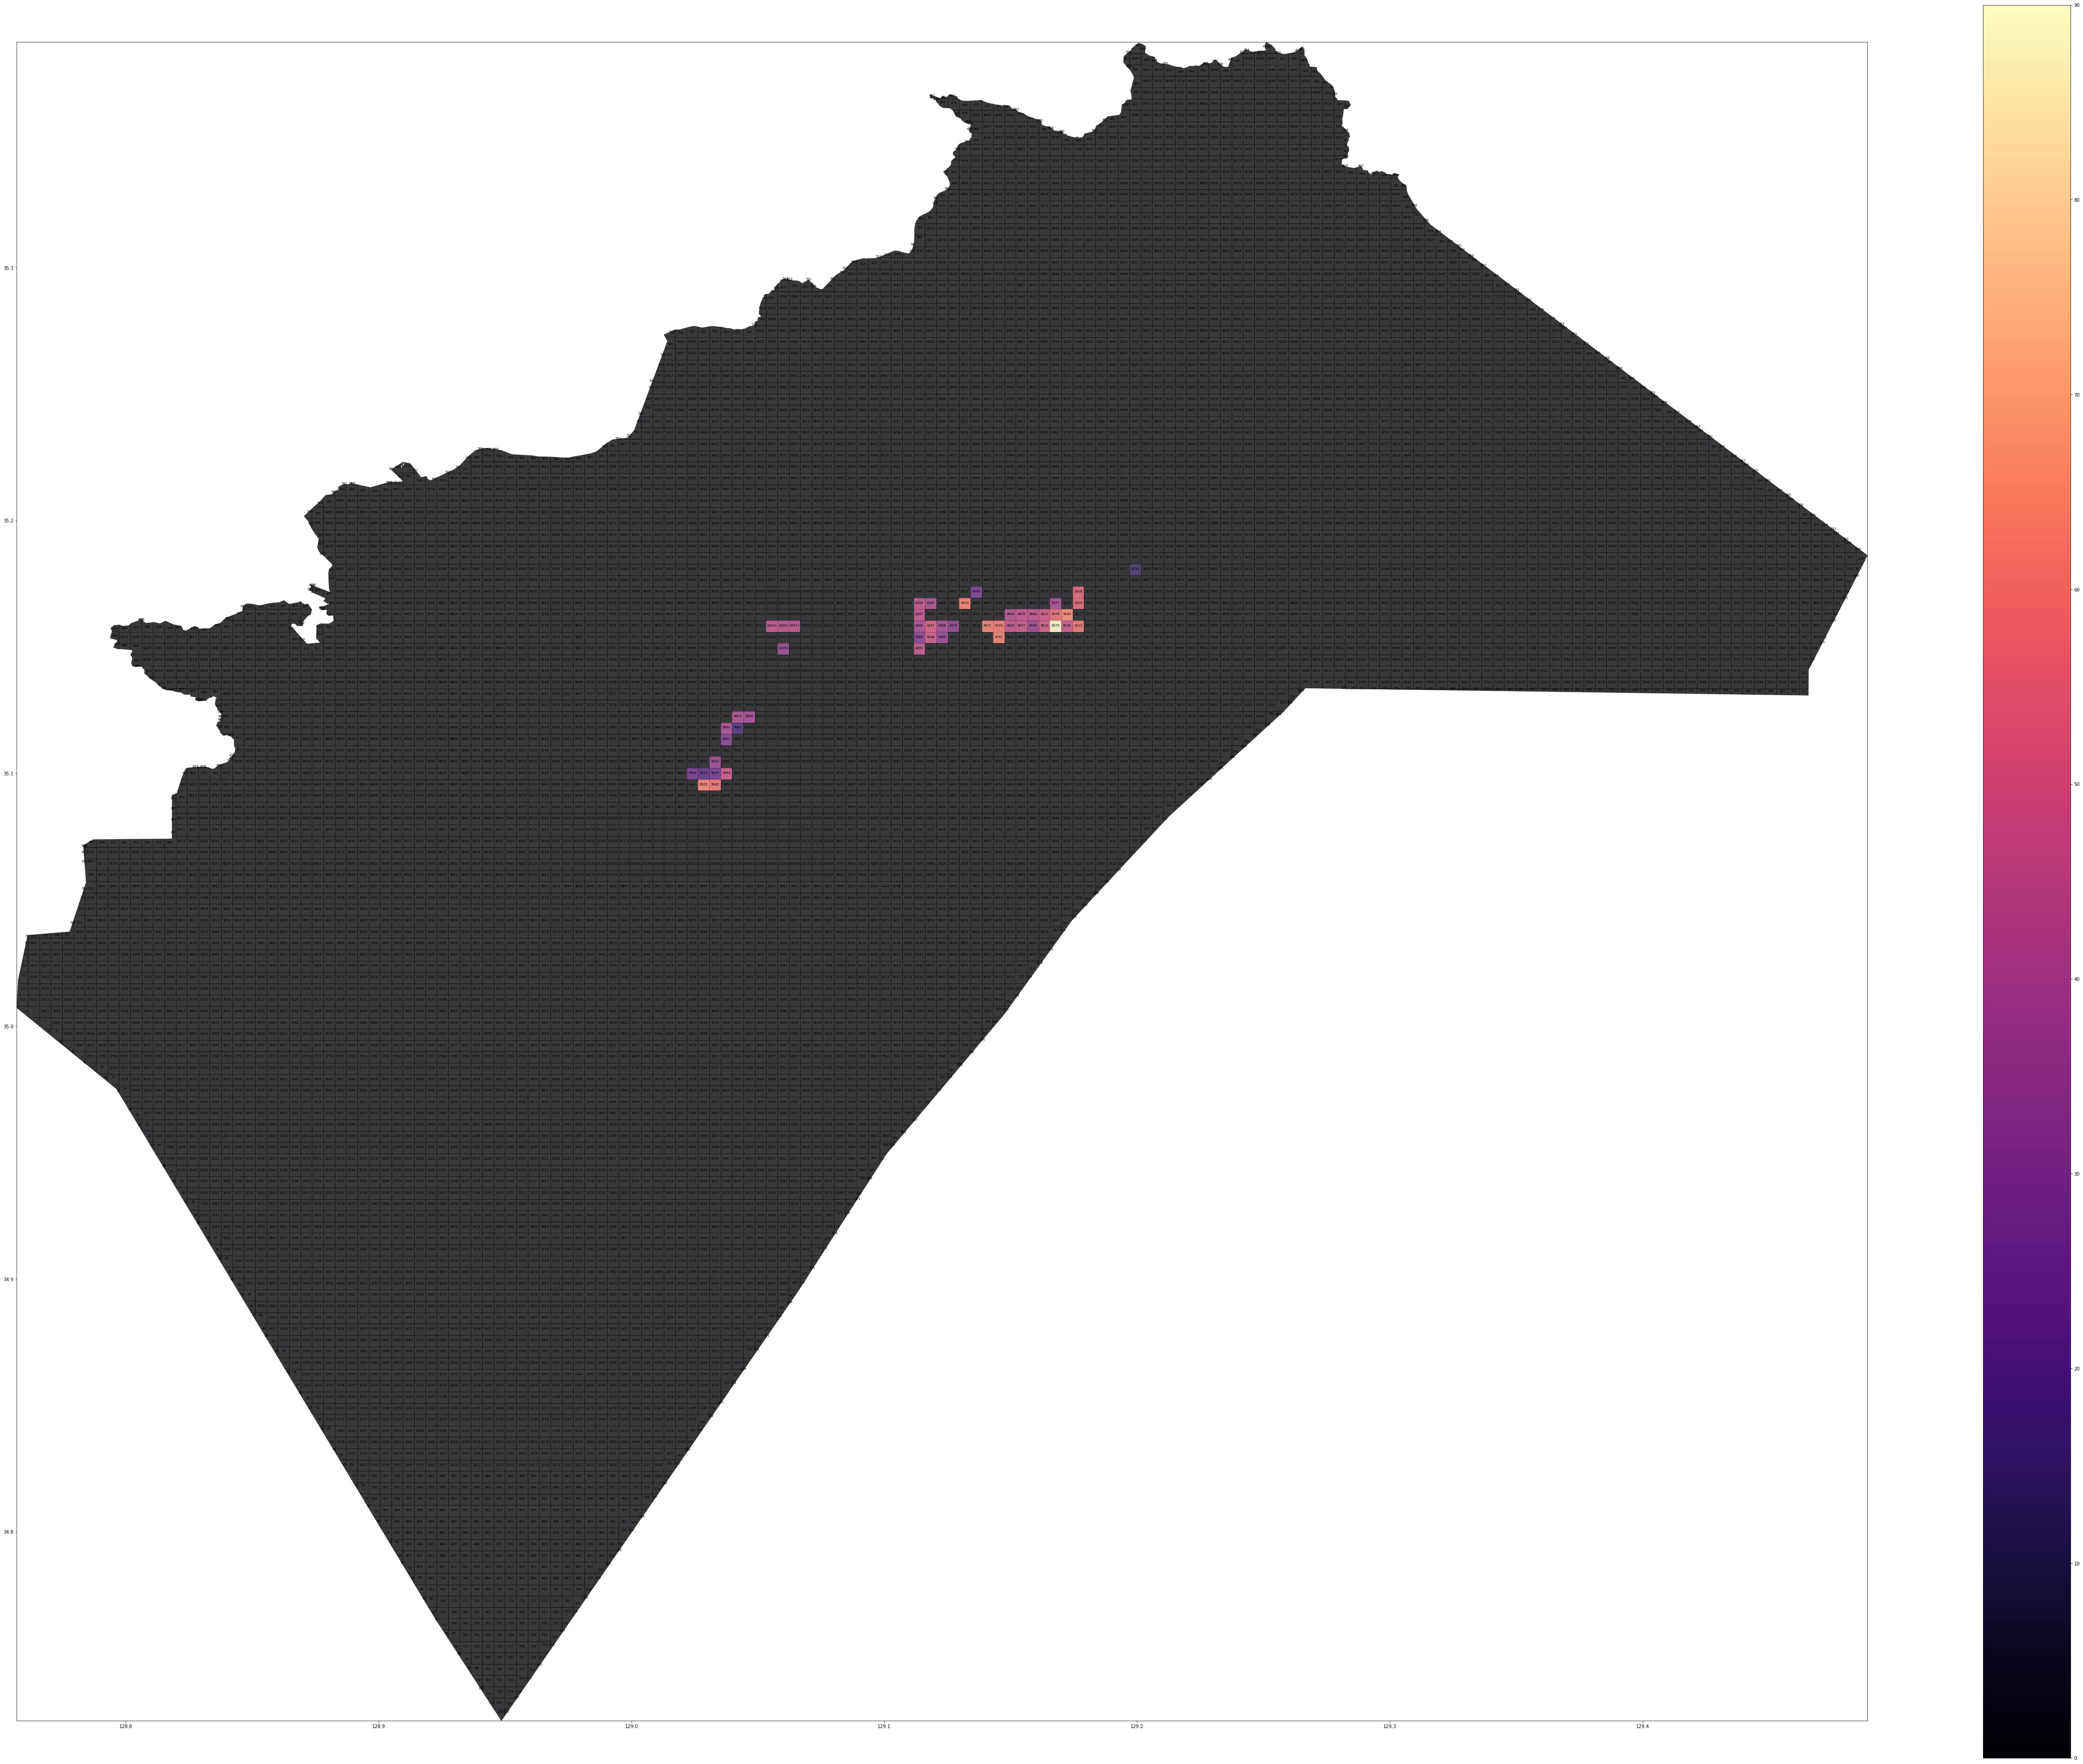

time: 1min 38s


In [5]:
# plot the city
west, south, east, north = city.unary_union.bounds
#fig, ax = plt.subplots(figsize=(40,20))
# for polygon, n in zip(geometry_cut, np.arange(len(polylist))):
#     p = polygon.representative_point().coords[:][0]
#     patch = PolygonPatch(polygon, fc='#ffffff', ec='#000000', zorder=2)
#     ax.add_patch(patch)
#     plt.annotate(s=n, xy=p,
#                  horizontalalignment='center', size=7)


fig, ax = plt.subplots(figsize=(90,70))
for polygon, n in zip(geometry_cut, np.arange(len(polylist))):
    p = polygon.representative_point().coords[:][0]
    patch = PolygonPatch(polygon, fc='#ffffff', ec='#000000', alpha=0.5)
    ax.add_patch(patch)
    plt.annotate(s=n, xy=p,
                 horizontalalignment='center', size=7)
polyframe.plot(ax=ax, color='#000004', alpha=0.5)
polyair.plot(column='median_prices',  legend=True, cmap='magma', ax=ax, alpha=0.7, zorder=2)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()

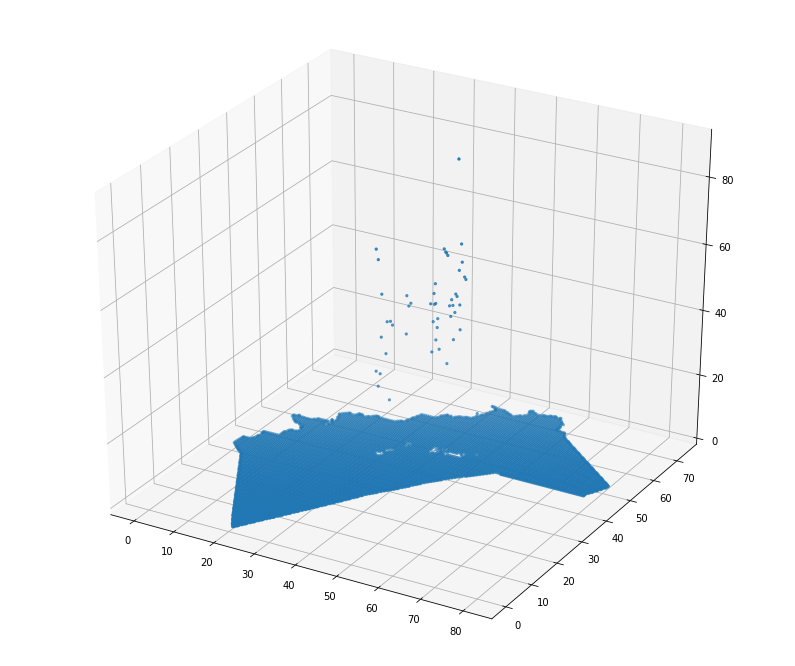

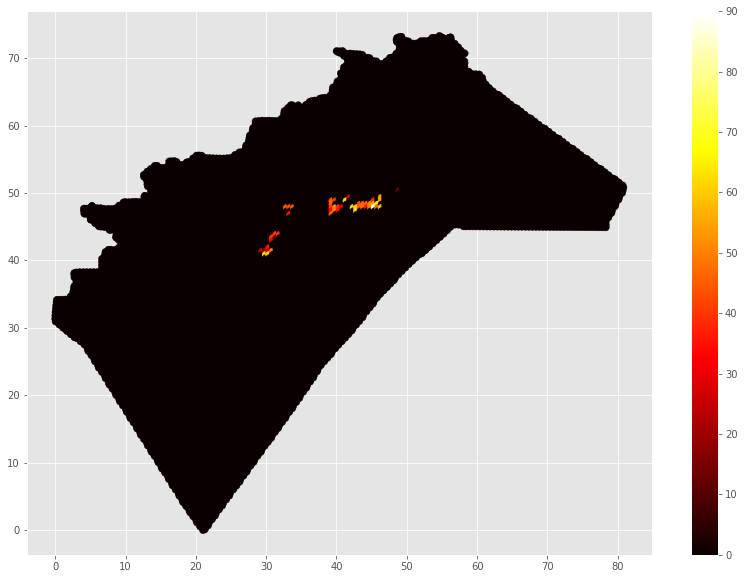

time: 3.24 s


In [6]:
import plotly.plotly as py
import plotly.graph_objs as go

# MatPlotlib
import matplotlib.pyplot as plt
from matplotlib import pylab
from mpl_toolkits.mplot3d import Axes3D
#x, y = np.array(polyair.center_lon), np.array(polyair.center_lat)

x = np.array(polyair.center_lon)*500/meter_500
x = x-x.min()
x = x/1000

y = np.array(polyair.center_lat)*500/meter_500 
y = y-y.min()
y = y/1000


# Plot the 3D figure of the fitted function and the residuals.
fig = plt.figure(figsize=(14,12))
ax = fig.gca(projection='3d')
ax.scatter(x, y, np.array(polyair.median_prices), cmap='plasma', s=5)
ax.set_zlim(0,np.max(np.array(polyair.median_prices))+2)
ax.view_init(30, 300)
plt.show()


plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(14,10))
scat = ax.scatter(x, y, c=np.array(polyair.median_prices), s=50, cmap='hot')
cbar = fig.colorbar(scat)
#cbar.set_clim(0, 250)
plt.savefig('images/Busan_observed.jpg')
plt.show()

In [7]:
cdf = polyair[polyair.index.isin([5079, 4533, 10051, 9925,9960])]
cdf["cen_lon_km"] = cdf['center_lon'].apply(lambda x: (x*500/meter_500 - (polyair.center_lon*500/meter_500).min())/1000)
cdf["cen_lat_km"] = cdf['center_lat'].apply(lambda x: (x*500/meter_500 - (polyair.center_lat*500/meter_500).min())/1000)
cdf

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



geometry  center_lon  \
4533   POLYGON ((129.1296174852806 35.16939463513064,...  129.131863   
5079   POLYGON ((129.165551006753 35.16042202431983, ...  129.167797   
9925   POLYGON ((129.0263086110474 35.09761374864415,...  129.028554   
9960   POLYGON ((129.0352919914155 35.12004527567118,...  129.037538   
10051  POLYGON ((129.0577504423358 35.16042202431983,...  129.059996   

       center_lat  count     prices  hmean_prices  median_prices  cen_lon_km  \
4533    35.167151     19  63.771930     60.895983           62.0   41.418711   
5079    35.158179     11  78.515152     64.273504           90.0   45.411644   
9925    35.095371     15  58.800000     38.618340           63.0   29.939029   
9960    35.117802      8  36.875000     34.274522           40.0   30.937262   
10051   35.158179     29  42.541379     36.006844           43.0   33.432845   

       cen_lat_km  
4533    48.785258  
5079    47.788221  
9925    40.808965  
9960    43.301557  
10051   47.788221

time: 807 ms


Fitted parameters:
[155.08822406  44.33398049  48.00369548  -0.15638593   0.9035577
   1.51086279   0.41286642]
RMS residual = 2.563821454723525


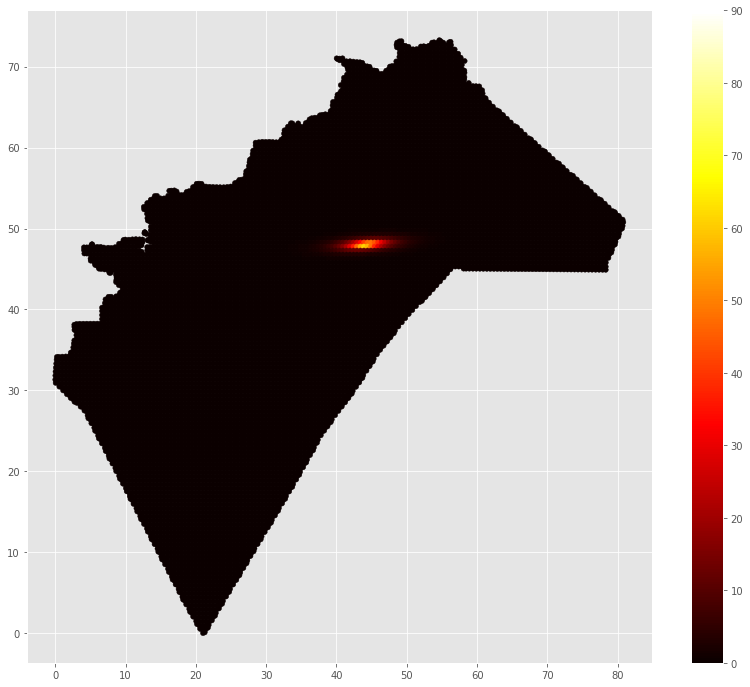

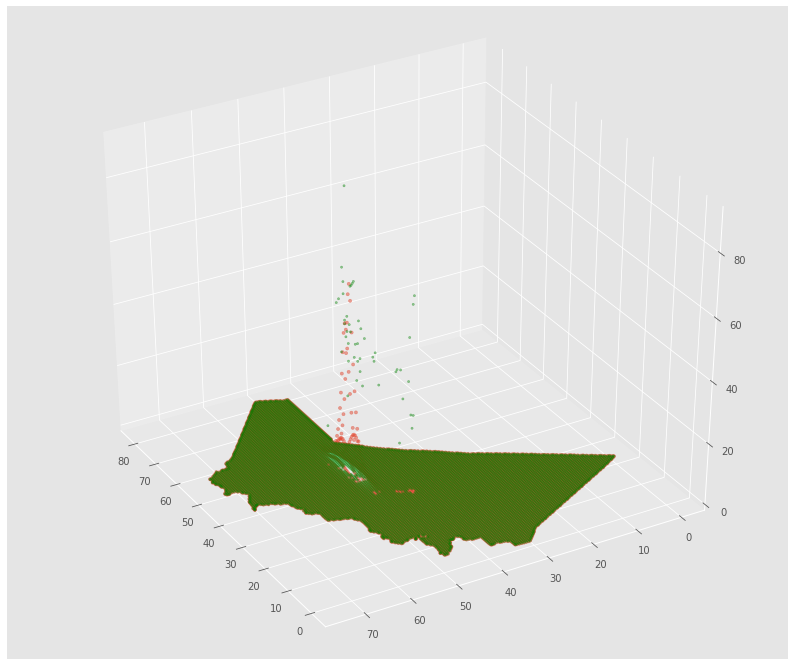

{'Busan': 0.41286641886903785}
time: 3.88 s


In [8]:
alphas = {}
xy = np.vstack([x, y])
zobs = np.array(polyair.median_prices)
#zobs = np.where(zobs>0, zobs, 0.1*zobs.max())
import scipy.optimize as opt
import matplotlib.pyplot as plt

def _gaussian(M, *args):
    xy = M
    arr = np.zeros(len(zobs))
    for i in range(len(args)//7):
        arr += twoD_Gaussian_alpha(xy, *args[i*7:i*7+7])
    return arr



guess_prms = [#(62,41.418711,48.785258, 3, 4.2,2.8, 1.4),
              (90,45.411644,47.788221,2.5, 4, 2, 1.2),
              #(63,29.939029,40.808965, 4, 3,3, 1.4),
              #(40,30.937262,43.301557, 1.6, 1.8,2, 1.4),
              #(43,33.432845,47.788221, 2.6, 2.9,3, 1.8)
             ]

# Flatten the initial guess parameter list.
p0 = [p for prms in guess_prms for p in prms]

def twoD_Gaussian_alpha(xy, amplitude, xo, yo, sigma_x, sigma_y, theta, alpha):
    x, y = xy
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2))**alpha)
    return g.ravel()
popt, pcov = opt.curve_fit(_gaussian, xy, zobs, p0)
#pred_params, uncert_cov = opt.curve_fit(gauss2d, xy, zobs, p0=guess)

zpred = np.zeros(len(zobs))
for i in range(len(popt)//7):
    zpred += twoD_Gaussian_alpha(xy, *popt[i*7:i*7+7])

# for i in range(len(popt)//5):
#     fit += gaussian(X, Y, *popt[i*5:i*5+5])
print('Fitted parameters:')
print(popt)

rms = np.sqrt(np.mean((zobs - zpred)**2))
print('RMS residual =', rms)


fig, ax = plt.subplots(figsize=(14,12))
scat = ax.scatter(x, y, c=zpred, vmin=0, vmax=zobs.max(), s=25, cmap='hot')
fig.colorbar(scat)
plt.savefig('Busan_fitted.jpg')
plt.show()


#x, y = np.array(polyair.center_lon), np.array(polyair.center_lat)
# Plot the 3D figure of the fitted function and the residuals.
fig = plt.figure(figsize=(14,12))
ax = fig.gca(projection='3d')
ax.scatter(x, y, zpred, cmap='plasma', s=10, alpha=0.5)
ax.scatter(x, y, zobs, color='green', s=5, alpha=0.4)
ax.set_zlim(0,np.max(np.array(polyair.median_prices))+2)
ax.view_init(35, 150)
plt.show()

alphas['Busan'] = np.mean(popt[6::7])
print(alphas)

In [9]:
import pickle
pickle_in = open("alphas.pickle","rb")
alphas_dict = pickle.load(pickle_in)
#prices_params_dict = {}
alphas_dict['Busan'] = 1.61286641886903785
print(alphas_dict)
pickle_out = open("alphas.pickle","wb")
pickle.dump(alphas_dict, pickle_out)
pickle_out.close()

{'Paris': 1.9119263949210794, 'Amsterdam': 1.6077156181165682, 'Stockholm': 1.4869621148124246, 'Arezzo': 1.5291330654483044, 'Berlin': 1.3281036059479567, 'Bordeaux': 1.387341915093677, 'Denver': 0.9886695315944182, 'Edinburgh': 1.7431661910906637, 'Lyon': 1.840995035260712, 'Madrid': 1.561423826026336, 'Buenos_Aires': 2.0626361633770363, 'Los_Angeles': 1.7386638625850566, 'Beijing': 1.77233254047711, 'Florence': 1.052999973906332, 'Moscow': 1.822610958759147, 'Porto': 1.4172416677632145, 'Prague': 1.3671832768992007, 'Reykjavik': 1.4194582940670377, 'Riga': 1.4587192546215861, 'Rome': 1.8608390724186512, 'Seoul': 1.3208669147673713, 'Siena': 0.6212787996336754, 'Sydney': 2.584174464016137, 'Tallin': 2.014994948135572, 'Treviso': 1.07320426583068, 'Valencia': 1.5432619, 'Venezia': 1.3156028460923, 'Verona': 1.4364606330705336, 'Vicenza': 1.20971848439062, 'Vienna': 1.3399164167136137, 'Wellington': 1.46363348, 'Zurich': 1.72383878, 'Aarhus': 1.87621535, 'Milan': 2.1468310347956194, 'B

Fitted parameters:
[ 5.22876498e+01  3.97338218e+01  4.78001953e+01 -4.53062141e-01
 -7.74171642e-01  6.09094987e+00  7.12648541e+01  4.45504610e+01
  4.79785859e+01  3.68990585e-01  1.59938149e+00  1.48838990e+00
  3.14902477e+01  3.60925146e+01  4.81220203e+01 -5.35613064e-02
  5.57971763e+00  1.44897653e+00  3.31289815e+02  3.04567569e+01
  4.10351671e+01  2.96751267e-01  1.11377270e-01 -3.88566811e-01
  4.32970824e+01  3.09008667e+01  4.28388963e+01 -1.30664236e+00
 -1.50013592e-01  1.77458997e+01]
RMS residual = 1.9076818339068986


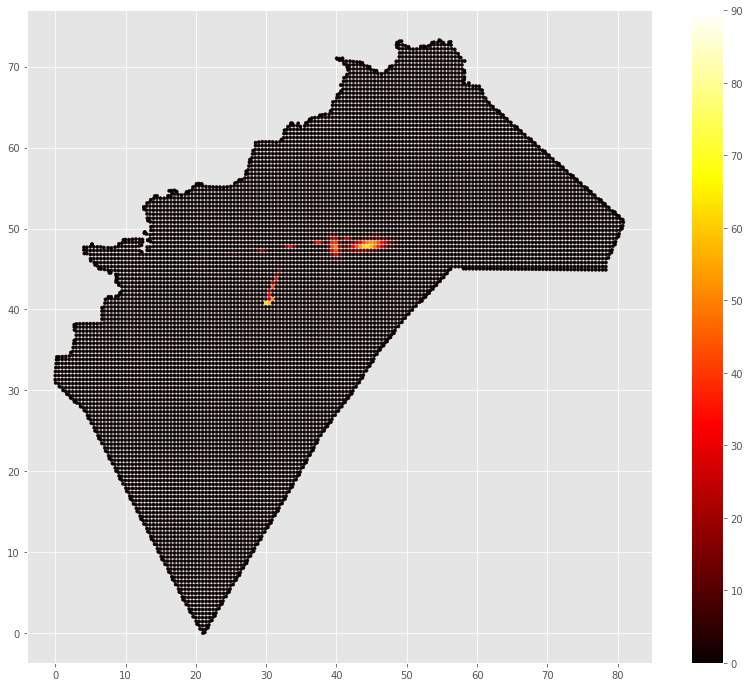

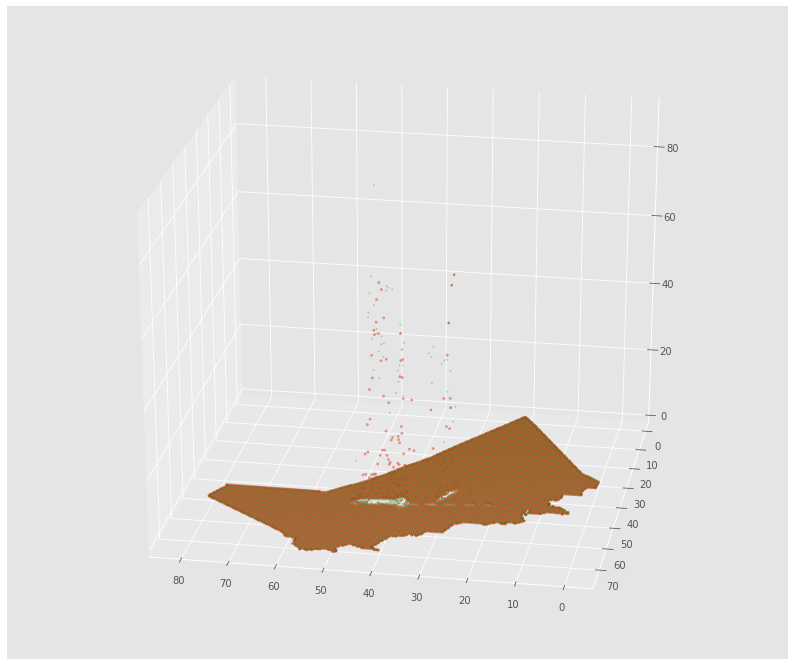

time: 17.1 s


In [10]:
xy = np.vstack([x, y])
zobs = np.array(polyair.median_prices)
#zobs = np.where(zobs>0, zobs, 0.1*zobs.max())
import scipy.optimize as opt
import matplotlib.pyplot as plt

def _gaussian(M, *args):
    xy = M
    arr = np.zeros(len(zobs))
    for i in range(len(args)//6):
        arr += twoD_Gaussian(xy, *args[i*6:i*6+6])
    return arr


guess_prms = [(62,41.418711,48.785258, 3, 4.2,2.8),
              (90,45.411644,47.788221,2.5, 4, 2),
              (63,29.939029,40.808965, 4, 3,3),
              (40,30.937262,43.301557, 1.6, 1.8,2),
              (43,33.432845,47.788221, 2.6, 2.3,3)
             ]

# Flatten the initial guess parameter list.
p0 = [p for prms in guess_prms for p in prms]

def twoD_Gaussian(xy, amplitude, xo, yo, sigma_x, sigma_y, theta):
    x, y = xy
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
    return g.ravel()
popt, pcov = opt.curve_fit(_gaussian, xy, zobs, p0)
#pred_params, uncert_cov = opt.curve_fit(gauss2d, xy, zobs, p0=guess)

zpred = np.zeros(len(zobs))
for i in range(len(popt)//6):
    zpred += twoD_Gaussian(xy, *popt[i*6:i*6+6])

# for i in range(len(popt)//5):
#     fit += gaussian(X, Y, *popt[i*5:i*5+5])
print('Fitted parameters:')
print(popt)

rms = np.sqrt(np.mean((zobs - zpred)**2))
print('RMS residual =', rms)


fig, ax = plt.subplots(figsize=(14,12))
scat = ax.scatter(x, y, c=zpred, vmin=0, vmax=zobs.max(), s=10, cmap='hot')
fig.colorbar(scat)
plt.savefig('Busan_fitted.jpg')
plt.show()


#x, y = np.array(polyair.center_lon), np.array(polyair.center_lat)
# Plot the 3D figure of the fitted function and the residuals.
fig = plt.figure(figsize=(14,12))
ax = fig.gca(projection='3d')
ax.scatter(x, y, zpred, cmap='plasma', s=5, alpha=0.5)
ax.scatter(x, y, zobs, color='green', s=2, alpha=0.2)
ax.set_zlim(0,np.max(np.array(polyair.median_prices))+2)
ax.view_init(25, 100)
plt.show()

In [11]:
def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

sqrt_eigs_long = np.array([])
sqrt_eigs_short = np.array([])
for i in range(0, len(popt), 6):
    a = (np.cos(popt[i+5])**2)/(2*popt[i+3]**2) + (np.sin(popt[i+5])**2)/(2*popt[i+4]**2)
    b = -(np.sin(2*popt[i+5]))/(4*popt[i+3]**2) + (np.sin(2*popt[i+5]))/(4*popt[i+4]**2)
    c = (np.sin(popt[i+5])**2)/(2*popt[i+3]**2) + (np.cos(popt[i+5])**2)/(2*popt[i+4]**2)
    cov = np.array([a, b, b, c]).reshape(-1, 2)
    print("Is cov_{} positive definite?: ".format(i//6+1), is_pos_def(cov))
    eigenvalues = np.linalg.eigvals(cov)
    eigenvalues = eigenvalues[eigenvalues>0]
    if eigenvalues.size!=0:
        stds = np.sqrt(eigenvalues)/popt[i]
        #stds = stds[stds>=0]
        sqrt_eigs_long = np.append(sqrt_eigs_long,max(stds))
        sqrt_eigs_short = np.append(sqrt_eigs_short,min(stds))

print('long stds: ', sqrt_eigs_long, 'mean: ', np.mean(sqrt_eigs_long))
print('short stds: ', sqrt_eigs_short, 'mean: ', np.mean(sqrt_eigs_short))

Is cov_1 positive definite?:  True
Is cov_2 positive definite?:  True
Is cov_3 positive definite?:  True
Is cov_4 positive definite?:  True
Is cov_5 positive definite?:  True
long stds:  [0.02984888 0.02689022 0.41923522 0.01916374 0.10886688] mean:  0.12080098915579789
short stds:  [0.01746822 0.0062038  0.00402436 0.00719257 0.01249884] mean:  0.009477557176268839
time: 7 ms


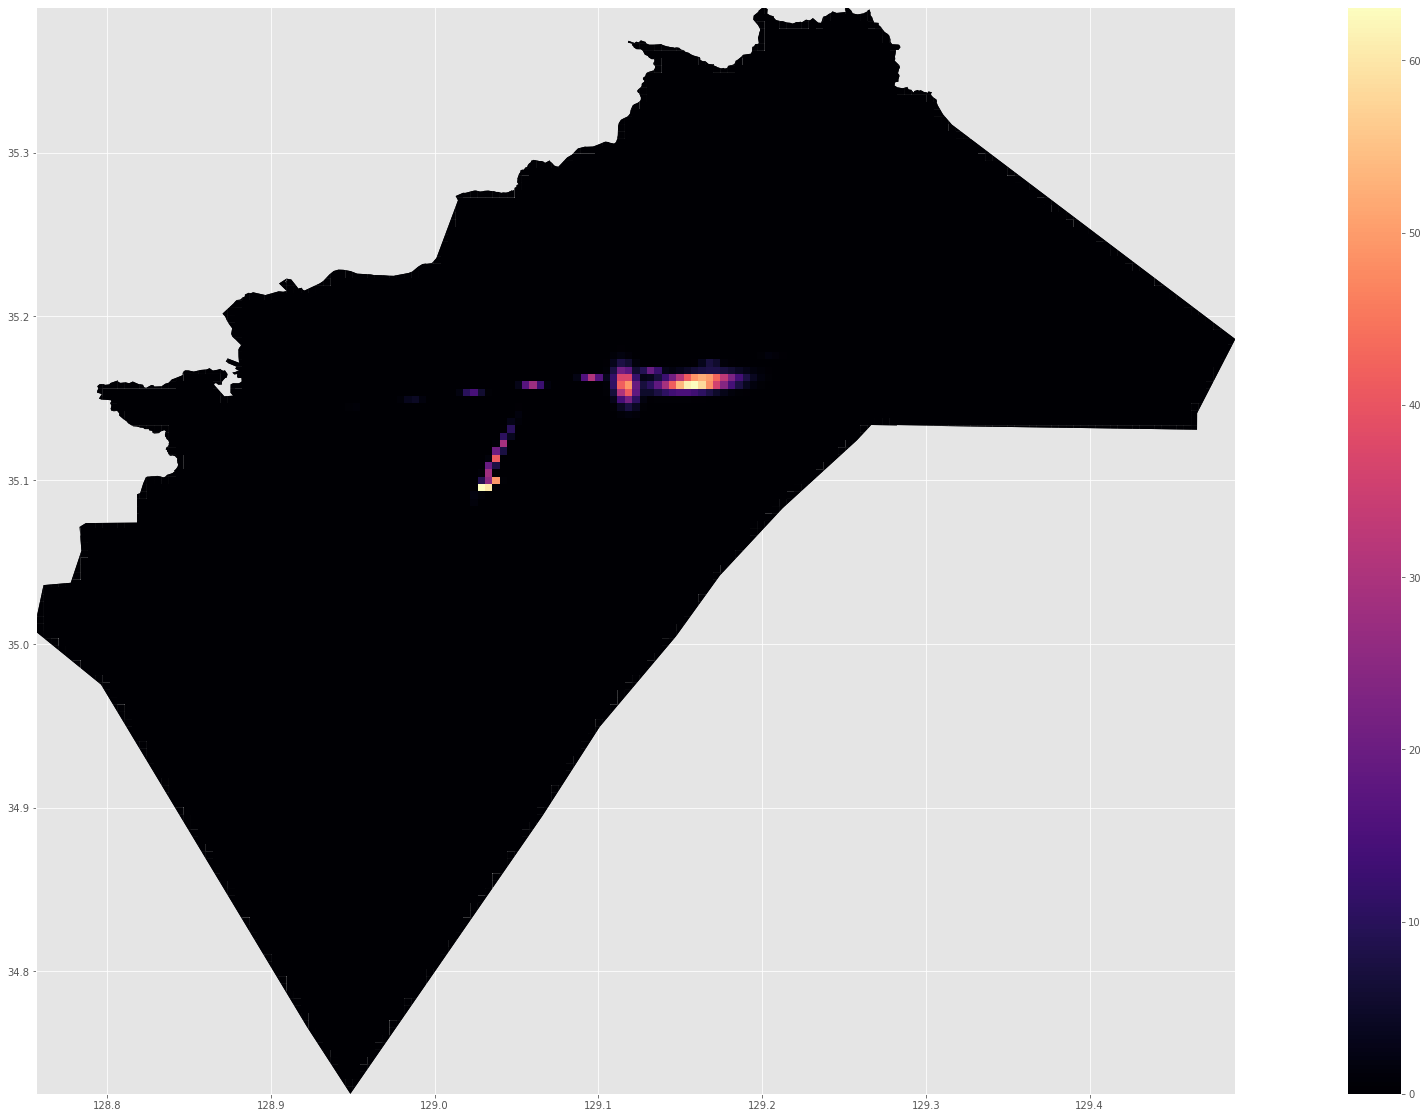

time: 5.52 s


In [12]:
polyair['zpred'] = zpred
# plot the city
west, south, east, north = city.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,20))

polyframe.plot(ax=ax, color='#000004')
polyair.plot(column='zpred',  legend=True, cmap='magma', ax=ax)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()

In [13]:
import pickle
pickle_in = open("Prices_params.pickle","rb")
prices_params_dict = pickle.load(pickle_in)
#prices_params_dict = {}
prices_params_dict['Busan'] = popt
pickle_out = open("Prices_params.pickle","wb")
pickle.dump(prices_params_dict, pickle_out)
pickle_out.close()

#average_slopes = {}
pickle_in_long = open("Average_price_slopes_long.pickle","rb")
average_slopes_long = pickle.load(pickle_in_long)
average_slopes_long['Busan'] = np.mean(sqrt_eigs_long)
pickle_out_long = open("Average_price_slopes_long.pickle","wb")
pickle.dump(average_slopes_long, pickle_out_long)
pickle_out_long.close()

pickle_in_short = open("Average_price_slopes_short.pickle","rb")
average_slopes_short = pickle.load(pickle_in_short)
average_slopes_short['Busan'] = np.mean(sqrt_eigs_short)
pickle_out_short = open("Average_price_slopes_short.pickle","wb")
pickle.dump(average_slopes_short, pickle_out_short)
pickle_out_short.close()

print('long: ', average_slopes_long, '\n', '\n', ' short: ', average_slopes_short)

long:  {'Paris': 0.010453121182320417, 'Amsterdam': 0.017790862401138207, 'Stockholm': 0.01160078748441716, 'Arezzo': 0.012661960610292892, 'Berlin': 0.017168942092868542, 'Bordeaux': 0.0057209390468692745, 'Denver': 0.00873766709683174, 'Edinburgh': 0.012921100209712873, 'Lyon': 0.00594530194011358, 'Madrid': 0.01315080289968449, 'Buenos_Aires': 0.00938788752473718, 'Palermo': 0.02659431146972356, 'Los_Angeles': 0.0056655377791732745, 'Beijing': 0.03548021455387483, 'Florence': 0.011913882705309832, 'Moscow': 0.026524810524746, 'Porto': 0.03745056113103571, 'Prague': 0.01850581507565583, 'Reykjavik': 0.04000475004839031, 'Riga': 0.02150786435094239, 'Rome': 0.009635062558537275, 'Seoul': 0.013154650694260608, 'Siena': 0.013838139160990736, 'Sydney': 0.009200022664460229, 'Tallin': 0.024848430854086192, 'Treviso': 0.015264513943951563, 'Valencia': 0.01982718757582555, 'Venezia': 0.013133572970121148, 'Verona': 0.01119208328282184, 'Vicenza': 0.029546407262138693, 'Vienna': 0.0120270170

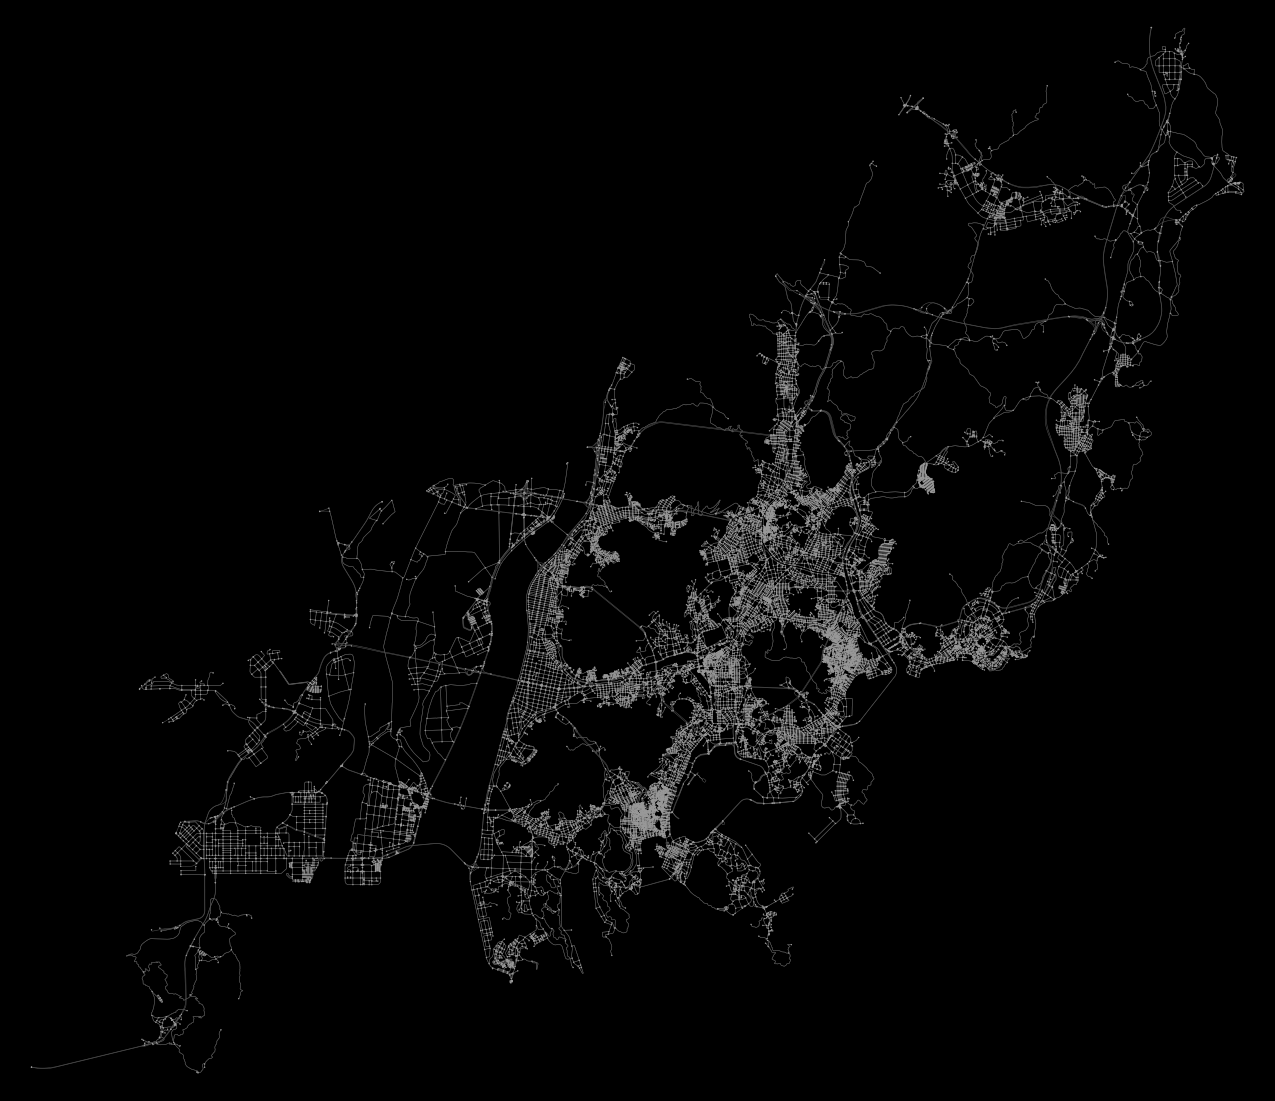

time: 55.7 s


In [14]:
# download and project a street network
G = ox.graph_from_place('Busan, South Korea', network_type="drive")
#G = ox.project_graph(G)
fig, ax = ox.plot_graph(G, fig_height=20, bgcolor='k', node_size=2, node_color='#999999', node_edgecolor='none', node_zorder=2,
                        edge_color='#555555', edge_linewidth=0.5, edge_alpha=1)

In [15]:
centers = {}
for i in range(0, len(popt), 6):
    lon = popt[i+1]*1000 + (np.array(polyair.center_lon)*500/meter_500).min()
    lon = lon*meter_500/500
    lat = popt[i+2]*1000 + (np.array(polyair.center_lat)*500/meter_500).min()
    lat = lat*meter_500/500
    centers['center_node_{}'.format(i//6+1)] = ox.get_nearest_node(G, (lat,lon))

centers

{'center_node_1': 1776202911,
 'center_node_2': 5920453189,
 'center_node_3': 1770960823,
 'center_node_4': 436460512,
 'center_node_5': 4928363026}

time: 726 ms


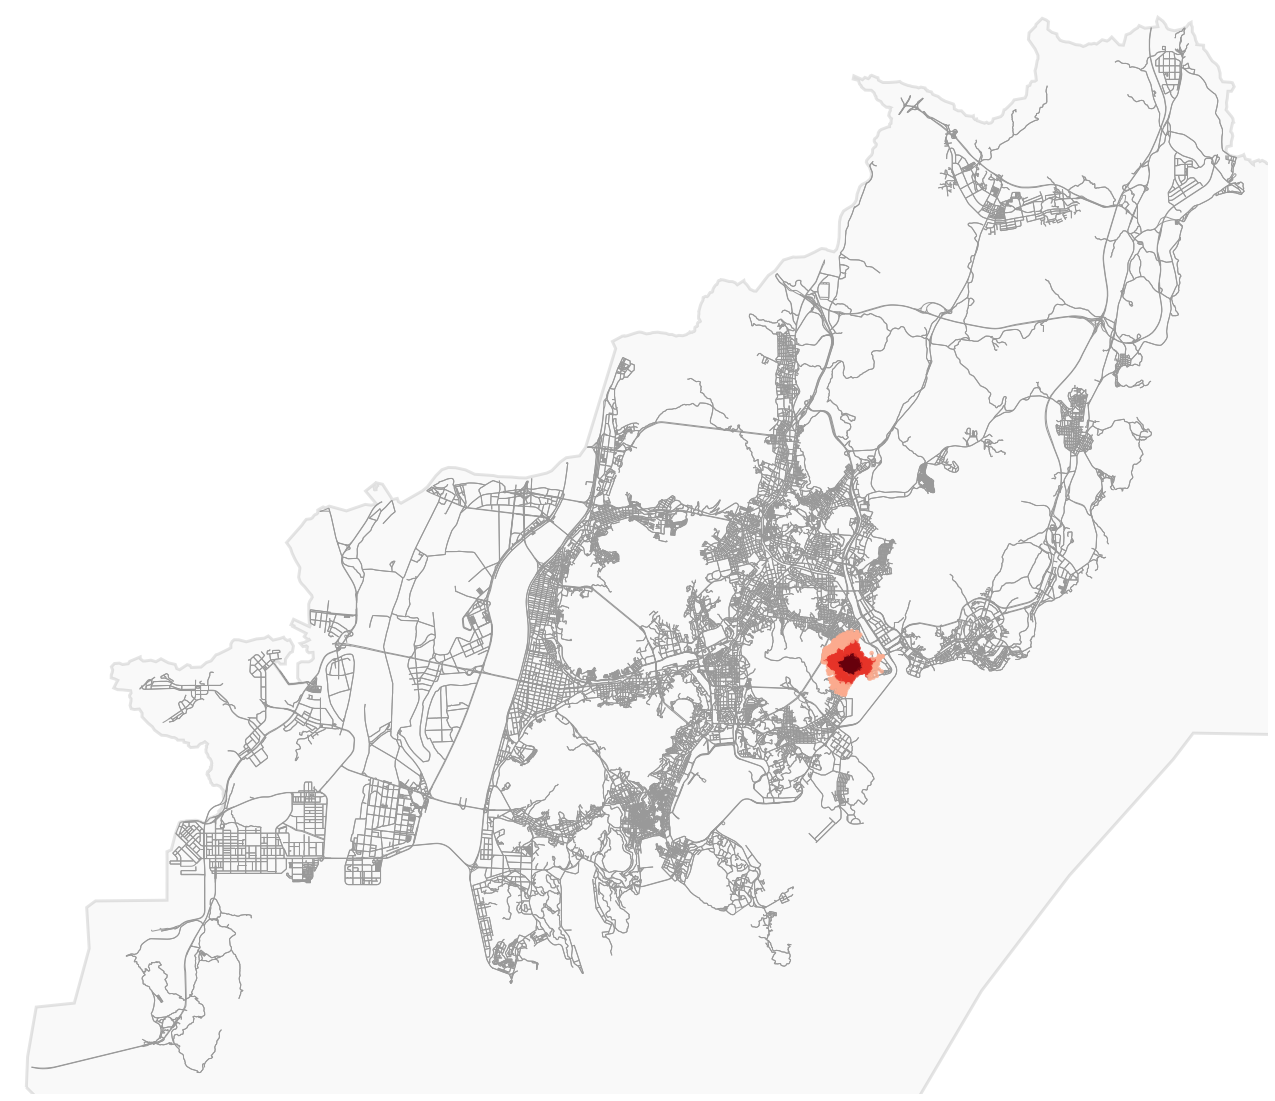

time: 12.8 s


In [16]:
import networkx as nx
#center_node = ox.get_nearest_node(G, (popt[8],popt[7]))
center_node = centers['center_node_1']
# list of distances from center
dists = np.arange(500, 2000, 500)
dists

# get one color for each isochrone
iso_colors = ox.get_colors(n=len(dists), cmap='Reds', start=0.3, return_hex=True)
# color the nodes according to isochrone then plot the street network
node_colors = {}
for dist, color in zip(sorted(dists, reverse=True), iso_colors):
    subgraph = nx.ego_graph(G, center_node, radius=dist, distance='length')
    for node in subgraph.nodes():
        node_colors[node] = color
nc = [node_colors[node] if node in node_colors else 'none' for node in G.nodes()]
ns = [20 if node in node_colors else 0 for node in G.nodes()]
fig, ax = ox.plot_graph(G, fig_height=20,show=False, close=False, node_color=nc, node_size=ns, node_alpha=0.8, node_zorder=2)
plt.close()
# to this matplotlib axis, add the place shape as descartes polygon patches
for geometry in city['geometry'].tolist():
    if isinstance(geometry, (Polygon, MultiPolygon)):
        if isinstance(geometry, Polygon):
            geometry = MultiPolygon([geometry])
        for polygon in geometry:
            patch = PolygonPatch(polygon, fc='#cccccc', ec='k', linewidth=3, alpha=0.1, zorder=-1)
            ax.add_patch(patch)
            
fig

10286
10286 133
Number of cells with price above 5th percentile:  133



[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Yes


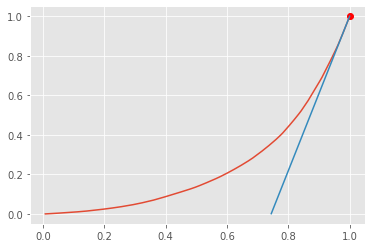

Loubar price:  20.993354115297155
Average price:  15.991867249797044
average city distance:  7348.804402235624
eta =  0.9482741712322014
time: 39.7 s


In [17]:
from tqdm import tqdm_notebook

#poly_prices = polyair[polyair.median_prices>0]
poly_prices = polyair.copy()
print(len(poly_prices))
poly_prices['zpred'] = zpred

lorentz_vals = poly_prices.zpred.to_dict()
s = [(k, lorentz_vals[k]) for k in sorted(lorentz_vals, key=lorentz_vals.get)]
keys = []
vals = []
for k,v in s:
    keys.append(k)
    vals.append(v)
    

vals = np.array(vals)
keys = np.array(keys)

vals_cut = vals[vals>0.02*vals.max()]
print(len(vals), len(vals_cut))

L = np.cumsum(vals_cut)/np.sum(vals_cut)
keys = keys[vals>0.02*vals.max()]
print('Number of cells with price above 5th percentile: ', len(keys))



mat = np.zeros(shape=(len(geometry_cut), len(geometry_cut)))
for pair in tqdm_notebook(combinations(sorted(keys), 2)):
    mat[pair[0], pair[1]] = geometry_cut[pair[0]].centroid.distance(geometry_cut[pair[1]].centroid)
    
print(mat)


def isuppertriangular(M): 
    for i in range(1, len(M)): 
        for j in range(0, i): 
            if(M[i][j] != 0):  
                    return False
    return True

  
if isuppertriangular(mat): 
    print ("Yes") 
else: 
    print ("No") 
    
    
L1= L
F1 = np.arange(1, len(L1)+1)/len(L1)

L1 = (L1 - L1.min())/(L1.max()-L1.min())

from scipy import interpolate
tck = interpolate.splrep(F1,L1)
x0_1 =1
y0_1 = interpolate.splev(x0_1,tck)
dydx = interpolate.splev(x0_1,tck,der=1)
tngnt1 = lambda x: dydx*x + (y0_1-dydx*x0_1)
plt.plot(F1, L1)
plt.plot(x0_1,y0_1, "or")
plt.plot(F1[tngnt1(F1)>0],tngnt1(F1[tngnt1(F1)>0]), label="tangent")
plt.show()

indlist = poly_prices.index.tolist()

loubar_val = vals_cut[np.where(tngnt1(F1)>0)[0][0]]

print('Loubar price: ', loubar_val)
print('Average price: ', np.mean(vals_cut))

if loubar_val > np.mean(vals_cut):
    loubar_keys = keys[vals_cut>loubar_val]
else:
    loubar_keys = keys[vals_cut>np.mean(vals_cut)]
#loubar_keys = keys[vals_cut>loubar_val]
dist_mat = mat[keys.reshape(-1,1), keys]

total_dist = dist_mat.sum()
dist_corr = dist_mat[dist_mat>0]

loubar_dist_mat = mat[loubar_keys.reshape(-1,1), loubar_keys]
loubar_dist = loubar_dist_mat.sum()

loubar_dist_corr = loubar_dist_mat[loubar_dist_mat>0]
eta_loubar = loubar_dist_corr.mean()/dist_corr.mean()

x = np.array(polyair.center_lon)*500/meter_500
x = x-x.min()
x = x/1000

avg_dist_meters = (dist_corr.mean()/0.00899928)*1000
print('average city distance: ', avg_dist_meters)
print('eta = ', eta_loubar)

In [18]:
pickle_in = open("City_spreading_index.pickle","rb")
spreading_index_dict = pickle.load(pickle_in)
#spreading_index_dict = {}
spreading_index_dict['Busan'] = eta_loubar


pickle_out = open("City_spreading_index.pickle","wb")
pickle.dump(spreading_index_dict, pickle_out)
pickle_out.close()

spreading_index_dict

{'Paris': 0.7251609142253275,
 'Amsterdam': 0.6513935879350918,
 'Stockholm': 0.6839327295656318,
 'Arezzo': 0.5574311537992848,
 'Berlin': 0.7499866909236614,
 'Bordeaux': 0.5818334466519048,
 'Denver': 0.6312111392217781,
 'Edinburgh': 0.6813298654934006,
 'Lyon': 0.6138305864151811,
 'Madrid': 0.6426066210787698,
 'Buenos_Aires': 0.8337988194080271,
 'Palermo': 0.8841435007903967,
 'Los_Angeles': 0.7889452782510832,
 'Beijing': 0.6425383574699105,
 'Florence': 0.5049117106731263,
 'Moscow': 0.6925493573699144,
 'Porto': 0.7058843952576399,
 'Prague': 0.5522963433539414,
 'Reykjavik': 0.8276260142343259,
 'Riga': 0.6850021296374689,
 'Rome': 0.5803964773671335,
 'Seoul': 0.8924742030382572,
 'Siena': 0.5646389917673048,
 'Sydney': 0.7909301400958108,
 'Tallin': 0.5690189423395199,
 'Treviso': 0.5345662066021125,
 'Valencia': 0.6956994914059091,
 'Venezia': 0.656650370883064,
 'Verona': 0.5707647012625697,
 'Vicenza': 0.5117751186840898,
 'Vienna': 0.6189242538490607,
 'Wellington': 0

time: 7.98 ms


In [19]:
pickle_in = open("avg_distances_dict.pickle","rb")
avg_distances_dict = pickle.load(pickle_in)
#avg_distances_dict = {}
avg_distances_dict['Busan'] = avg_dist_meters


pickle_out = open("avg_distances_dict.pickle","wb")
pickle.dump(avg_distances_dict, pickle_out)
pickle_out.close()

avg_distances_dict

{'Venezia': 2398.636425932576,
 'Verona': 3141.8502884813342,
 'Vicenza': 1988.2224372858566,
 'Vienna': 5125.89366602888,
 'Wellington': 2806.4963410749997,
 'Zurich': 2068.4583585914684,
 'Aarhus': 2857.919349359045,
 'Milan': 6008.128043000454,
 'Busan': 7348.804402235624,
 'Valencia': 4090.433301180094,
 'Bologna': 2104.4589605649485,
 'Barcelona': 4218.232625020259,
 'Bremen': 3495.925661234734,
 'Brno': 2231.9772664038364,
 'Budapest': 3463.3335339061914,
 'Dublin': 4138.1465107736385,
 'Boston': 5610.60832524716,
 'Rio': 8357.334811118957,
 'NY': 8563.096975538809,
 'Ottawa': 2220.3476963993976,
 'Nashville': 5606.900406329212,
 'New_Orleans': 5048.047130029565,
 'Shanghai': 5452.583570486633,
 'Portland': 5406.388840795854,
 'Amsterdam': 7020.480387015727,
 'Arezzo': 1662.0178383704194,
 'Beijing': 6586.560663166117,
 'Berlin': 8495.253652229821,
 'Bordeaux': 3886.5511701192345,
 'Buenos_Aires': 4620.5517793826875}

time: 5.98 ms


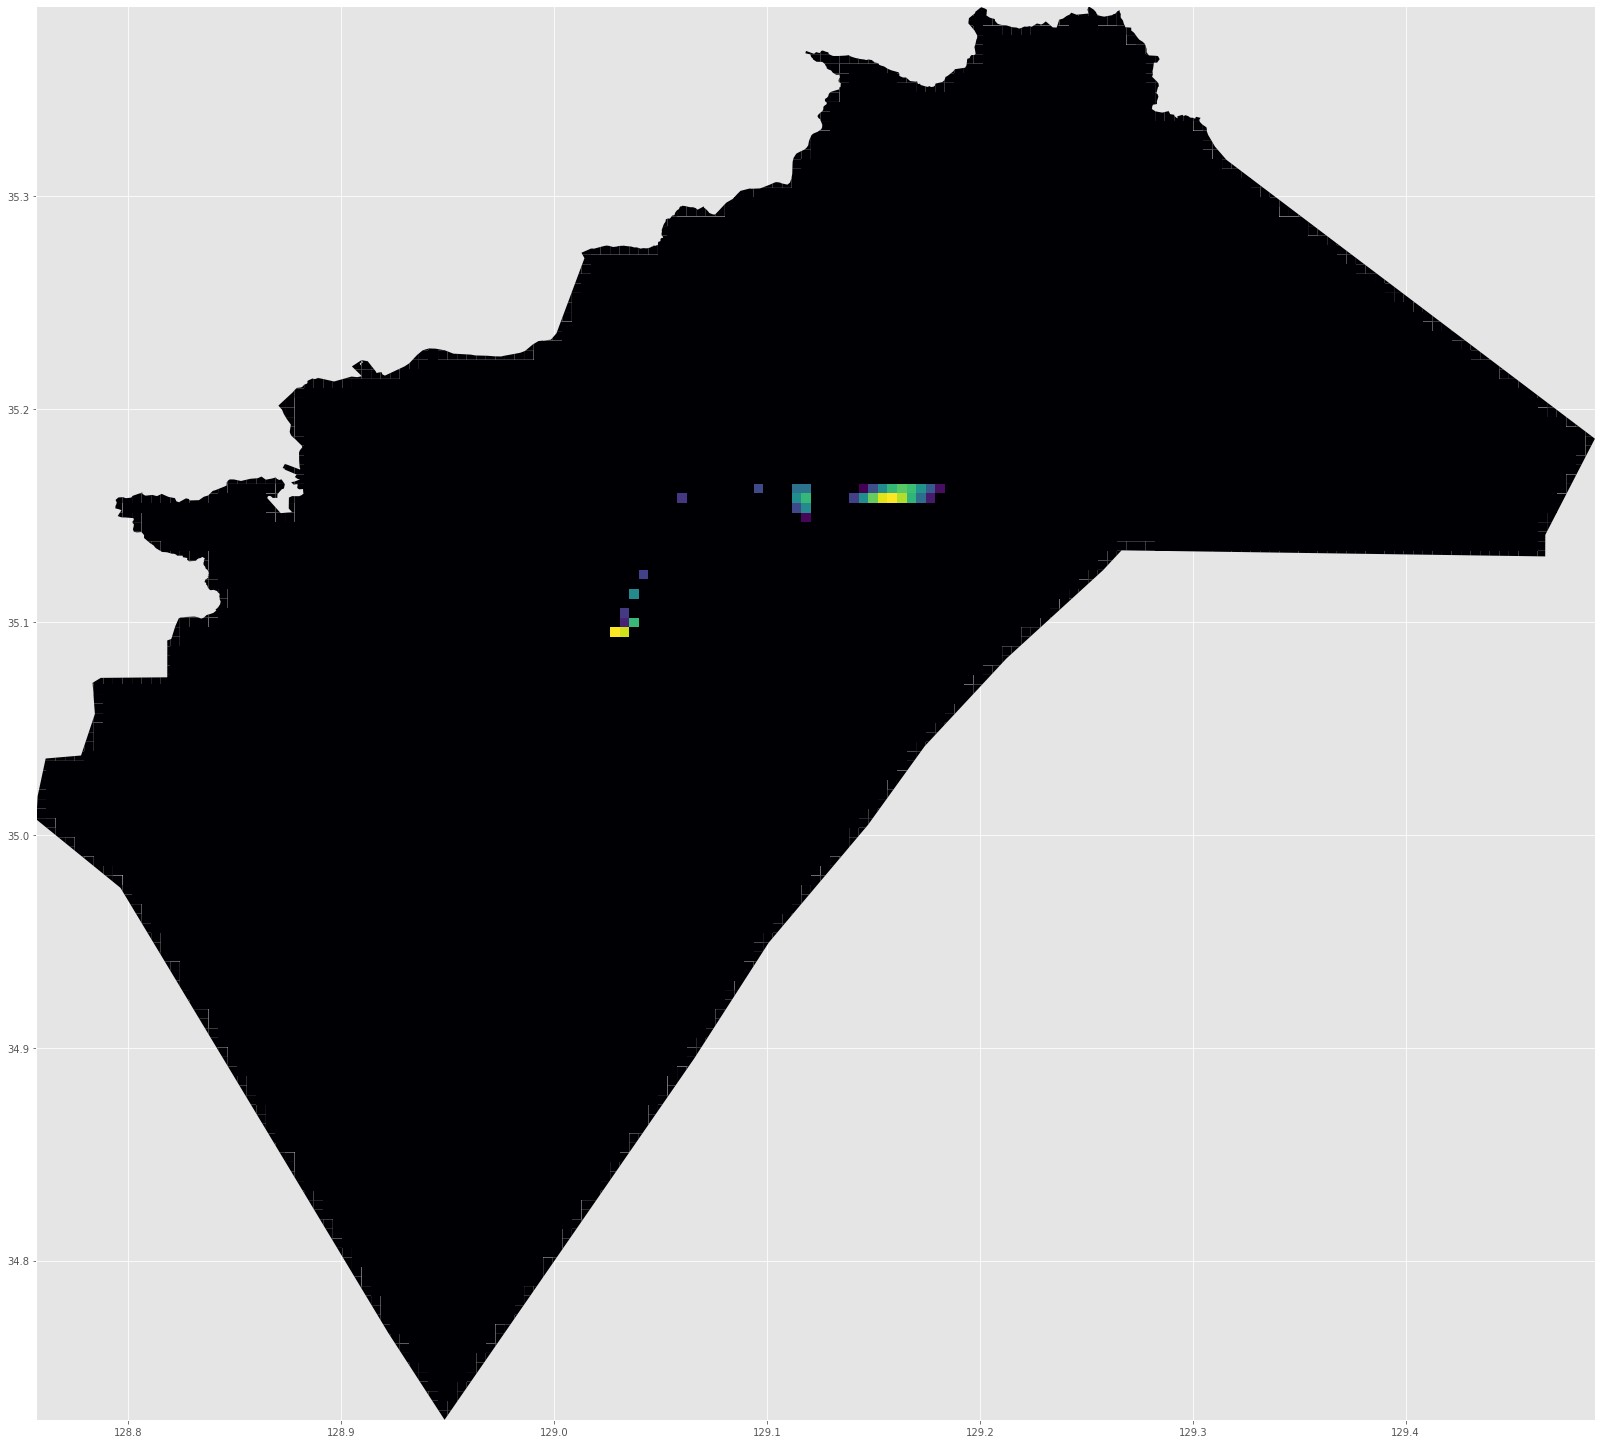

time: 3.19 s


In [20]:
# plot the city
west, south, east, north = city.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,26))

polyframe.plot(ax=ax, color='#000004')
#polyair.plot(column='prices',  legend=True, cmap='magma', ax=ax)    
poly_prices[poly_prices.index.isin(loubar_keys)].plot(ax=ax, column='zpred')
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()

In [21]:
lorentz_vals = poly_prices.zpred.to_dict()
s = [(k, lorentz_vals[k]) for k in sorted(lorentz_vals, key=lorentz_vals.get)]
keys = []
vals = []
for k,v in s:
    keys.append(k)
    vals.append(v)
    
print(len(keys))
vals = np.array(vals)
keys = np.array(keys)
keys = keys[vals>=0.01*vals.max()]
print(len(keys))

indlist = poly_prices.index.tolist()
mat = np.zeros(shape=(len(geometry_cut), len(geometry_cut)))
for pair in tqdm_notebook(combinations(sorted(keys), 2)):
    mat[pair[0], pair[1]] = geometry_cut[pair[0]].centroid.distance(geometry_cut[pair[1]].centroid)

print(mat)


def isuppertriangular(M): 
    for i in range(1, len(M)): 
        for j in range(0, i): 
            if(M[i][j] != 0):  
                    return False
    return True


if isuppertriangular(mat): 
    print ("Yes") 
else: 
    print ("No")

10286
157



[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Yes
time: 39.3 s


10286


10286 157
Number of cells with price above 1.0th percentile:  157
Loubar price:  18.19732982047378
Average price:  13.674168943558506
eta =  0.8918454596821997
10286 133
Number of cells with price above 2.0th percentile:  133
Loubar price:  20.993354115297155
Average price:  15.991867249797044
eta =  0.9482741712322014
10286 117
Number of cells with price above 3.0th percentile:  117
Loubar price:  25.066675178441102
Average price:  17.96041146930018
eta =  0.9932345857129818
10286 115
Number of cells with price above 4.0th percentile:  115
Loubar price:  25.066675178441102
Average price:  18.23603486811142
eta =  1.008005463447519
10286 106
Number of cells with price above 5.0th percentile:  106
Loubar price:  28.040443294248192
Average price:  19.549458331047354
eta =  0.9291921204613367
10286 100
Number of cells with price above 6.000000000000001th percentile:  100
Loubar price:  29.04652458253502
Average price:  20.515543206604658
eta =  0.9215912431377494
10286 95
Number of cells 

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning:

Mean of empty slice.

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning:

invalid value encountered in double_scalars



eta =  nan
10286 7
Number of cells with price above 80.0th percentile:  7
Loubar price:  62.997289127638766
Average price:  58.73106863478346
eta =  nan
10286 7
Number of cells with price above 81.0th percentile:  7
Loubar price:  62.997289127638766
Average price:  58.73106863478346
eta =  nan
10286 7
Number of cells with price above 82.0th percentile:  7
Loubar price:  62.997289127638766
Average price:  58.73106863478346
eta =  nan
10286 6
Number of cells with price above 83.0th percentile:  6
Loubar price:  62.997289127638766
Average price:  59.82155006763674
eta =  nan
10286 6
Number of cells with price above 84.00000000000001th percentile:  6
Loubar price:  62.997289127638766
Average price:  59.82155006763674
eta =  nan
10286 5
Number of cells with price above 85.0th percentile:  5
Loubar price:  62.997289127638766
Average price:  61.134028259967195
eta =  nan
10286 5
Number of cells with price above 86.0th percentile:  5
Loubar price:  62.997289127638766
Average price:  61.1340282

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning:

invalid value encountered in true_divide



Loubar price:  63.11418904570696
Average price:  63.11418904570696
eta =  nan



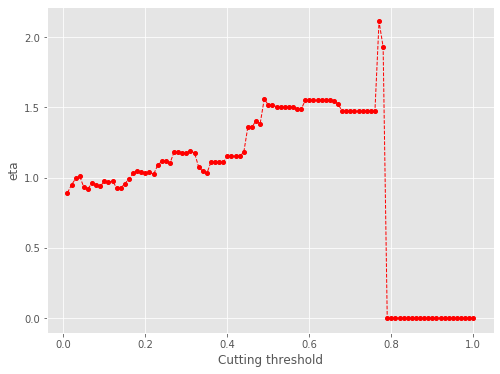

time: 1.65 s


In [22]:
from tqdm import tqdm_notebook

#poly_prices = polyair[polyair.median_prices>0]
poly_prices = polyair.copy()
print(len(poly_prices))
poly_prices['zpred'] = zpred

lorentz_vals = poly_prices.zpred.to_dict()
s = [(k, lorentz_vals[k]) for k in sorted(lorentz_vals, key=lorentz_vals.get)]
keys = []
vals = []
for k,v in s:
    keys.append(k)
    vals.append(v)
    

vals = np.array(vals)
keys_initial = np.array(keys)


perc_vals = np.linspace(0.01, 1, 100)
etas_cut = []
for i in tqdm_notebook(perc_vals):
    keys = keys_initial
    vals_cut = vals[vals>=i*vals.max()]
    print(len(vals), len(vals_cut))

    L = np.cumsum(vals_cut)/np.sum(vals_cut)
    keys = keys[vals>=i*vals.max()]
    print('Number of cells with price above {}th percentile: '.format(i*100), len(keys))
    
    
        
    L1= L
    F1 = np.arange(1, len(L1)+1)/len(L1)

    L1 = (L1 - L1.min())/(L1.max()-L1.min())
    

    loubar_val = vals_cut[np.where(tngnt1(F1)>0)[0][0]]

    print('Loubar price: ', loubar_val)
    print('Average price: ', np.mean(vals_cut))
    
    
    loubar_keys = keys[vals_cut>loubar_val]
    dist_mat = mat[keys.reshape(-1,1), keys]

    total_dist = dist_mat.sum()
    dist_corr = dist_mat[dist_mat>0]

    loubar_dist_mat = mat[loubar_keys.reshape(-1,1), loubar_keys]

    loubar_dist = loubar_dist_mat.sum()

    loubar_dist_corr = loubar_dist_mat[loubar_dist_mat>0]
    eta = loubar_dist_corr.mean()/dist_corr.mean()
    etas_cut.append(eta)
    print('eta = ', eta)
etas_cut = np.array(etas_cut)
etas_cut = np.where(np.isnan(etas_cut), 0, etas_cut)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(perc_vals, etas_cut, color='r', linestyle='--', marker='o', markersize=4, linewidth=1)
plt.xlabel("Cutting threshold")
plt.ylabel("eta")
plt.show()

In [23]:
pickle_in = open("etas_cut_dict.pickle","rb")
etas_cut_dict = pickle.load(pickle_in)
#etas_cut_dict = {}
etas_cut_dict['Busan'] = etas_cut


pickle_out = open("etas_cut_dict.pickle","wb")
pickle.dump(etas_cut_dict, pickle_out)
pickle_out.close()

etas_cut_dict

{'Boston': array([0.69697859, 0.70601119, 0.71142664, 0.72735905, 0.71723297,
        0.69152614, 0.68969459, 0.69338651, 0.68627389, 0.68571239,
        0.68565242, 0.66080855, 0.68568495, 0.66662135, 0.65169235,
        0.66853925, 0.64080339, 0.6392735 , 0.64870117, 0.66369008,
        0.64936606, 0.65513408, 0.65817401, 0.54708479, 0.54484174,
        0.5177247 , 0.54225619, 0.54660686, 0.55128317, 0.55836993,
        0.56571414, 0.52792612, 0.52759205, 0.55096732, 0.46941853,
        0.48021089, 0.47484233, 0.46129546, 0.46439344, 0.4699713 ,
        0.50255475, 0.51573036, 0.52765377, 0.52765377, 0.53943229,
        0.54404083, 0.54813213, 0.6100999 , 0.50092562, 0.52536404,
        0.56707558, 0.56150998, 0.61316219, 0.66467806, 0.74541769,
        0.74541769, 0.77652679, 0.74895419, 0.92876367, 0.92876367,
        0.90963119, 0.90963119, 1.05344906, 1.15130075, 1.15130075,
        1.22651104, 1.26738008, 0.62257449, 0.62257449, 0.64231201,
        0.64231201, 0.62403947, 0.6307

time: 25 ms


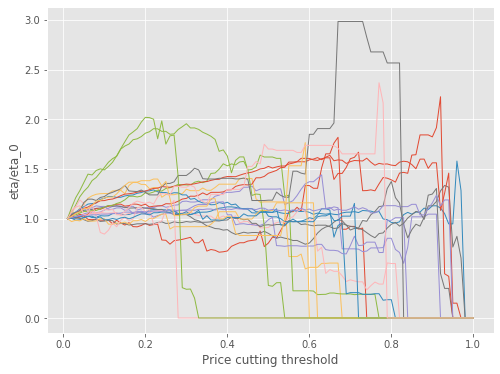

time: 214 ms


In [24]:
fig, ax = plt.subplots(figsize=(8, 6))
for key in etas_cut_dict:
    #print(len(etas_cut_dict[key]))
    etas = etas_cut_dict[key]#[1:]
    vals = etas/etas[0]
    plt.plot(np.linspace(0.01, 1, 100), vals, linestyle='-', linewidth=1)
plt.xlabel("Price cutting threshold")
plt.ylabel("eta/eta_0")
plt.show()

10286 133
Number of cells with price above 5th percentile:  133


eta =  1.0
eta =  1.0
eta =  1.0
eta =  0.9461080975475225
eta =  0.9371003701624062
eta =  0.9396690301554932
eta =  0.9096474723923681
eta =  0.8917011654816371
eta =  0.9020270800567394
eta =  0.9125244031599249
eta =  0.9062550411818955
eta =  0.9175055402936654
eta =  0.9288552145466583
eta =  0.91633449455145
eta =  0.897285980294559
eta =  0.9045307969251805
eta =  0.8725061293553521
eta =  0.8857721271803134
eta =  0.9001584726663394
eta =  0.9091974332239058
eta =  0.9177858714472049
eta =  0.9370450096228068
eta =  0.9405188009486897
eta =  0.9113508782723498
eta =  0.9280538015696383
eta =  0.9322574993417345
eta =  0.9272891067095979
eta =  0.9272891067095979
eta =  0.9272891067095979
eta =  0.9649323541382694
eta =  0.9649323541382694
eta =  0.9645531503231684
eta =  0.9645531503231684
eta =  0.9482741712322014
eta =  0.9639447961771229
eta =  0.9781486449647278
eta =  0.97713533068696
eta =  0.97713533068696
eta =  0.9787947474269754
eta =  0.9787947474269754
eta =  0.939

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning:

Mean of empty slice.



eta =  nan



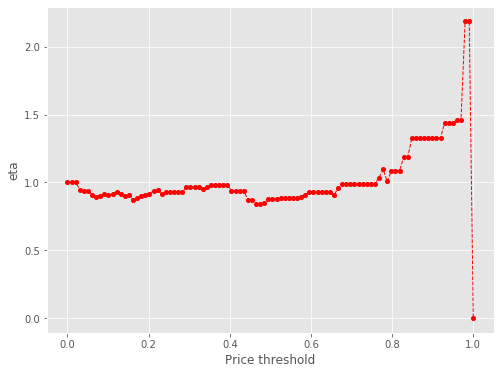

time: 624 ms


In [25]:
lval = np.linspace(0, max(vals_cut), 100)
etas = []

lorentz_vals = poly_prices.zpred.to_dict()
s = [(k, lorentz_vals[k]) for k in sorted(lorentz_vals, key=lorentz_vals.get)]
keys = []
vals = []
for k,v in s:
    keys.append(k)
    vals.append(v)
    

vals = np.array(vals)
keys = np.array(keys)
vals_cut = vals[vals>0.02*vals.max()]
print(len(vals), len(vals_cut))

L = np.cumsum(vals_cut)/np.sum(vals_cut)
keys = keys[vals>0.02*vals.max()]
print('Number of cells with price above 5th percentile: ', len(keys))

for i in tqdm_notebook(lval):
    loubar_keys = keys[vals_cut>=i]
    dist_mat = mat[keys.reshape(-1,1), keys]

    total_dist = dist_mat.sum()
    dist_corr = dist_mat[dist_mat>0]

    loubar_dist_mat = mat[loubar_keys.reshape(-1,1), loubar_keys]

    loubar_dist = loubar_dist_mat.sum()

    loubar_dist_corr = loubar_dist_mat[loubar_dist_mat>0]
    eta = loubar_dist_corr.mean()/dist_corr.mean()
    etas.append(eta)
    print('eta = ', eta)
etas = np.array(etas)
etas = np.where(np.isnan(etas), 0, etas)
lval = lval/lval.max()
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(lval, etas, color='r', linestyle='--', marker='o', markersize=4, linewidth=1)
plt.xlabel("Price threshold")
plt.ylabel("eta")
plt.show()

etas_cut_threshold = etas

In [26]:
pickle_in = open("etas_cut_threshold_dict.pickle","rb")
etas_cut_threshold_dict = pickle.load(pickle_in)
#etas_cut_threshold_dict = {}
etas_cut_threshold_dict['Busan'] = etas_cut_threshold


pickle_out = open("etas_cut_threshold_dict.pickle","wb")
pickle.dump(etas_cut_threshold_dict, pickle_out)
pickle_out.close()

etas_cut_threshold_dict

{'NY': array([1.        , 1.        , 1.        , 1.        , 1.        ,
        0.99991145, 0.98955316, 0.97868522, 0.96344498, 0.95205618,
        0.94615067, 0.93194961, 0.92540239, 0.92150344, 0.91822455,
        0.91569734, 0.91218202, 0.90337978, 0.898264  , 0.89376519,
        0.89441924, 0.88573077, 0.88617046, 0.87902683, 0.87195329,
        0.87101443, 0.87158631, 0.86935351, 0.86321974, 0.86053312,
        0.86079304, 0.86069179, 0.86140605, 0.85888874, 0.8617884 ,
        0.85709178, 0.8579834 , 0.85179248, 0.84947743, 0.84847717,
        0.84228408, 0.82983947, 0.82767187, 0.82334824, 0.81678545,
        0.81788964, 0.81304395, 0.807866  , 0.79902867, 0.79698224,
        0.78820712, 0.76853775, 0.76312442, 0.75071909, 0.7481045 ,
        0.73389742, 0.71700231, 0.70245218, 0.68328343, 0.67990807,
        0.66811743, 0.61552082, 0.58620924, 0.57826542, 0.57372339,
        0.55441141, 0.5326264 , 0.53706259, 0.53126932, 0.52772792,
        0.5331439 , 0.51700595, 0.49034259

time: 29 ms


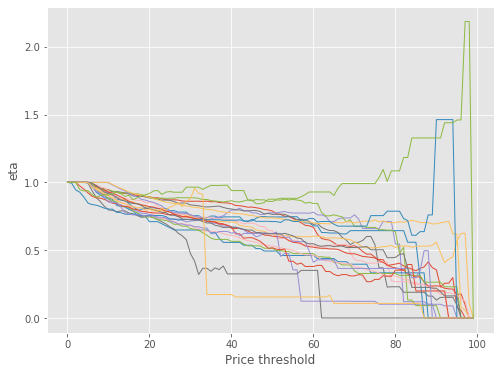

time: 201 ms


In [27]:
fig, ax = plt.subplots(figsize=(8, 6))
for key in etas_cut_threshold_dict:
    plt.plot(np.arange(100), etas_cut_threshold_dict[key], linestyle='-', linewidth=1)
plt.xlabel("Price threshold")
plt.ylabel("eta")
plt.show()

10286 157
Number of cells with price above 1.0th percentile:  157


eta =  1.0
eta =  0.937546894792893
eta =  0.8870207089940911
eta =  0.8740226897217122
eta =  0.880983781355332
eta =  0.8573787619880834
eta =  0.8360116587805125
eta =  0.8456926879262963
eta =  0.8512575228203324
eta =  0.8496565997504915
eta =  0.8543246386444425
eta =  0.8662006670891575
eta =  0.8594788964123578
eta =  0.8597792364472524
eta =  0.8480400399017438
eta =  0.8180154122648765
eta =  0.8227456752489233
eta =  0.8439407808698398
eta =  0.8524152302727415
eta =  0.8604672938601162
eta =  0.8696391552347045
eta =  0.8872459129660051
eta =  0.8544341859910174
eta =  0.8700939598623542
eta =  0.8700939598623542
eta =  0.8806108670605047
eta =  0.869377022570859
eta =  0.869377022570859
eta =  0.9046693323075307
eta =  0.9046693323075307
eta =  0.8920503684286628
eta =  0.9043138109481891
eta =  0.8791270626251846
eta =  0.9037434504076298
eta =  0.9170602247325564
eta =  0.916110195077986
eta =  0.916110195077986
eta =  0.9176659760897548
eta =  0.9176659760897548
eta =  

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning:

Mean of empty slice.



eta =  nan


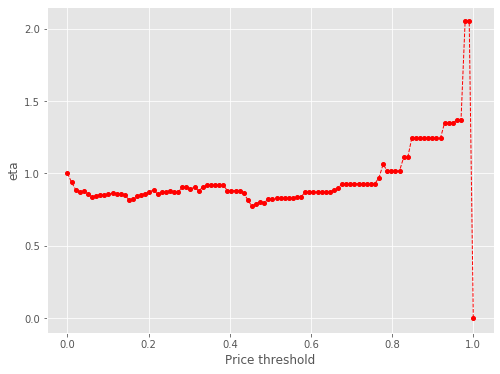

10286 133
Number of cells with price above 2.0th percentile:  133


eta =  1.0
eta =  0.9461080975475225
eta =  0.9322442371427048
eta =  0.9363394394360232
eta =  0.9144916022333806
eta =  0.8917011654816371
eta =  0.896234986130142
eta =  0.9079626070420486
eta =  0.9062550411818955
eta =  0.9112340336140364
eta =  0.934921392868091
eta =  0.9167316335704139
eta =  0.9170519802502042
eta =  0.9045307969251805
eta =  0.8725061293553521
eta =  0.8775514908304084
eta =  0.8931132144174063
eta =  0.9091974332239058
eta =  0.9177858714472049
eta =  0.9210218439467217
eta =  0.9370450096228068
eta =  0.9364344911103657
eta =  0.9280538015696383
eta =  0.9280538015696383
eta =  0.9392712748038426
eta =  0.9272891067095979
eta =  0.9272891067095979
eta =  0.9380698359191633
eta =  0.9649323541382694
eta =  0.9649323541382694
eta =  0.9645531503231684
eta =  0.9376886292385263
eta =  0.9639447961771229
eta =  0.9781486449647278
eta =  0.9781486449647278
eta =  0.97713533068696
eta =  0.97713533068696
eta =  0.9787947474269754
eta =  0.9787947474269754
eta =  

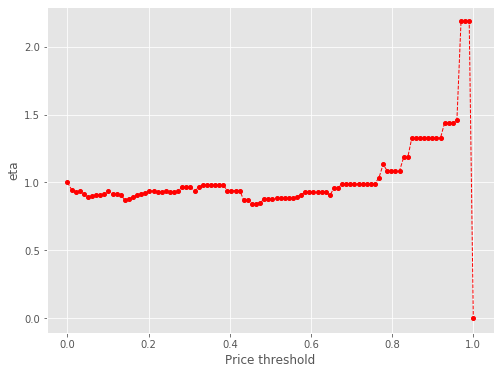

10286 117
Number of cells with price above 3.0th percentile:  117


eta =  1.0
eta =  0.9904791773704656
eta =  0.9931941525405813
eta =  0.9665825761389238
eta =  0.942493957924134
eta =  0.9534080538946355
eta =  0.9596816784420791
eta =  0.9578768467694833
eta =  0.9631394509529242
eta =  0.9881760818785619
eta =  0.9689502034141156
eta =  0.9692887975775318
eta =  0.9560543866709125
eta =  0.9222055403785682
eta =  0.923808266158468
eta =  0.9439864395331906
eta =  0.9514330074964029
eta =  0.9700644924467577
eta =  0.9734847913617601
eta =  0.9904206634017733
eta =  0.989775368731932
eta =  0.9809173010730128
eta =  0.9809173010730128
eta =  0.9853604485135566
eta =  0.9801090479124883
eta =  0.9801090479124883
eta =  0.9801090479124883
eta =  1.0198965177864376
eta =  1.0198965177864376
eta =  1.0194957138866676
eta =  1.0194957138866676
eta =  1.0188527068691584
eta =  1.0188527068691584
eta =  1.0338656306824345
eta =  1.0327945963255842
eta =  1.0327945963255842
eta =  1.034548536223485
eta =  1.034548536223485
eta =  0.9932345857129818
eta = 

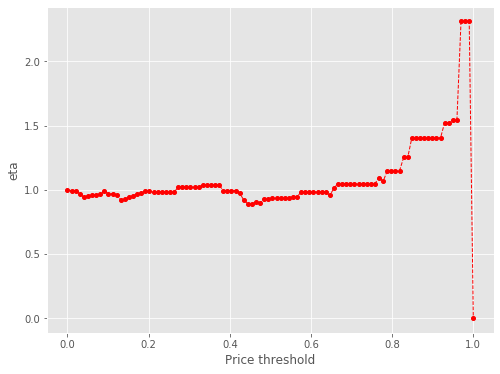

10286 115
Number of cells with price above 4.0th percentile:  115


eta =  1.0
eta =  1.004392842701683
eta =  0.9809570987923343
eta =  0.9565102469441584
eta =  0.9613735869015079
eta =  0.9739535744676969
eta =  0.9721219022597927
eta =  0.9721219022597927
eta =  0.9914965198038608
eta =  0.9833599362117416
eta =  0.9837035657747113
eta =  0.9702723394649614
eta =  0.9702723394649614
eta =  0.944809030085172
eta =  0.9580249239778262
eta =  0.9655822334984799
eta =  0.9844907963820573
eta =  0.987961960236537
eta =  1.0051496939201428
eta =  1.008875961337499
eta =  0.9775881061658345
eta =  0.9955050024380844
eta =  1.000014226099236
eta =  0.9946847293491519
eta =  0.9946847293491519
eta =  0.9946847293491519
eta =  1.0350638981644473
eta =  1.0350638981644473
eta =  1.0346571337136814
eta =  1.0346571337136814
eta =  1.0058400919833073
eta =  1.0340045642240485
eta =  1.0492407525765117
eta =  1.0481537903434457
eta =  1.0481537903434457
eta =  1.0499338139401604
eta =  1.0499338139401604
eta =  1.008005463447519
eta =  1.008005463447519
eta =  1

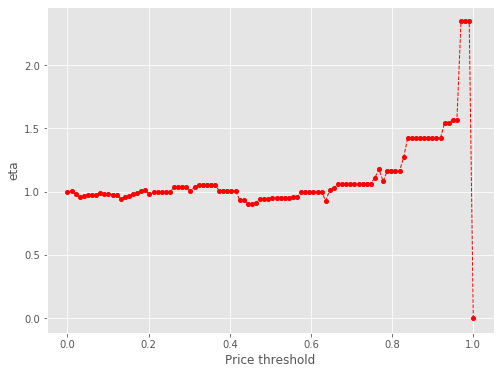

10286 106
Number of cells with price above 5.0th percentile:  106


eta =  1.0
eta =  0.9766667553640568
eta =  0.9523268250013344
eta =  0.957168894508986
eta =  0.969693861863742
eta =  0.9643096603482599
eta =  0.9678702007124167
eta =  0.9871600808473179
eta =  0.9790590836615624
eta =  0.9794012103159553
eta =  0.9582913444669308
eta =  0.9660287272209727
eta =  0.940676784935824
eta =  0.9538348773980375
eta =  0.9613591340428037
eta =  0.971012642350657
eta =  0.9836409801358709
eta =  1.0007535410312403
eta =  1.0044635111335092
eta =  0.9733124974648889
eta =  0.991151031861506
eta =  0.991151031861506
eta =  1.0031311672288261
eta =  0.9903343463435904
eta =  0.9903343463435904
eta =  1.030536911613451
eta =  1.030536911613451
eta =  1.0161622582466567
eta =  1.0301319261999033
eta =  1.0014409195487008
eta =  1.029482210807789
eta =  1.0446517617092868
eta =  1.0446517617092868
eta =  1.0435695534468878
eta =  1.0435695534468878
eta =  1.0453417918789407
eta =  1.0453417918789407
eta =  1.0035968204792445
eta =  1.0035968204792445
eta =  1.0

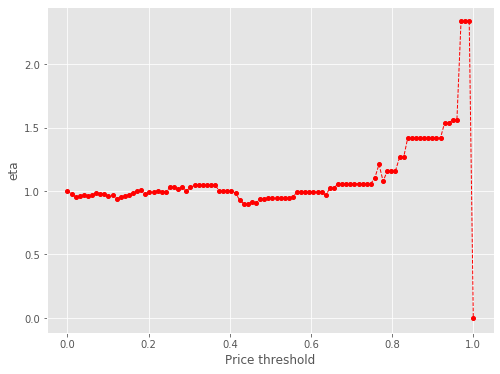

10286 100
Number of cells with price above 6.000000000000001th percentile:  100


eta =  1.0
eta =  0.9750785718577575
eta =  0.9800363217566437
eta =  0.9928605192487424
eta =  0.9909932895705443
eta =  0.9909932895705443
eta =  1.0107440182904042
eta =  1.0024494826760166
eta =  1.0027997829729336
eta =  0.9811855878208157
eta =  0.9891078220030958
eta =  0.9631502042732913
eta =  0.9766226526697854
eta =  0.9843266690125567
eta =  0.9942108063140818
eta =  1.007140843827754
eta =  1.0246622356447517
eta =  1.0284608395000514
eta =  0.9965656065584851
eta =  1.0148303158860466
eta =  1.0148303158860466
eta =  1.0270966649775077
eta =  1.0139941191859643
eta =  1.0139941191859643
eta =  1.0402000833496217
eta =  1.0551571515601696
eta =  1.0551571515601696
eta =  1.0547424907648435
eta =  1.0547424907648435
eta =  1.0540772532224105
eta =  1.0540772532224105
eta =  1.0696092151922263
eta =  1.0685011522255539
eta =  1.0685011522255539
eta =  1.0703157306601319
eta =  1.0703157306601319
eta =  1.027573443006309
eta =  1.027573443006309
eta =  1.027573443006309
eta =

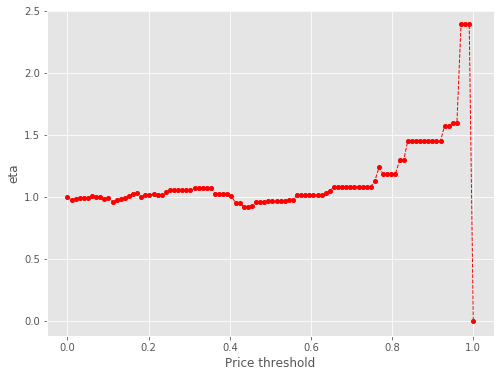

10286 95
Number of cells with price above 6.999999999999999th percentile:  95


eta =  1.0
eta =  1.0181322961949104
eta =  1.0233522602463354
eta =  1.016321472107079
eta =  1.0219051728185742
eta =  1.0420318068256935
eta =  1.0280704669431007
eta =  1.028429720347931
eta =  1.0143878150440833
eta =  1.0143878150440833
eta =  0.9877667626704791
eta =  1.0015835450153376
eta =  1.0094844635311586
eta =  1.0196212233644646
eta =  1.0328817316833354
eta =  1.050850941881048
eta =  1.0547466318950973
eta =  1.0220362084870656
eta =  1.040767734186336
eta =  1.040767734186336
eta =  1.0533475912824577
eta =  1.0399101656536902
eta =  1.0399101656536902
eta =  1.0399101656536902
eta =  1.0821252584290137
eta =  1.0821252584290137
eta =  1.081699999575734
eta =  1.081699999575734
eta =  1.0810177596397608
eta =  1.0810177596397608
eta =  1.0969466933873495
eta =  1.09581031012691
eta =  1.09581031012691
eta =  1.0976712662456778
eta =  1.0976712662456778
eta =  1.053836554985037
eta =  1.053836554985037
eta =  1.053836554985037
eta =  1.053836554985037
eta =  1.0538365

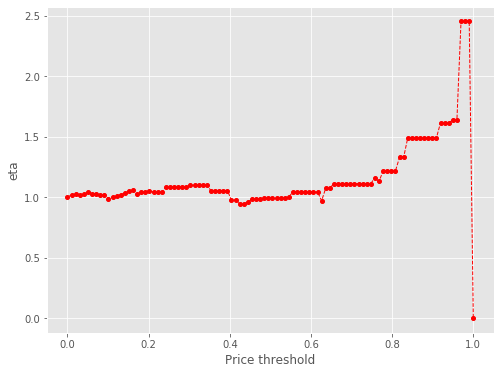

10286 92
Number of cells with price above 8.0th percentile:  92


eta =  1.0
eta =  1.011637481108134
eta =  1.0046871776010209
eta =  1.0046871776010209
eta =  1.0301031944151386
eta =  1.016301676345182
eta =  1.0166568172127601
eta =  0.9947439496363212
eta =  1.002775655990598
eta =  0.976459346921033
eta =  0.98197952895671
eta =  0.9979284353743767
eta =  1.007949155103764
eta =  1.0174704193908173
eta =  1.0283158027144905
eta =  1.0491351357685266
eta =  1.0103364947924003
eta =  1.0288535921906712
eta =  1.0288535921906712
eta =  1.0412894419364445
eta =  1.0280058406353714
eta =  1.0280058406353714
eta =  1.0280058406353714
eta =  1.069737678027996
eta =  1.069737678027996
eta =  1.0693172873063812
eta =  1.0693172873063812
eta =  1.0395348986413397
eta =  1.0686428572815008
eta =  1.0843894452738605
eta =  1.0832660707098685
eta =  1.0832660707098685
eta =  1.0832660707098685
eta =  1.0851057236168644
eta =  1.0851057236168644
eta =  1.0417728082489512
eta =  1.0417728082489512
eta =  1.0417728082489512
eta =  1.0417728082489512
eta =  1.0

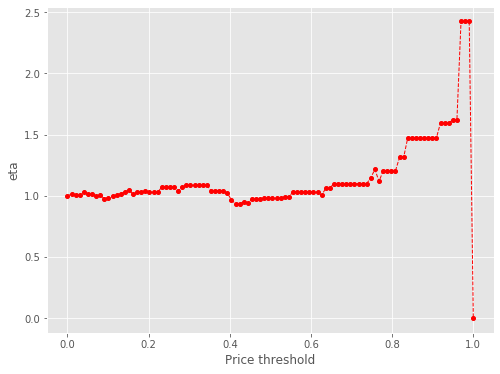

10286 90
Number of cells with price above 9.0th percentile:  90


eta =  1.0
eta =  0.9981193434102799
eta =  0.9981193434102799
eta =  1.0180120960547343
eta =  1.0096579159321692
eta =  1.010010735175281
eta =  0.9882411162478686
eta =  0.9962203177859402
eta =  0.9700760435132101
eta =  0.9755601390523921
eta =  0.9914047843873952
eta =  1.0013599967358568
eta =  1.010819018678708
eta =  1.0143830118150101
eta =  1.0320303967973996
eta =  1.0313579918902966
eta =  1.0221277774786812
eta =  1.0221277774786812
eta =  1.026757591239174
eta =  1.0212855678390886
eta =  1.0212855678390886
eta =  1.0212855678390886
eta =  1.0627445961478703
eta =  1.0627445961478703
eta =  1.0623269536016244
eta =  1.0623269536016244
eta =  1.0327392581653982
eta =  1.0616569324561203
eta =  1.0773005819604515
eta =  1.0773005819604515
eta =  1.0761845511130261
eta =  1.0761845511130261
eta =  1.0780121778535385
eta =  1.0780121778535385
eta =  1.034962538125529
eta =  1.034962538125529
eta =  1.034962538125529
eta =  1.034962538125529
eta =  1.034962538125529
eta =  0.

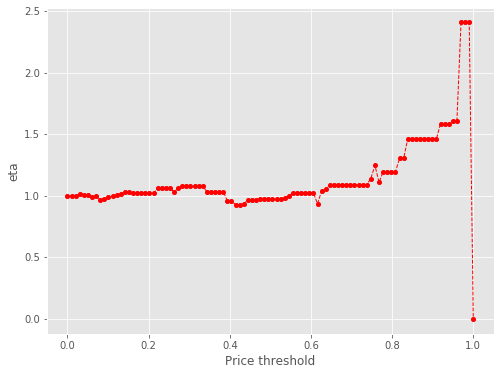

10286 85
Number of cells with price above 10.0th percentile:  85


eta =  1.0
eta =  1.0252974432049644
eta =  1.0115603135016555
eta =  1.0119137975268284
eta =  0.9901031602807533
eta =  0.9980973962313453
eta =  0.9627600285869532
eta =  0.9773982895864842
eta =  0.993272789404178
eta =  1.0032467593649719
eta =  1.0127236039981322
eta =  1.0162943124107404
eta =  1.033974948598086
eta =  1.0378080763248598
eta =  1.0142178300449851
eta =  1.0240536707628285
eta =  1.0286922080189786
eta =  1.036431503408675
eta =  1.0232098742317293
eta =  1.0232098742317293
eta =  1.064747019646754
eta =  1.064747019646754
eta =  1.064747019646754
eta =  1.064328590178371
eta =  1.064328590178371
eta =  1.0636573065789419
eta =  1.0636573065789419
eta =  1.0793304318495949
eta =  1.0782122981767095
eta =  1.0782122981767095
eta =  1.0782122981767095
eta =  1.0800433685317514
eta =  1.0800433685317514
eta =  1.036912614667267
eta =  1.036912614667267
eta =  1.036912614667267
eta =  1.036912614667267
eta =  1.0156496600881892
eta =  0.9600379470071396
eta =  0.9600

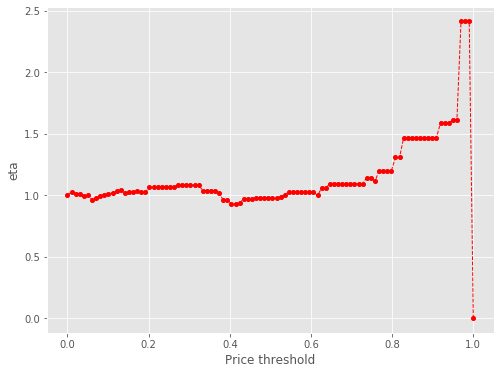

10286 84
Number of cells with price above 11.0th percentile:  84


eta =  1.0
eta =  1.0259948140436637
eta =  1.0060331372112754
eta =  1.0063846897959827
eta =  0.9846932261033334
eta =  0.9926437814638349
eta =  0.9665933679013132
eta =  0.9720577749573961
eta =  0.9878455363395829
eta =  0.9977650084226405
eta =  1.0071900714761315
eta =  1.010741269500071
eta =  1.0283252985036144
eta =  1.0276553076012558
eta =  1.0184582306357601
eta =  1.0184582306357601
eta =  1.023071422875106
eta =  1.0176190446178635
eta =  1.0176190446178635
eta =  1.0176190446178635
eta =  1.0589292306294362
eta =  1.0589292306294362
eta =  1.0589292306294362
eta =  1.05851308746411
eta =  1.05851308746411
eta =  1.0578454717653936
eta =  1.0578454717653936
eta =  1.0734329589132023
eta =  1.0723209347345741
eta =  1.0723209347345741
eta =  1.0741420001017599
eta =  1.0741420001017599
eta =  1.031246913134211
eta =  1.031246913134211
eta =  1.031246913134211
eta =  1.031246913134211
eta =  1.031246913134211
eta =  1.0101001395646532
eta =  0.9547922894741799
eta =  0.924

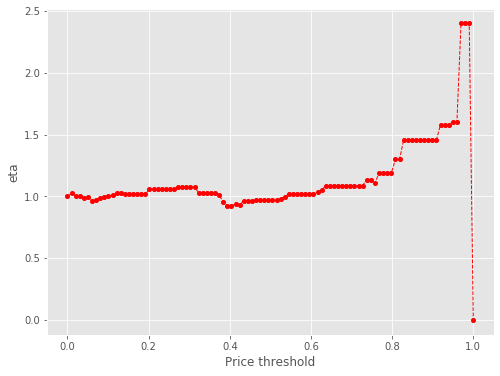

10286 78
Number of cells with price above 12.0th percentile:  78


eta =  1.0
eta =  0.9805440762865894
eta =  0.9808867218632487
eta =  0.9674939559895188
eta =  0.9674939559895188
eta =  0.9421035610226558
eta =  0.9474295207461232
eta =  0.9628172801831947
eta =  0.9724854304967063
eta =  0.9816716982287474
eta =  0.985132922374651
eta =  1.0022714388299545
eta =  1.0016184229538625
eta =  0.9926543650077525
eta =  0.9926543650077525
eta =  0.9971506764668371
eta =  1.0046526713036348
eta =  0.9918364407781072
eta =  0.9918364407781072
eta =  1.0320999834842934
eta =  1.0320999834842934
eta =  1.0320999834842934
eta =  1.0316943838071508
eta =  1.0316943838071508
eta =  1.0142822471129338
eta =  1.0310436829560568
eta =  1.0462362423476341
eta =  1.0451523926405917
eta =  1.0451523926405917
eta =  1.0451523926405917
eta =  1.0469273191239026
eta =  1.0469273191239026
eta =  1.0051190308358846
eta =  1.0051190308358846
eta =  1.0051190308358846
eta =  1.0051190308358846
eta =  0.9845080362381498
eta =  0.930601477127492
eta =  0.930601477127492
eta 

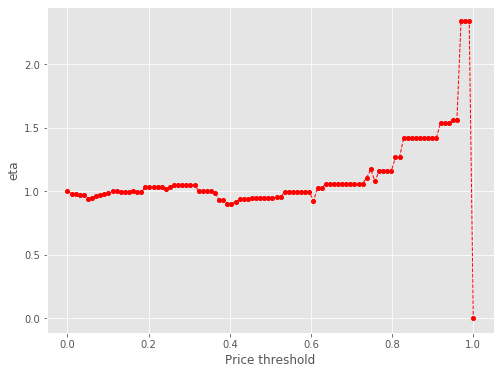

10286 70
Number of cells with price above 13.0th percentile:  70


eta =  1.0
eta =  1.0003494443390621
eta =  0.9866909396398654
eta =  0.9753008857142711
eta =  0.9607967492807551
eta =  0.9742362777850041
eta =  0.9819214693840916
eta =  0.9917814548221005
eta =  1.001149996180109
eta =  1.0046798978230944
eta =  1.0221584761652416
eta =  1.021492503169346
eta =  1.0123505806766238
eta =  1.0123505806766238
eta =  1.0169361078016386
eta =  1.0115164272209802
eta =  1.0115164272209802
eta =  1.0115164272209802
eta =  1.0525788778337748
eta =  1.0525788778337748
eta =  1.0525788778337748
eta =  1.0521652302610123
eta =  1.0521652302610123
eta =  1.0344076025160582
eta =  1.0515016182247656
eta =  1.0669956278863333
eta =  1.0658902724686075
eta =  1.0658902724686075
eta =  1.0658902724686075
eta =  1.0677004169855502
eta =  1.0677004169855502
eta =  1.0250625699992628
eta =  1.0250625699992628
eta =  1.0250625699992628
eta =  1.0250625699992628
eta =  1.0250625699992628
eta =  0.9490664414105333
eta =  0.9490664414105333
eta =  0.9193393373575116
eta

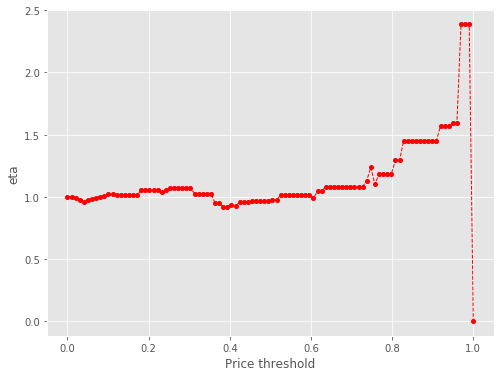

10286 68
Number of cells with price above 14.000000000000002th percentile:  68


eta =  1.0
eta =  0.9863462665206747
eta =  0.9514249444369571
eta =  0.9445441611111244
eta =  0.9738959553565693
eta =  0.9815784623470791
eta =  0.991435003472589
eta =  1.0008002721904603
eta =  1.0114679656933736
eta =  1.0218014134456672
eta =  1.0211356730889707
eta =  1.0119969440733692
eta =  1.0119969440733692
eta =  1.0165808693716378
eta =  1.0111630820061046
eta =  1.0111630820061046
eta =  1.0111630820061046
eta =  1.052211188590424
eta =  1.052211188590424
eta =  1.052211188590424
eta =  1.0517976855139708
eta =  1.0517976855139708
eta =  1.0225032489245502
eta =  1.051134305292187
eta =  1.0666229025511227
eta =  1.065517933258661
eta =  1.065517933258661
eta =  1.065517933258661
eta =  1.0673274454518114
eta =  1.0673274454518114
eta =  1.024704492815037
eta =  1.024704492815037
eta =  1.024704492815037
eta =  1.024704492815037
eta =  1.024704492815037
eta =  0.9487349113664857
eta =  0.9487349113664857
eta =  0.9190181916529434
eta =  0.9190181916529434
eta =  0.93291

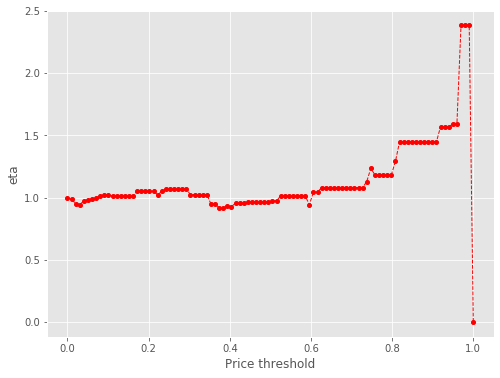

10286 66
Number of cells with price above 15.000000000000002th percentile:  66


eta =  1.0
eta =  0.973756533764705
eta =  0.9792614360852783
eta =  0.9951661963598099
eta =  1.0051591790070487
eta =  1.014654088691157
eta =  1.0182316036972983
eta =  1.0359459432538434
eta =  1.0397863778058691
eta =  1.0075399106037664
eta =  1.0260057531754816
eta =  1.0260057531754816
eta =  1.0384071808243096
eta =  1.0251603481736398
eta =  1.0251603481736398
eta =  1.0251603481736398
eta =  1.06677667296505
eta =  1.06677667296505
eta =  1.0518965219283964
eta =  1.0663574458736231
eta =  1.03665749405776
eta =  1.0656848826528755
eta =  1.0656848826528755
eta =  1.081387884514049
eta =  1.0802676194205747
eta =  1.0802676194205747
eta =  1.0802676194205747
eta =  1.0821021802179034
eta =  1.0821021802179034
eta =  1.0388892091918902
eta =  1.0388892091918902
eta =  1.0388892091918902
eta =  1.0388892091918902
eta =  1.0388892091918902
eta =  0.9618680006902012
eta =  0.9618680006902012
eta =  0.9317399201953384
eta =  0.9317399201953384
eta =  0.9458310544961265
eta =  0.9

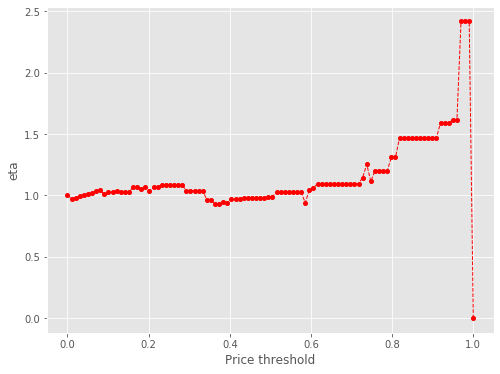

10286 64
Number of cells with price above 16.0th percentile:  64


eta =  1.0
eta =  1.0152044752221545
eta =  1.0316930075109252
eta =  1.0420527749136421
eta =  1.0518961879675361
eta =  1.0556050129151704
eta =  1.0739695437041101
eta =  1.0779509384576913
eta =  1.0445208894356972
eta =  1.0636645065809767
eta =  1.0636645065809767
eta =  1.0684824644504556
eta =  1.062788071637642
eta =  1.062788071637642
eta =  1.062788071637642
eta =  1.1059318916776046
eta =  1.1059318916776046
eta =  1.1059318916776046
eta =  1.1054972771776685
eta =  1.1054972771776685
eta =  1.0747072114339575
eta =  1.1048000280402959
eta =  1.1210793965280557
eta =  1.1199180129644624
eta =  1.1199180129644624
eta =  1.1199180129644624
eta =  1.1218199099072854
eta =  1.1218199099072854
eta =  1.0770208399585801
eta =  1.0770208399585801
eta =  1.0770208399585801
eta =  1.0770208399585801
eta =  1.0770208399585801
eta =  1.0549354251639034
eta =  0.99717262713554
eta =  0.99717262713554
eta =  0.9659387185783828
eta =  0.9659387185783828
eta =  0.9805470571445414
eta =  0

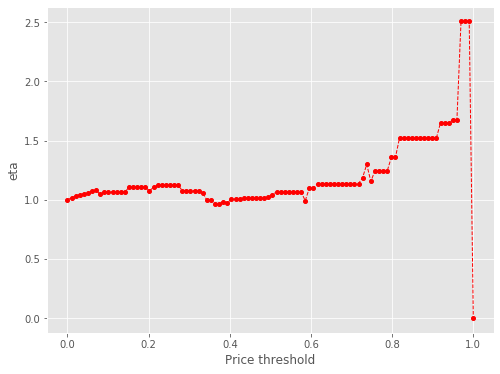

10286 60
Number of cells with price above 17.0th percentile:  60


eta =  1.0
eta =  1.0177331173721467
eta =  1.0257614306079506
eta =  1.0458484556601044
eta =  1.049535957229334
eta =  1.0677949036769352
eta =  1.0717534079495399
eta =  1.0670991969077936
eta =  1.0575491139459414
eta =  1.0575491139459414
eta =  1.0623393716299872
eta =  1.056677717944646
eta =  1.056677717944646
eta =  1.056677717944646
eta =  1.0689627283653609
eta =  1.0995734885313388
eta =  1.0995734885313388
eta =  1.0991413727876322
eta =  1.0991413727876322
eta =  1.068528330287732
eta =  1.0984481323881776
eta =  1.1146339048881637
eta =  1.1146339048881637
eta =  1.1134791985394699
eta =  1.1134791985394699
eta =  1.1153701607876738
eta =  1.1153701607876738
eta =  1.1153701607876738
eta =  1.0708286569236933
eta =  1.0708286569236933
eta =  1.0708286569236933
eta =  1.0708286569236933
eta =  1.0708286569236933
eta =  0.9914395204067604
eta =  0.9914395204067604
eta =  0.9603851869065615
eta =  0.9603851869065615
eta =  0.9749095368414131
eta =  0.9703335219140602
eta = 

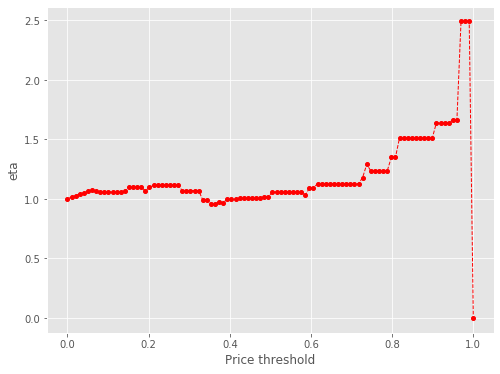

10286 57
Number of cells with price above 18.000000000000004th percentile:  57


eta =  1.0
eta =  1.0195825505354092
eta =  1.023177442543626
eta =  1.0409778256568607
eta =  1.0448369142855476
eta =  1.0402995911781776
eta =  1.0309893532642878
eta =  1.0309893532642878
eta =  1.0356593062778328
eta =  1.0434510181542236
eta =  1.0301398418912786
eta =  1.0301398418912786
eta =  1.0301398418912786
eta =  1.0719583089409408
eta =  1.0719583089409408
eta =  1.071537045544977
eta =  1.071537045544977
eta =  1.0416928326642525
eta =  1.0708612154944712
eta =  1.0708612154944712
eta =  1.0866404912763585
eta =  1.085514784738524
eta =  1.085514784738524
eta =  1.085514784738524
eta =  1.0873582565164435
eta =  1.0873582565164435
eta =  1.043935387869899
eta =  1.043935387869899
eta =  1.043935387869899
eta =  1.043935387869899
eta =  1.043935387869899
eta =  1.0225284241375767
eta =  0.9665400655775797
eta =  0.9665400655775797
eta =  0.9362656444757903
eta =  0.9362656444757903
eta =  0.9504252234007294
eta =  0.9459641325556185
eta =  0.9727894528748205
eta =  0.972

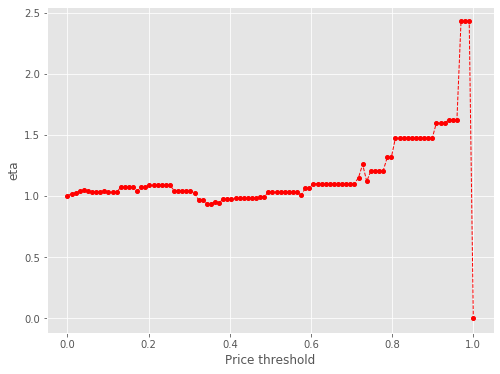

10286 56
Number of cells with price above 19.0th percentile:  56


eta =  1.0
eta =  1.0094461751754462
eta =  1.0202060267699018
eta =  1.0306287450682265
eta =  1.0299572533876176
eta =  1.0023685120192303
eta =  1.020739574988537
eta =  1.020739574988537
eta =  1.0330773498483148
eta =  1.0198985091956774
eta =  1.0198985091956774
eta =  1.0198985091956774
eta =  1.061301229939392
eta =  1.061301229939392
eta =  1.061301229939392
eta =  1.060884154614227
eta =  1.060884154614227
eta =  1.0313366436964015
eta =  1.0602150434577116
eta =  1.0758374465448381
eta =  1.0758374465448381
eta =  1.074722931434325
eta =  1.074722931434325
eta =  1.0765480759842072
eta =  1.0765480759842072
eta =  1.0335569041096178
eta =  1.0335569041096178
eta =  1.0335569041096178
eta =  1.0335569041096178
eta =  1.0335569041096178
eta =  1.0335569041096178
eta =  0.9569310222490205
eta =  0.9569310222490205
eta =  0.9269575801076225
eta =  0.9269575801076225
eta =  0.940976388864568
eta =  0.9365596488091967
eta =  0.9631182800645618
eta =  0.9631182800645618
eta =  0.96

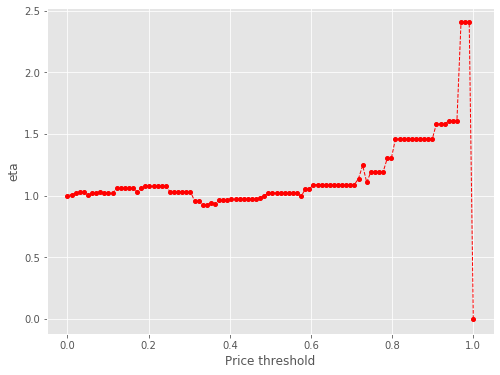

10286 55
Number of cells with price above 20.0th percentile:  55


eta =  1.0
eta =  1.010659163270974
eta =  1.0209843480650156
eta =  1.0203191400557898
eta =  0.9929885680581374
eta =  1.0111877186627884
eta =  1.0111877186627884
eta =  1.0234100393403949
eta =  1.0103545233785391
eta =  1.0103545233785391
eta =  1.0103545233785391
eta =  1.0513698065723347
eta =  1.0513698065723347
eta =  1.0513698065723347
eta =  1.0509566341462837
eta =  1.0509566341462837
eta =  1.0216856223336035
eta =  1.0502937843847309
eta =  1.0657699964615277
eta =  1.0657699964615277
eta =  1.0646659107381662
eta =  1.0646659107381662
eta =  1.0664739759869795
eta =  1.0664739759869795
eta =  1.0664739759869795
eta =  1.0238851060384482
eta =  1.0238851060384482
eta =  1.0238851060384482
eta =  1.0238851060384482
eta =  1.0238851060384482
eta =  1.0028892938591587
eta =  0.9479762723185331
eta =  0.9182833150529429
eta =  0.9182833150529429
eta =  0.9182833150529429
eta =  0.9321709388824244
eta =  0.9277955297085735
eta =  0.9541056311369623
eta =  0.9541056311369623
et

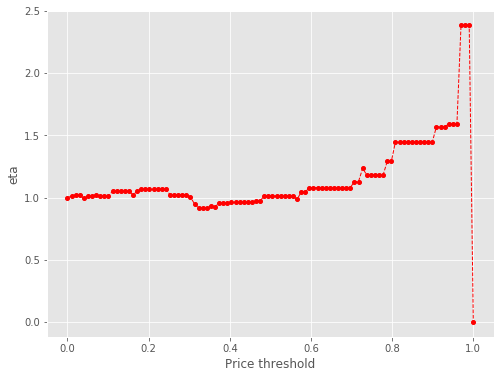

10286 53
Number of cells with price above 21.000000000000004th percentile:  53


eta =  1.0
eta =  1.0173971614043629
eta =  1.0211688323464951
eta =  0.9894997434230981
eta =  1.007634952058014
eta =  1.007634952058014
eta =  1.0198143301128662
eta =  1.0068046841712461
eta =  1.0068046841712461
eta =  1.0068046841712461
eta =  1.047675861848601
eta =  1.047675861848601
eta =  1.047675861848601
eta =  1.0472641410869348
eta =  1.0472641410869348
eta =  1.0180959717745506
eta =  1.0466036202208513
eta =  1.0620254572608276
eta =  1.0620254572608276
eta =  1.060925250697403
eta =  1.060925250697403
eta =  1.060925250697403
eta =  1.06272696338307
eta =  1.06272696338307
eta =  1.0202877276835467
eta =  1.0202877276835467
eta =  1.0202877276835467
eta =  1.0202877276835467
eta =  1.0202877276835467
eta =  0.9993656834298107
eta =  0.9446455965396916
eta =  0.9446455965396916
eta =  0.9150569642624525
eta =  0.9150569642624525
eta =  0.9288957944948101
eta =  0.9245357581417601
eta =  0.9507534201071315
eta =  0.9507534201071315
eta =  0.9507534201071315
eta =  0.9580

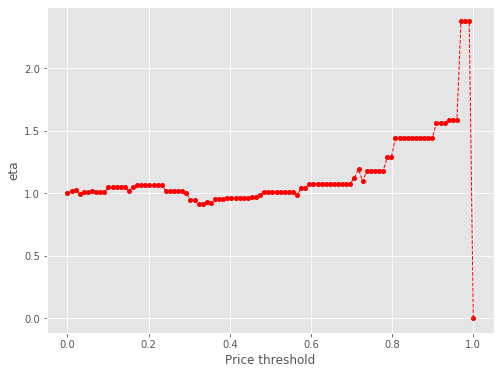

10286 51
Number of cells with price above 22.0th percentile:  51


eta =  1.0
eta =  0.9993484640479684
eta =  0.9904047212664975
eta =  0.9904047212664975
eta =  0.9904047212664975
eta =  1.002375835907746
eta =  0.9895886506912448
eta =  0.9895886506912448
eta =  0.9895886506912448
eta =  1.0297609444894096
eta =  1.0297609444894096
eta =  1.0297609444894096
eta =  1.0293562640192007
eta =  1.0293562640192007
eta =  1.0006868609395598
eta =  1.0287070378456467
eta =  1.0438651664752652
eta =  1.0438651664752652
eta =  1.0427837730871552
eta =  1.0427837730871552
eta =  1.0427837730871552
eta =  1.0445546770703942
eta =  1.0445546770703942
eta =  1.0028411385335436
eta =  1.0028411385335436
eta =  1.0028411385335436
eta =  1.0028411385335436
eta =  1.0028411385335436
eta =  0.9822768544491883
eta =  0.928492463293048
eta =  0.928492463293048
eta =  0.899409787028848
eta =  0.899409787028848
eta =  0.9130119777537122
eta =  0.9087264966078521
eta =  0.9344958450589347
eta =  0.9344958450589347
eta =  0.9344958450589347
eta =  0.9416981569421584
eta = 

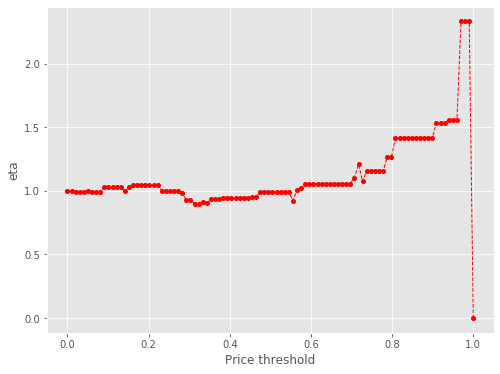

10286 47
Number of cells with price above 23.0th percentile:  47


eta =  1.0
eta =  1.0183276537012314
eta =  1.0183276537012314
eta =  1.0306362754424747
eta =  1.0174885752757075
eta =  1.0174885752757075
eta =  1.0174885752757075
eta =  1.058793464891913
eta =  1.058793464891913
eta =  1.058793464891913
eta =  1.0583773750804677
eta =  1.0583773750804677
eta =  1.0288996824319794
eta =  1.0577098449770252
eta =  1.0577098449770252
eta =  1.0732953336469118
eta =  1.0721834520413454
eta =  1.0721834520413454
eta =  1.0721834520413454
eta =  1.0740042839290165
eta =  1.0740042839290165
eta =  1.0311146965576161
eta =  1.0311146965576161
eta =  1.0311146965576161
eta =  1.0311146965576161
eta =  1.0311146965576161
eta =  1.0311146965576161
eta =  1.0099706342243022
eta =  0.9546698751752709
eta =  0.9546698751752709
eta =  0.9247672577426684
eta =  0.9247672577426684
eta =  0.9387529412401531
eta =  0.9343466375679896
eta =  0.9608425130238775
eta =  0.9608425130238775
eta =  0.9608425130238775
eta =  0.9682478829739407
eta =  0.9682478829739407
eta 

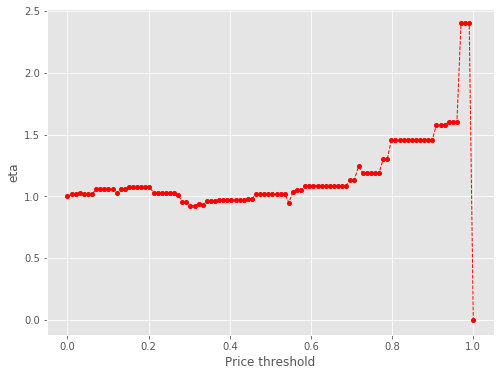

10286 45
Number of cells with price above 24.000000000000004th percentile:  45


eta =  1.0
eta =  1.0120870936741295
eta =  0.9991760231370775
eta =  0.9991760231370775
eta =  0.9991760231370775
eta =  1.0397375157628335
eta =  1.0397375157628335
eta =  1.0397375157628335
eta =  1.0393289146510662
eta =  1.0393289146510662
eta =  1.010381755510933
eta =  1.038673398618465
eta =  1.038673398618465
eta =  1.053978382837679
eta =  1.0528865126507847
eta =  1.0528865126507847
eta =  1.0528865126507847
eta =  1.0546745735770036
eta =  1.0546745735770036
eta =  1.0546745735770036
eta =  1.012556904263484
eta =  1.012556904263484
eta =  1.012556904263484
eta =  1.012556904263484
eta =  1.012556904263484
eta =  0.9917933884574828
eta =  0.9374879212063144
eta =  0.9374879212063144
eta =  0.9081234849917837
eta =  0.9081234849917837
eta =  0.9218574570062449
eta =  0.9175304570901096
eta =  0.943549465176147
eta =  0.943549465176147
eta =  0.943549465176147
eta =  0.943549465176147
eta =  0.9508215547861537
eta =  0.9508215547861537
eta =  0.9508215547861537
eta =  0.95082

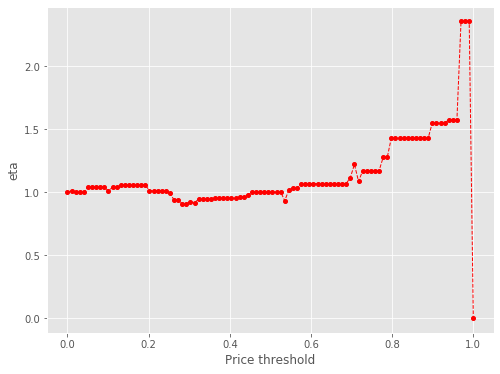

10286 45
Number of cells with price above 25.0th percentile:  45


eta =  1.0
eta =  1.0120870936741295
eta =  0.9991760231370775
eta =  0.9991760231370775
eta =  0.9991760231370775
eta =  1.0397375157628335
eta =  1.0397375157628335
eta =  1.0397375157628335
eta =  1.0393289146510662
eta =  1.0393289146510662
eta =  1.010381755510933
eta =  1.038673398618465
eta =  1.038673398618465
eta =  1.053978382837679
eta =  1.0528865126507847
eta =  1.0528865126507847
eta =  1.0528865126507847
eta =  1.0546745735770036
eta =  1.0546745735770036
eta =  1.0546745735770036
eta =  1.012556904263484
eta =  1.012556904263484
eta =  1.012556904263484
eta =  1.012556904263484
eta =  1.012556904263484
eta =  0.9917933884574828
eta =  0.9374879212063144
eta =  0.9374879212063144
eta =  0.9081234849917837
eta =  0.9081234849917837
eta =  0.9218574570062449
eta =  0.9175304570901096
eta =  0.943549465176147
eta =  0.943549465176147
eta =  0.943549465176147
eta =  0.943549465176147
eta =  0.9508215547861537
eta =  0.9508215547861537
eta =  0.9508215547861537
eta =  0.95082

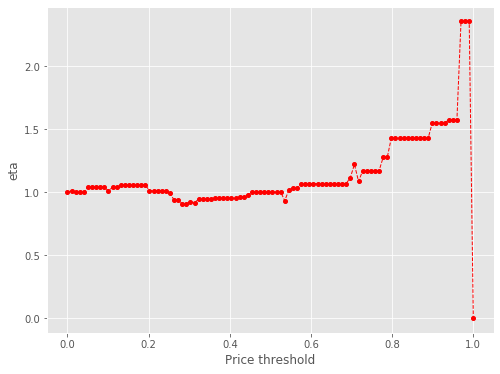

10286 43
Number of cells with price above 26.0th percentile:  43


eta =  1.0
eta =  0.9872431230298753
eta =  0.9872431230298753
eta =  0.9872431230298753
eta =  1.0273202002688582
eta =  1.0273202002688582
eta =  1.0273202002688582
eta =  1.026916478974198
eta =  1.026916478974198
eta =  0.9983150282482055
eta =  1.0262687915995654
eta =  1.0262687915995654
eta =  1.0413909923616094
eta =  1.04031216209718
eta =  1.04031216209718
eta =  1.04031216209718
eta =  1.0420788686754918
eta =  1.0420788686754918
eta =  1.0420788686754918
eta =  1.0004641997633317
eta =  1.0004641997633317
eta =  1.0004641997633317
eta =  1.0004641997633317
eta =  1.0004641997633317
eta =  0.9799486572415664
eta =  0.9262917461016111
eta =  0.9262917461016111
eta =  0.8972780017331
eta =  0.8972780017331
eta =  0.8972780017331
eta =  0.9065726288033615
eta =  0.9322808986238785
eta =  0.9322808986238785
eta =  0.9322808986238785
eta =  0.9322808986238785
eta =  0.9394661395536954
eta =  0.9394661395536954
eta =  0.9394661395536954
eta =  0.9394661395536954
eta =  0.939466139

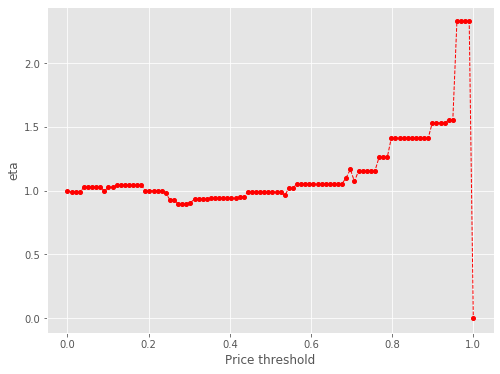

10286 42
Number of cells with price above 27.0th percentile:  42


eta =  1.0
eta =  1.0405949419186484
eta =  1.0405949419186484
eta =  1.0260799920738137
eta =  1.0401860038513757
eta =  1.0401860038513757
eta =  1.0112149732523334
eta =  1.0395299472433086
eta =  1.0395299472433086
eta =  1.054847552815109
eta =  1.0537547822105202
eta =  1.0537547822105202
eta =  1.0537547822105202
eta =  1.055544317672555
eta =  1.055544317672555
eta =  1.055544317672555
eta =  1.013391915755139
eta =  1.013391915755139
eta =  1.013391915755139
eta =  1.013391915755139
eta =  1.013391915755139
eta =  1.013391915755139
eta =  0.9382610265836011
eta =  0.9382610265836011
eta =  0.9088723747999683
eta =  0.9088723747999683
eta =  0.9088723747999683
eta =  0.9226176726218086
eta =  0.9182871044176698
eta =  0.944327569244224
eta =  0.944327569244224
eta =  0.944327569244224
eta =  0.944327569244224
eta =  0.9516056558291831
eta =  0.9516056558291831
eta =  0.9516056558291831
eta =  0.9516056558291831
eta =  0.9516056558291831
eta =  0.9516056558291831
eta =  0.951605

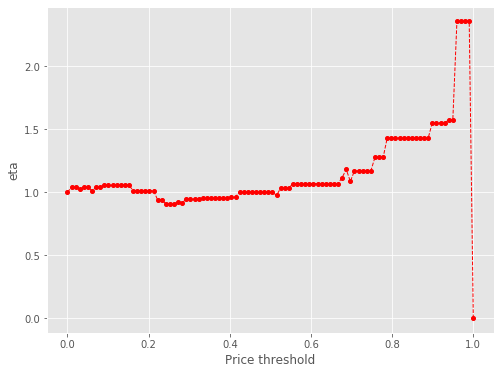

10286 42
Number of cells with price above 28.000000000000004th percentile:  42


eta =  1.0
eta =  1.0405949419186484
eta =  1.0405949419186484
eta =  1.0260799920738137
eta =  1.0401860038513757
eta =  1.0401860038513757
eta =  1.0112149732523334
eta =  1.0395299472433086
eta =  1.0395299472433086
eta =  1.054847552815109
eta =  1.0537547822105202
eta =  1.0537547822105202
eta =  1.0537547822105202
eta =  1.055544317672555
eta =  1.055544317672555
eta =  1.055544317672555
eta =  1.013391915755139
eta =  1.013391915755139
eta =  1.013391915755139
eta =  1.013391915755139
eta =  1.013391915755139
eta =  1.013391915755139
eta =  0.9382610265836011
eta =  0.9382610265836011
eta =  0.9088723747999683
eta =  0.9088723747999683
eta =  0.9088723747999683
eta =  0.9226176726218086
eta =  0.9182871044176698
eta =  0.944327569244224
eta =  0.944327569244224
eta =  0.944327569244224
eta =  0.944327569244224
eta =  0.9516056558291831
eta =  0.9516056558291831
eta =  0.9516056558291831
eta =  0.9516056558291831
eta =  0.9516056558291831
eta =  0.9516056558291831
eta =  0.951605

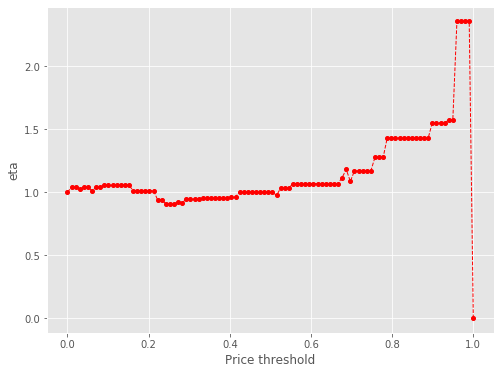

10286 39
Number of cells with price above 29.000000000000004th percentile:  39


eta =  1.0
eta =  0.9996070151306724
eta =  0.9996070151306724
eta =  0.971766181553656
eta =  0.998976552131441
eta =  0.998976552131441
eta =  1.0136965982846136
eta =  1.0136965982846136
eta =  1.0126464580613928
eta =  1.0126464580613928
eta =  1.0126464580613928
eta =  1.014366181452259
eta =  1.014366181452259
eta =  0.9738581987402778
eta =  0.9738581987402778
eta =  0.9738581987402778
eta =  0.9738581987402778
eta =  0.9738581987402778
eta =  0.9738581987402778
eta =  0.953888239504203
eta =  0.9016582618147613
eta =  0.9016582618147613
eta =  0.8734160989906311
eta =  0.8734160989906311
eta =  0.8734160989906311
eta =  0.8866251751336467
eta =  0.8824635479435758
eta =  0.9074881408735981
eta =  0.9074881408735981
eta =  0.9074881408735981
eta =  0.9074881408735981
eta =  0.9144822999760243
eta =  0.9144822999760243
eta =  0.9144822999760243
eta =  0.9144822999760243
eta =  0.9144822999760243
eta =  0.9144822999760243
eta =  0.9144822999760243
eta =  0.9261719269158257
eta =  

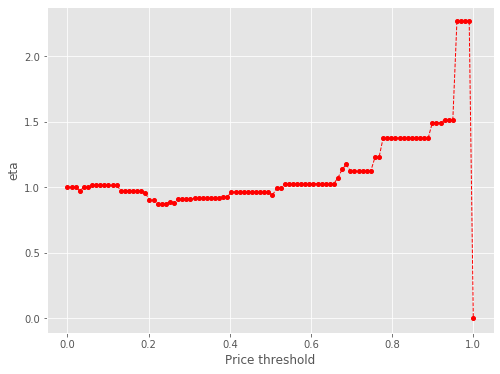

10286 39
Number of cells with price above 30.0th percentile:  39


eta =  1.0
eta =  0.9996070151306724
eta =  0.9996070151306724
eta =  0.971766181553656
eta =  0.998976552131441
eta =  0.998976552131441
eta =  1.0136965982846136
eta =  1.0136965982846136
eta =  1.0126464580613928
eta =  1.0126464580613928
eta =  1.0126464580613928
eta =  1.014366181452259
eta =  1.014366181452259
eta =  0.9738581987402778
eta =  0.9738581987402778
eta =  0.9738581987402778
eta =  0.9738581987402778
eta =  0.9738581987402778
eta =  0.9738581987402778
eta =  0.953888239504203
eta =  0.9016582618147613
eta =  0.9016582618147613
eta =  0.8734160989906311
eta =  0.8734160989906311
eta =  0.8734160989906311
eta =  0.8866251751336467
eta =  0.8824635479435758
eta =  0.9074881408735981
eta =  0.9074881408735981
eta =  0.9074881408735981
eta =  0.9074881408735981
eta =  0.9144822999760243
eta =  0.9144822999760243
eta =  0.9144822999760243
eta =  0.9144822999760243
eta =  0.9144822999760243
eta =  0.9144822999760243
eta =  0.9144822999760243
eta =  0.9261719269158257
eta =  

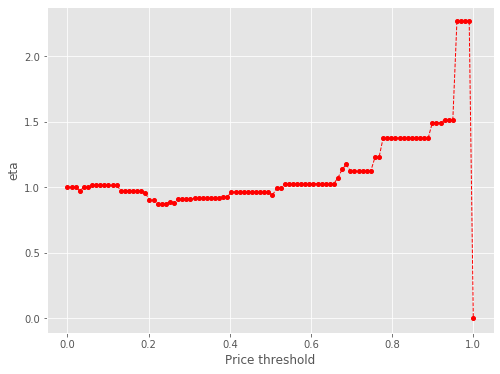

10286 37
Number of cells with price above 31.0th percentile:  37


eta =  1.0
eta =  1.0137474776689215
eta =  1.0137474776689215
eta =  0.9855128070556795
eta =  1.0131080961264152
eta =  1.0131080961264152
eta =  1.0280363723720536
eta =  1.0269713768424358
eta =  1.0269713768424358
eta =  1.0269713768424358
eta =  1.028715427477726
eta =  1.028715427477726
eta =  1.028715427477726
eta =  0.9876344179628425
eta =  0.9876344179628425
eta =  0.9876344179628425
eta =  0.9876344179628425
eta =  0.9876344179628425
eta =  0.9876344179628425
eta =  0.9673819632498515
eta =  0.9144131391620633
eta =  0.9144131391620633
eta =  0.8857714620894647
eta =  0.8857714620894647
eta =  0.8857714620894647
eta =  0.8949468964517246
eta =  0.8949468964517246
eta =  0.9203254878166374
eta =  0.9203254878166374
eta =  0.9203254878166374
eta =  0.927418586445575
eta =  0.927418586445575
eta =  0.927418586445575
eta =  0.927418586445575
eta =  0.927418586445575
eta =  0.927418586445575
eta =  0.927418586445575
eta =  0.927418586445575
eta =  0.9392735751018573
eta =  0.939

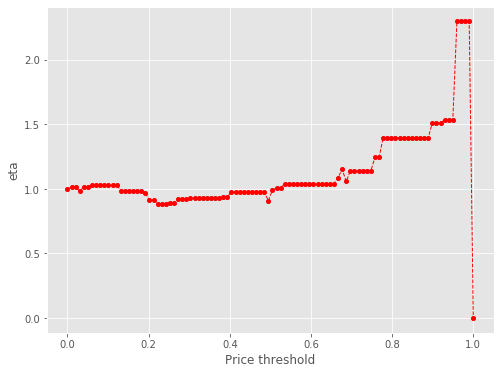

10286 36
Number of cells with price above 32.0th percentile:  36


eta =  1.0
eta =  0.9831227765048377
eta =  0.9993692891409441
eta =  1.0140951223237458
eta =  1.0140951223237458
eta =  1.0130445692490622
eta =  1.0130445692490622
eta =  1.0130445692490622
eta =  1.0147649687308942
eta =  1.0147649687308942
eta =  1.0147649687308942
eta =  0.9742410607362249
eta =  0.9742410607362249
eta =  0.9742410607362249
eta =  0.9742410607362249
eta =  0.9742410607362249
eta =  0.9742410607362249
eta =  0.954263250523014
eta =  0.9020127391731971
eta =  0.9020127391731971
eta =  0.8737594732430473
eta =  0.8737594732430473
eta =  0.8737594732430473
eta =  0.8869737423938984
eta =  0.8828104791043477
eta =  0.9078449101869976
eta =  0.9078449101869976
eta =  0.9078449101869976
eta =  0.9078449101869976
eta =  0.9148418189687072
eta =  0.9148418189687072
eta =  0.9148418189687072
eta =  0.9148418189687072
eta =  0.9148418189687072
eta =  0.9148418189687072
eta =  0.9148418189687072
eta =  0.9265360415610459
eta =  0.9265360415610459
eta =  0.9439006725873983
et

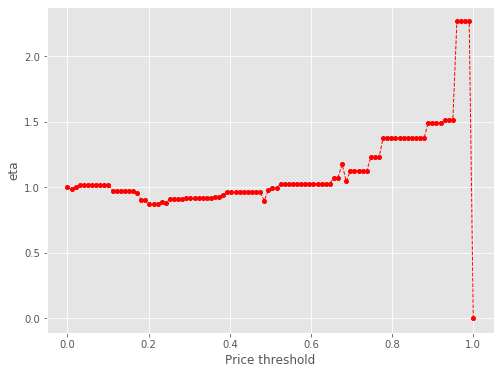

10286 35
Number of cells with price above 33.0th percentile:  35


eta =  1.0
eta =  1.0280009441512783
eta =  1.043148668400787
eta =  1.043148668400787
eta =  1.0420680172697279
eta =  1.0420680172697279
eta =  1.0420680172697279
eta =  1.0438377057230932
eta =  1.0438377057230932
eta =  1.0438377057230932
eta =  1.0021527989204946
eta =  1.0021527989204946
eta =  1.0021527989204946
eta =  1.0021527989204946
eta =  1.0021527989204946
eta =  1.0021527989204946
eta =  0.9816026299445101
eta =  0.9278551558289398
eta =  0.9278551558289398
eta =  0.8987924416079358
eta =  0.8987924416079358
eta =  0.8987924416079358
eta =  0.9123852959321076
eta =  0.9081027562954461
eta =  0.9338544169367055
eta =  0.9338544169367055
eta =  0.9338544169367055
eta =  0.9338544169367055
eta =  0.9410517852287816
eta =  0.9410517852287816
eta =  0.9410517852287816
eta =  0.9410517852287816
eta =  0.9410517852287816
eta =  0.9410517852287816
eta =  0.9410517852287816
eta =  0.9410517852287816
eta =  0.9530810440790043
eta =  0.9530810440790043
eta =  0.9910382285072543
eta

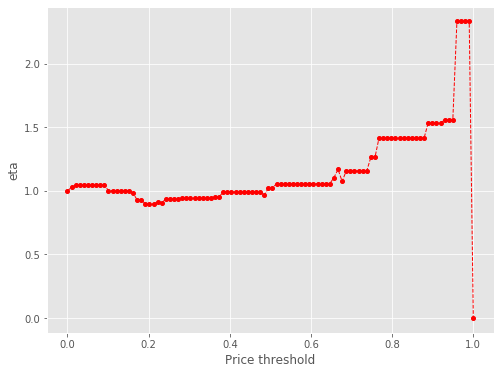

10286 33
Number of cells with price above 34.0th percentile:  33


eta =  1.0
eta =  1.014735126787276
eta =  1.0136839106991904
eta =  1.0136839106991904
eta =  1.0136839106991904
eta =  1.0136839106991904
eta =  1.0154053959404579
eta =  1.0154053959404579
eta =  0.9748559129465351
eta =  0.9748559129465351
eta =  0.9748559129465351
eta =  0.9748559129465351
eta =  0.9748559129465351
eta =  0.9748559129465351
eta =  0.9748559129465351
eta =  0.9025820074464821
eta =  0.9025820074464821
eta =  0.9025820074464821
eta =  0.8743109106285718
eta =  0.8743109106285718
eta =  0.8743109106285718
eta =  0.8875335194223741
eta =  0.8833676286602823
eta =  0.9084178591953525
eta =  0.9084178591953525
eta =  0.9084178591953525
eta =  0.9084178591953525
eta =  0.9154191837885107
eta =  0.9154191837885107
eta =  0.9154191837885107
eta =  0.9154191837885107
eta =  0.9154191837885107
eta =  0.9154191837885107
eta =  0.9154191837885107
eta =  0.9271207867088797
eta =  0.9271207867088797
eta =  0.9271207867088797
eta =  0.9640440839531128
eta =  0.9640440839531128
et

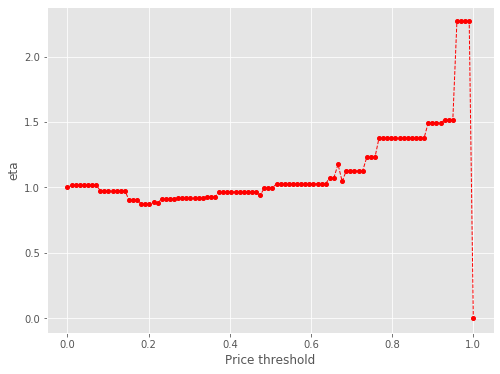

10286 32
Number of cells with price above 35.0th percentile:  32


eta =  1.0
eta =  0.9989640487844215
eta =  0.9989640487844215
eta =  0.9989640487844215
eta =  1.0006605360704364
eta =  1.0006605360704364
eta =  1.0006605360704364
eta =  0.9606998784332998
eta =  0.9606998784332998
eta =  0.9606998784332998
eta =  0.9606998784332998
eta =  0.9606998784332998
eta =  0.9606998784332998
eta =  0.940999744024377
eta =  0.8894754735692667
eta =  0.8894754735692667
eta =  0.8616149057505309
eta =  0.8616149057505309
eta =  0.8616149057505309
eta =  0.8746455069830577
eta =  0.8705401097694208
eta =  0.8952265820061521
eta =  0.8952265820061521
eta =  0.8952265820061521
eta =  0.8952265820061521
eta =  0.9021262392746701
eta =  0.9021262392746701
eta =  0.9021262392746701
eta =  0.9021262392746701
eta =  0.9021262392746701
eta =  0.9021262392746701
eta =  0.9021262392746701
eta =  0.9021262392746701
eta =  0.9136579213968974
eta =  0.9136579213968974
eta =  0.9307811977484908
eta =  0.9500450496922733
eta =  0.9500450496922733
eta =  0.9500450496922733
et

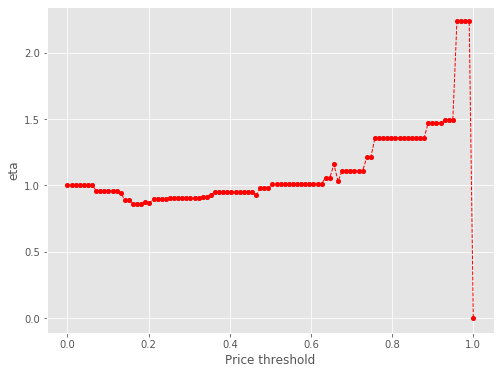

10286 31
Number of cells with price above 36.00000000000001th percentile:  31


eta =  1.0
eta =  1.0016982465866306
eta =  1.0016982465866306
eta =  0.9616961487275915
eta =  0.9616961487275915
eta =  0.9616961487275915
eta =  0.9616961487275915
eta =  0.9616961487275915
eta =  0.9616961487275915
eta =  0.9616961487275915
eta =  0.9419755847764715
eta =  0.8903978823378231
eta =  0.8903978823378231
eta =  0.862508422399162
eta =  0.862508422399162
eta =  0.862508422399162
eta =  0.8755525366977525
eta =  0.8714428820824213
eta =  0.8714428820824213
eta =  0.8961549548209456
eta =  0.8961549548209456
eta =  0.8961549548209456
eta =  0.8961549548209456
eta =  0.9030617672101539
eta =  0.9030617672101539
eta =  0.9030617672101539
eta =  0.9030617672101539
eta =  0.9030617672101539
eta =  0.9030617672101539
eta =  0.9030617672101539
eta =  0.9030617672101539
eta =  0.91460540798107
eta =  0.91460540798107
eta =  0.9317464416072848
eta =  0.9510302706572127
eta =  0.9510302706572127
eta =  0.9510302706572127
eta =  0.9510302706572127
eta =  0.9510302706572127
eta =  0

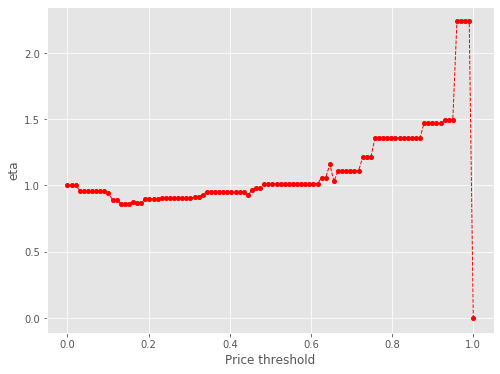

10286 31
Number of cells with price above 37.0th percentile:  31


eta =  1.0
eta =  1.0016982465866306
eta =  1.0016982465866306
eta =  0.9616961487275915
eta =  0.9616961487275915
eta =  0.9616961487275915
eta =  0.9616961487275915
eta =  0.9616961487275915
eta =  0.9616961487275915
eta =  0.9616961487275915
eta =  0.9419755847764715
eta =  0.8903978823378231
eta =  0.8903978823378231
eta =  0.862508422399162
eta =  0.862508422399162
eta =  0.862508422399162
eta =  0.8755525366977525
eta =  0.8714428820824213
eta =  0.8714428820824213
eta =  0.8961549548209456
eta =  0.8961549548209456
eta =  0.8961549548209456
eta =  0.8961549548209456
eta =  0.9030617672101539
eta =  0.9030617672101539
eta =  0.9030617672101539
eta =  0.9030617672101539
eta =  0.9030617672101539
eta =  0.9030617672101539
eta =  0.9030617672101539
eta =  0.9030617672101539
eta =  0.91460540798107
eta =  0.91460540798107
eta =  0.9317464416072848
eta =  0.9510302706572127
eta =  0.9510302706572127
eta =  0.9510302706572127
eta =  0.9510302706572127
eta =  0.9510302706572127
eta =  0

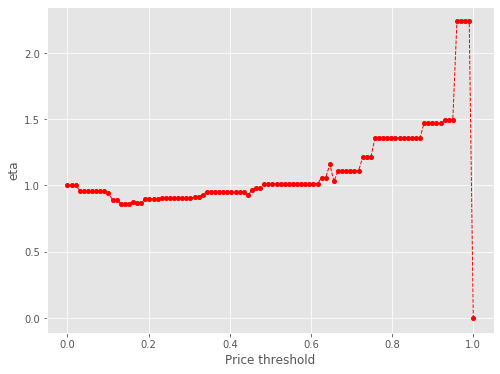

10286 30
Number of cells with price above 38.0th percentile:  30


eta =  1.0
eta =  0.9600657203949895
eta =  0.9600657203949895
eta =  0.9600657203949895
eta =  0.9600657203949895
eta =  0.9600657203949895
eta =  0.9600657203949895
eta =  0.9403785900457856
eta =  0.8888883307642069
eta =  0.8888883307642069
eta =  0.8888883307642069
eta =  0.8610461537076964
eta =  0.8610461537076964
eta =  0.8610461537076964
eta =  0.8740681534396909
eta =  0.8699654661989623
eta =  0.8946356428941226
eta =  0.8946356428941226
eta =  0.8946356428941226
eta =  0.8946356428941226
eta =  0.8946356428941226
eta =  0.9015307456985288
eta =  0.9015307456985288
eta =  0.9015307456985288
eta =  0.9015307456985288
eta =  0.9015307456985288
eta =  0.9015307456985288
eta =  0.9015307456985288
eta =  0.9015307456985288
eta =  0.9130548157568044
eta =  0.9130548157568044
eta =  0.9301667890328126
eta =  0.9494179249069534
eta =  0.9494179249069534
eta =  0.9494179249069534
eta =  0.9494179249069534
eta =  0.9494179249069534
eta =  0.9494179249069534
eta =  0.9494179249069534
e

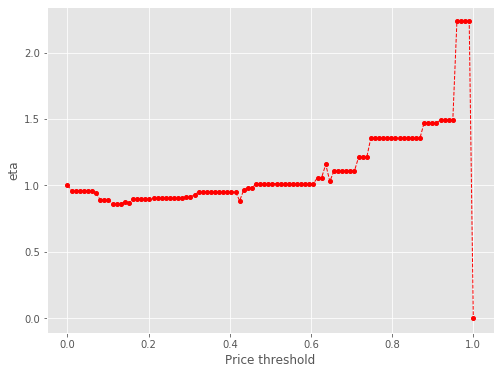

10286 30
Number of cells with price above 39.0th percentile:  30


eta =  1.0
eta =  0.9600657203949895
eta =  0.9600657203949895
eta =  0.9600657203949895
eta =  0.9600657203949895
eta =  0.9600657203949895
eta =  0.9600657203949895
eta =  0.9403785900457856
eta =  0.8888883307642069
eta =  0.8888883307642069
eta =  0.8888883307642069
eta =  0.8610461537076964
eta =  0.8610461537076964
eta =  0.8610461537076964
eta =  0.8740681534396909
eta =  0.8699654661989623
eta =  0.8946356428941226
eta =  0.8946356428941226
eta =  0.8946356428941226
eta =  0.8946356428941226
eta =  0.8946356428941226
eta =  0.9015307456985288
eta =  0.9015307456985288
eta =  0.9015307456985288
eta =  0.9015307456985288
eta =  0.9015307456985288
eta =  0.9015307456985288
eta =  0.9015307456985288
eta =  0.9015307456985288
eta =  0.9130548157568044
eta =  0.9130548157568044
eta =  0.9301667890328126
eta =  0.9494179249069534
eta =  0.9494179249069534
eta =  0.9494179249069534
eta =  0.9494179249069534
eta =  0.9494179249069534
eta =  0.9494179249069534
eta =  0.9494179249069534
e

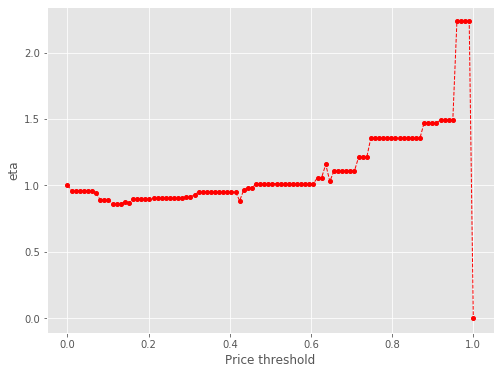

10286 29
Number of cells with price above 40.0th percentile:  29


eta =  1.0
eta =  0.9258619611983451
eta =  0.9258619611983451
eta =  0.9258619611983451
eta =  0.8968616787540811
eta =  0.8968616787540811
eta =  0.8968616787540811
eta =  0.9104253332574801
eta =  0.9061519932625465
eta =  0.9061519932625465
eta =  0.9318483348473814
eta =  0.9318483348473814
eta =  0.9318483348473814
eta =  0.9318483348473814
eta =  0.9318483348473814
eta =  0.9390302419376266
eta =  0.9390302419376266
eta =  0.9390302419376266
eta =  0.9390302419376266
eta =  0.9390302419376266
eta =  0.9390302419376266
eta =  0.9390302419376266
eta =  0.9390302419376266
eta =  0.9510336598427408
eta =  0.9510336598427408
eta =  0.9510336598427408
eta =  0.9688574118135622
eta =  0.988909305621645
eta =  0.988909305621645
eta =  0.988909305621645
eta =  0.988909305621645
eta =  0.988909305621645
eta =  0.988909305621645
eta =  0.988909305621645
eta =  0.988909305621645
eta =  0.988909305621645
eta =  0.988909305621645
eta =  0.988909305621645
eta =  0.9616372980898551
eta =  1.004

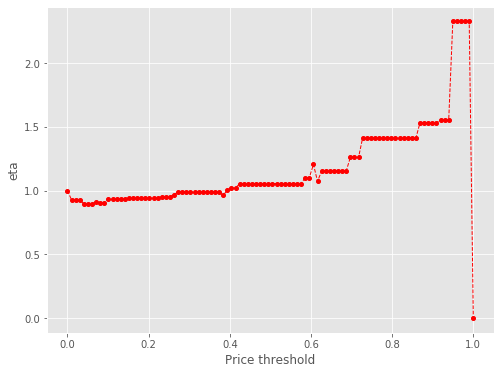

10286 29
Number of cells with price above 41.0th percentile:  29


eta =  1.0
eta =  0.9258619611983451
eta =  0.9258619611983451
eta =  0.9258619611983451
eta =  0.8968616787540811
eta =  0.8968616787540811
eta =  0.8968616787540811
eta =  0.9104253332574801
eta =  0.9061519932625465
eta =  0.9061519932625465
eta =  0.9318483348473814
eta =  0.9318483348473814
eta =  0.9318483348473814
eta =  0.9318483348473814
eta =  0.9318483348473814
eta =  0.9390302419376266
eta =  0.9390302419376266
eta =  0.9390302419376266
eta =  0.9390302419376266
eta =  0.9390302419376266
eta =  0.9390302419376266
eta =  0.9390302419376266
eta =  0.9390302419376266
eta =  0.9510336598427408
eta =  0.9510336598427408
eta =  0.9510336598427408
eta =  0.9688574118135622
eta =  0.988909305621645
eta =  0.988909305621645
eta =  0.988909305621645
eta =  0.988909305621645
eta =  0.988909305621645
eta =  0.988909305621645
eta =  0.988909305621645
eta =  0.988909305621645
eta =  0.988909305621645
eta =  0.988909305621645
eta =  0.988909305621645
eta =  0.9616372980898551
eta =  1.004

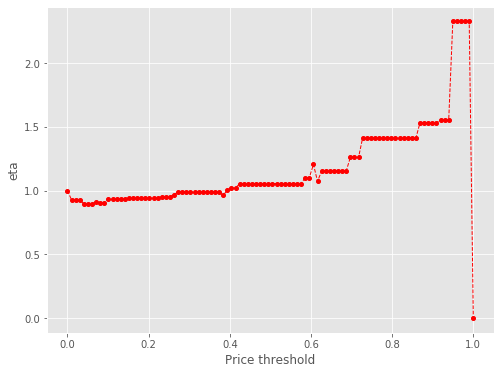

10286 29
Number of cells with price above 42.00000000000001th percentile:  29


eta =  1.0
eta =  0.9258619611983451
eta =  0.9258619611983451
eta =  0.9258619611983451
eta =  0.8968616787540811
eta =  0.8968616787540811
eta =  0.8968616787540811
eta =  0.9104253332574801
eta =  0.9061519932625465
eta =  0.9061519932625465
eta =  0.9318483348473814
eta =  0.9318483348473814
eta =  0.9318483348473814
eta =  0.9318483348473814
eta =  0.9318483348473814
eta =  0.9390302419376266
eta =  0.9390302419376266
eta =  0.9390302419376266
eta =  0.9390302419376266
eta =  0.9390302419376266
eta =  0.9390302419376266
eta =  0.9390302419376266
eta =  0.9390302419376266
eta =  0.9510336598427408
eta =  0.9510336598427408
eta =  0.9510336598427408
eta =  0.9688574118135622
eta =  0.988909305621645
eta =  0.988909305621645
eta =  0.988909305621645
eta =  0.988909305621645
eta =  0.988909305621645
eta =  0.988909305621645
eta =  0.988909305621645
eta =  0.988909305621645
eta =  0.988909305621645
eta =  0.988909305621645
eta =  0.988909305621645
eta =  0.9616372980898551
eta =  1.004

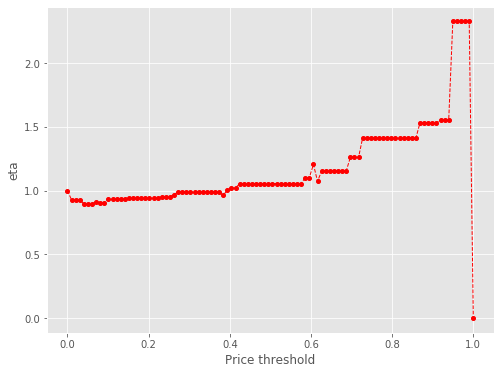

10286 29
Number of cells with price above 43.0th percentile:  29


eta =  1.0
eta =  0.9258619611983451
eta =  0.9258619611983451
eta =  0.9258619611983451
eta =  0.8968616787540811
eta =  0.8968616787540811
eta =  0.8968616787540811
eta =  0.9104253332574801
eta =  0.9061519932625465
eta =  0.9061519932625465
eta =  0.9318483348473814
eta =  0.9318483348473814
eta =  0.9318483348473814
eta =  0.9318483348473814
eta =  0.9318483348473814
eta =  0.9390302419376266
eta =  0.9390302419376266
eta =  0.9390302419376266
eta =  0.9390302419376266
eta =  0.9390302419376266
eta =  0.9390302419376266
eta =  0.9390302419376266
eta =  0.9390302419376266
eta =  0.9510336598427408
eta =  0.9510336598427408
eta =  0.9510336598427408
eta =  0.9688574118135622
eta =  0.988909305621645
eta =  0.988909305621645
eta =  0.988909305621645
eta =  0.988909305621645
eta =  0.988909305621645
eta =  0.988909305621645
eta =  0.988909305621645
eta =  0.988909305621645
eta =  0.988909305621645
eta =  0.988909305621645
eta =  0.988909305621645
eta =  0.9616372980898551
eta =  1.004

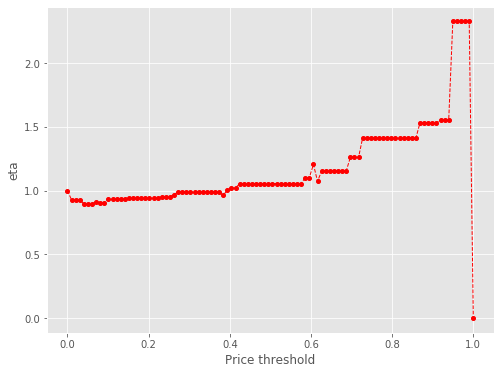

10286 28
Number of cells with price above 44.0th percentile:  28


eta =  1.0
eta =  0.9452451812210317
eta =  0.9452451812210317
eta =  0.915637768471285
eta =  0.915637768471285
eta =  0.915637768471285
eta =  0.915637768471285
eta =  0.9294853824746625
eta =  0.9251225787229003
eta =  0.9513568815412567
eta =  0.9513568815412567
eta =  0.9513568815412567
eta =  0.9513568815412567
eta =  0.9513568815412567
eta =  0.9586891441824877
eta =  0.9586891441824877
eta =  0.9586891441824877
eta =  0.9586891441824877
eta =  0.9586891441824877
eta =  0.9586891441824877
eta =  0.9586891441824877
eta =  0.9586891441824877
eta =  0.9586891441824877
eta =  0.9709438575290714
eta =  0.9709438575290714
eta =  0.9891407555200976
eta =  1.0096124422193913
eta =  1.0096124422193913
eta =  1.0096124422193913
eta =  1.0096124422193913
eta =  1.0096124422193913
eta =  1.0096124422193913
eta =  1.0096124422193913
eta =  1.0096124422193913
eta =  1.0096124422193913
eta =  1.0096124422193913
eta =  1.0096124422193913
eta =  0.9394363677498816
eta =  0.981769486377159
eta = 

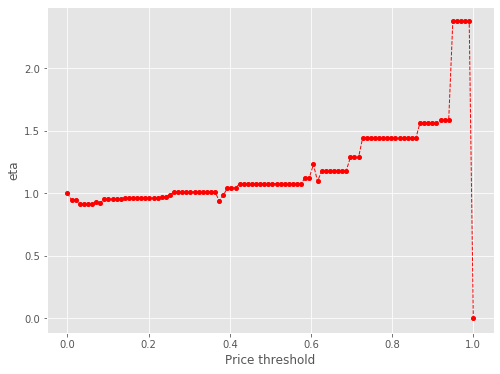

10286 27
Number of cells with price above 45.0th percentile:  27


eta =  1.0
eta =  0.9686775311443524
eta =  0.9686775311443524
eta =  0.9686775311443524
eta =  0.9833272900412872
eta =  0.9787117639974237
eta =  0.9787117639974237
eta =  1.0064657302059241
eta =  1.0064657302059241
eta =  1.0064657302059241
eta =  1.0064657302059241
eta =  1.0142227257314231
eta =  1.0142227257314231
eta =  1.0142227257314231
eta =  1.0142227257314231
eta =  1.0142227257314231
eta =  1.0142227257314231
eta =  1.0142227257314231
eta =  1.0142227257314231
eta =  1.0142227257314231
eta =  1.0271873126873212
eta =  1.0271873126873212
eta =  1.0271873126873212
eta =  1.0464382947103346
eta =  1.0680958361673025
eta =  1.0680958361673025
eta =  1.0680958361673025
eta =  1.0680958361673025
eta =  1.0680958361673025
eta =  1.0680958361673025
eta =  1.0680958361673025
eta =  1.0680958361673025
eta =  1.0680958361673025
eta =  1.0680958361673025
eta =  1.0680958361673025
eta =  0.9938547018418581
eta =  1.038640033169962
eta =  1.1010583104467486
eta =  1.1010583104467486
et

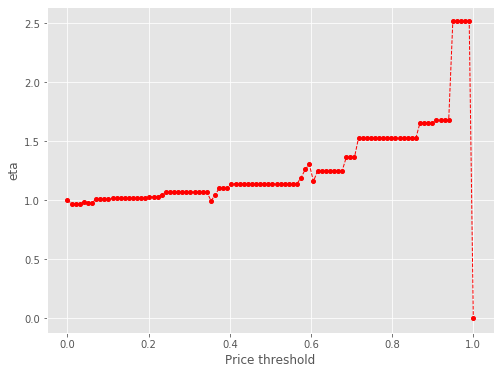

10286 27
Number of cells with price above 46.0th percentile:  27


eta =  1.0
eta =  0.9686775311443524
eta =  0.9686775311443524
eta =  0.9686775311443524
eta =  0.9833272900412872
eta =  0.9787117639974237
eta =  0.9787117639974237
eta =  1.0064657302059241
eta =  1.0064657302059241
eta =  1.0064657302059241
eta =  1.0064657302059241
eta =  1.0142227257314231
eta =  1.0142227257314231
eta =  1.0142227257314231
eta =  1.0142227257314231
eta =  1.0142227257314231
eta =  1.0142227257314231
eta =  1.0142227257314231
eta =  1.0142227257314231
eta =  1.0142227257314231
eta =  1.0271873126873212
eta =  1.0271873126873212
eta =  1.0271873126873212
eta =  1.0464382947103346
eta =  1.0680958361673025
eta =  1.0680958361673025
eta =  1.0680958361673025
eta =  1.0680958361673025
eta =  1.0680958361673025
eta =  1.0680958361673025
eta =  1.0680958361673025
eta =  1.0680958361673025
eta =  1.0680958361673025
eta =  1.0680958361673025
eta =  1.0680958361673025
eta =  0.9938547018418581
eta =  1.038640033169962
eta =  1.1010583104467486
eta =  1.1010583104467486
et

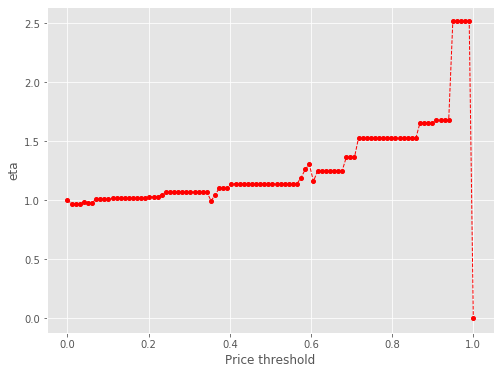

10286 25
Number of cells with price above 47.0th percentile:  25


eta =  1.0
eta =  1.0151234630988377
eta =  1.010358692681988
eta =  1.03901009143562
eta =  1.03901009143562
eta =  1.03901009143562
eta =  1.03901009143562
eta =  1.03901009143562
eta =  1.0470179116607212
eta =  1.0470179116607212
eta =  1.0470179116607212
eta =  1.0470179116607212
eta =  1.0470179116607212
eta =  1.0470179116607212
eta =  1.0470179116607212
eta =  1.0470179116607212
eta =  1.0470179116607212
eta =  1.0470179116607212
eta =  1.0604017122951617
eta =  1.0604017122951617
eta =  1.0604017122951617
eta =  1.1026330247440568
eta =  1.1026330247440568
eta =  1.1026330247440568
eta =  1.1026330247440568
eta =  1.1026330247440568
eta =  1.1026330247440568
eta =  1.1026330247440568
eta =  1.1026330247440568
eta =  1.1026330247440568
eta =  1.1026330247440568
eta =  1.1026330247440568
eta =  1.1026330247440568
eta =  1.0259912818125994
eta =  1.0722247598155383
eta =  1.1366613501874123
eta =  1.1366613501874123
eta =  1.1366613501874123
eta =  1.176124290340262
eta =  1.1761

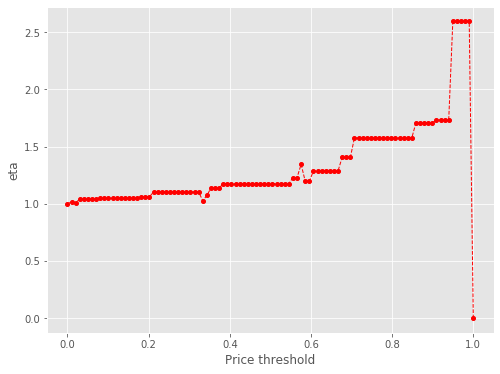

10286 24
Number of cells with price above 48.00000000000001th percentile:  24


eta =  1.0
eta =  0.9953062158544692
eta =  1.02353076173007
eta =  1.02353076173007
eta =  1.02353076173007
eta =  1.02353076173007
eta =  1.02353076173007
eta =  1.0314192802366329
eta =  1.0314192802366329
eta =  1.0314192802366329
eta =  1.0314192802366329
eta =  1.0314192802366329
eta =  1.0314192802366329
eta =  1.0314192802366329
eta =  1.0314192802366329
eta =  1.0314192802366329
eta =  1.0314192802366329
eta =  1.0446036869821769
eta =  1.0446036869821769
eta =  1.0446036869821769
eta =  1.0862058309420621
eta =  1.0862058309420621
eta =  1.0862058309420621
eta =  1.0862058309420621
eta =  1.0862058309420621
eta =  1.0862058309420621
eta =  1.0862058309420621
eta =  1.0862058309420621
eta =  1.0862058309420621
eta =  1.0862058309420621
eta =  1.0862058309420621
eta =  1.0862058309420621
eta =  1.0107059083045777
eta =  1.0562505929499346
eta =  1.1036660291324365
eta =  1.1197271972392004
eta =  1.1197271972392004
eta =  1.1586022125327906
eta =  1.1586022125327906
eta =  1.15

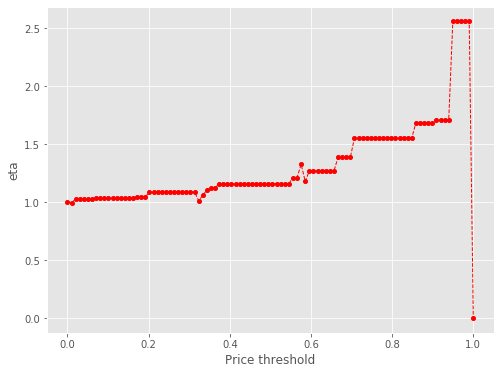

10286 23
Number of cells with price above 49.0th percentile:  23


eta =  1.0
eta =  1.028357650566233
eta =  1.028357650566233
eta =  1.028357650566233
eta =  1.028357650566233
eta =  1.028357650566233
eta =  1.0362833706922654
eta =  1.0362833706922654
eta =  1.0362833706922654
eta =  1.0362833706922654
eta =  1.0362833706922654
eta =  1.0362833706922654
eta =  1.0362833706922654
eta =  1.0362833706922654
eta =  1.0362833706922654
eta =  1.049529954040713
eta =  1.049529954040713
eta =  1.049529954040713
eta =  1.0691996696108879
eta =  1.0913282903689652
eta =  1.0913282903689652
eta =  1.0913282903689652
eta =  1.0913282903689652
eta =  1.0913282903689652
eta =  1.0913282903689652
eta =  1.0913282903689652
eta =  1.0913282903689652
eta =  1.0913282903689652
eta =  1.0913282903689652
eta =  1.0913282903689652
eta =  1.0913282903689652
eta =  1.0154723161624064
eta =  1.0612317858812372
eta =  1.1250077407362677
eta =  1.1250077407362677
eta =  1.1250077407362677
eta =  1.1640660874785476
eta =  1.1640660874785476
eta =  1.1640660874785476
eta =  1.

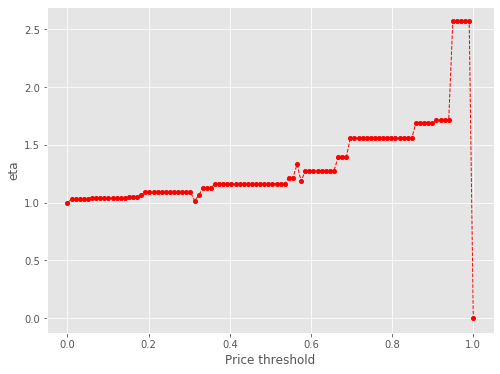

10286 22
Number of cells with price above 50.0th percentile:  22


eta =  1.0
eta =  1.0077071630883168
eta =  1.0077071630883168
eta =  1.0077071630883168
eta =  1.0077071630883168
eta =  1.0077071630883168
eta =  1.0077071630883168
eta =  1.0077071630883168
eta =  1.0077071630883168
eta =  1.0077071630883168
eta =  1.0077071630883168
eta =  1.020588463034064
eta =  1.020588463034064
eta =  1.020588463034064
eta =  1.0612341822595082
eta =  1.0612341822595082
eta =  1.0612341822595082
eta =  1.0612341822595082
eta =  1.0612341822595082
eta =  1.0612341822595082
eta =  1.0612341822595082
eta =  1.0612341822595082
eta =  1.0612341822595082
eta =  1.0612341822595082
eta =  1.0612341822595082
eta =  1.0612341822595082
eta =  1.0612341822595082
eta =  1.0612341822595082
eta =  1.0319676090287295
eta =  1.078292974084056
eta =  1.093984899238915
eta =  1.093984899238915
eta =  1.093984899238915
eta =  1.1319661859252865
eta =  1.1319661859252865
eta =  1.1319661859252865
eta =  1.1319661859252865
eta =  1.1319661859252865
eta =  1.1319661859252865
eta =  1

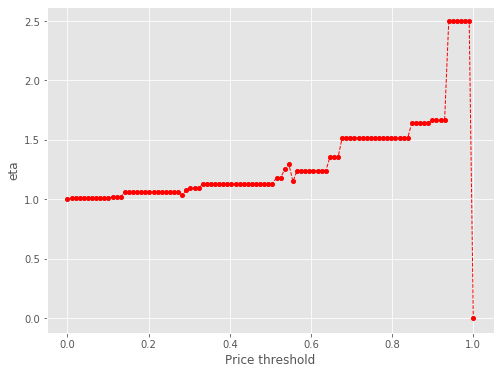

10286 22
Number of cells with price above 51.0th percentile:  22


eta =  1.0
eta =  1.0077071630883168
eta =  1.0077071630883168
eta =  1.0077071630883168
eta =  1.0077071630883168
eta =  1.0077071630883168
eta =  1.0077071630883168
eta =  1.0077071630883168
eta =  1.0077071630883168
eta =  1.0077071630883168
eta =  1.0077071630883168
eta =  1.020588463034064
eta =  1.020588463034064
eta =  1.020588463034064
eta =  1.0612341822595082
eta =  1.0612341822595082
eta =  1.0612341822595082
eta =  1.0612341822595082
eta =  1.0612341822595082
eta =  1.0612341822595082
eta =  1.0612341822595082
eta =  1.0612341822595082
eta =  1.0612341822595082
eta =  1.0612341822595082
eta =  1.0612341822595082
eta =  1.0612341822595082
eta =  1.0612341822595082
eta =  1.0612341822595082
eta =  1.0319676090287295
eta =  1.078292974084056
eta =  1.093984899238915
eta =  1.093984899238915
eta =  1.093984899238915
eta =  1.1319661859252865
eta =  1.1319661859252865
eta =  1.1319661859252865
eta =  1.1319661859252865
eta =  1.1319661859252865
eta =  1.1319661859252865
eta =  1

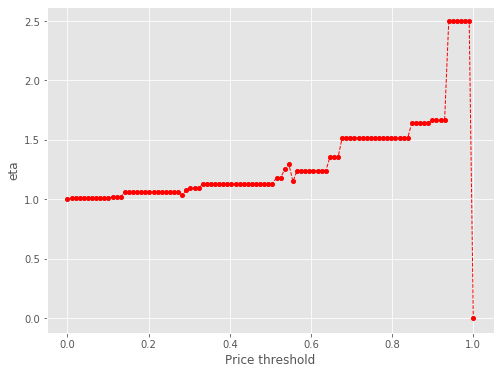

10286 21
Number of cells with price above 52.0th percentile:  21


eta =  1.0
eta =  1.0127827809681038
eta =  1.0127827809681038
eta =  1.0127827809681038
eta =  1.03176380114701
eta =  1.053117632911477
eta =  1.053117632911477
eta =  1.053117632911477
eta =  1.053117632911477
eta =  1.053117632911477
eta =  1.053117632911477
eta =  1.053117632911477
eta =  1.053117632911477
eta =  1.053117632911477
eta =  1.053117632911477
eta =  1.053117632911477
eta =  1.053117632911477
eta =  1.053117632911477
eta =  1.053117632911477
eta =  0.9799176025415165
eta =  1.0240748967845597
eta =  1.070045955393842
eta =  1.0856178652994615
eta =  1.0856178652994615
eta =  1.0856178652994615
eta =  1.1233086628620894
eta =  1.1233086628620894
eta =  1.1233086628620894
eta =  1.1233086628620894
eta =  1.1233086628620894
eta =  1.1233086628620894
eta =  1.1233086628620894
eta =  1.1233086628620894
eta =  1.1233086628620894
eta =  1.1233086628620894
eta =  1.1233086628620894
eta =  1.1233086628620894
eta =  1.1233086628620894
eta =  1.1233086628620894
eta =  1.123308662

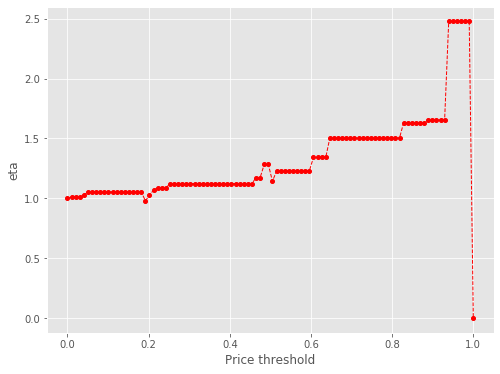

10286 21
Number of cells with price above 53.0th percentile:  21


eta =  1.0
eta =  1.0127827809681038
eta =  1.0127827809681038
eta =  1.0127827809681038
eta =  1.03176380114701
eta =  1.053117632911477
eta =  1.053117632911477
eta =  1.053117632911477
eta =  1.053117632911477
eta =  1.053117632911477
eta =  1.053117632911477
eta =  1.053117632911477
eta =  1.053117632911477
eta =  1.053117632911477
eta =  1.053117632911477
eta =  1.053117632911477
eta =  1.053117632911477
eta =  1.053117632911477
eta =  1.053117632911477
eta =  0.9799176025415165
eta =  1.0240748967845597
eta =  1.070045955393842
eta =  1.0856178652994615
eta =  1.0856178652994615
eta =  1.0856178652994615
eta =  1.1233086628620894
eta =  1.1233086628620894
eta =  1.1233086628620894
eta =  1.1233086628620894
eta =  1.1233086628620894
eta =  1.1233086628620894
eta =  1.1233086628620894
eta =  1.1233086628620894
eta =  1.1233086628620894
eta =  1.1233086628620894
eta =  1.1233086628620894
eta =  1.1233086628620894
eta =  1.1233086628620894
eta =  1.1233086628620894
eta =  1.123308662

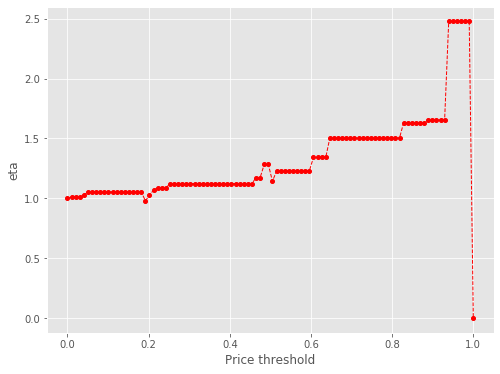

10286 21
Number of cells with price above 54.0th percentile:  21


eta =  1.0
eta =  1.0127827809681038
eta =  1.0127827809681038
eta =  1.0127827809681038
eta =  1.03176380114701
eta =  1.053117632911477
eta =  1.053117632911477
eta =  1.053117632911477
eta =  1.053117632911477
eta =  1.053117632911477
eta =  1.053117632911477
eta =  1.053117632911477
eta =  1.053117632911477
eta =  1.053117632911477
eta =  1.053117632911477
eta =  1.053117632911477
eta =  1.053117632911477
eta =  1.053117632911477
eta =  1.053117632911477
eta =  0.9799176025415165
eta =  1.0240748967845597
eta =  1.070045955393842
eta =  1.0856178652994615
eta =  1.0856178652994615
eta =  1.0856178652994615
eta =  1.1233086628620894
eta =  1.1233086628620894
eta =  1.1233086628620894
eta =  1.1233086628620894
eta =  1.1233086628620894
eta =  1.1233086628620894
eta =  1.1233086628620894
eta =  1.1233086628620894
eta =  1.1233086628620894
eta =  1.1233086628620894
eta =  1.1233086628620894
eta =  1.1233086628620894
eta =  1.1233086628620894
eta =  1.1233086628620894
eta =  1.123308662

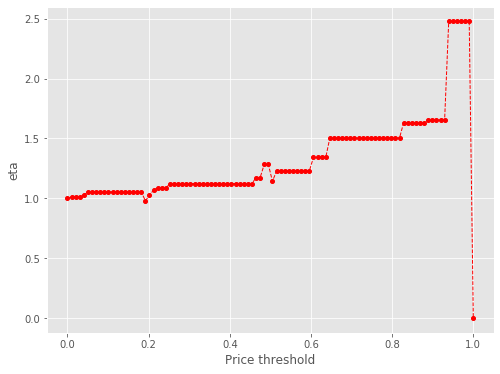

10286 21
Number of cells with price above 55.00000000000001th percentile:  21


eta =  1.0
eta =  1.0127827809681038
eta =  1.0127827809681038
eta =  1.0127827809681038
eta =  1.03176380114701
eta =  1.053117632911477
eta =  1.053117632911477
eta =  1.053117632911477
eta =  1.053117632911477
eta =  1.053117632911477
eta =  1.053117632911477
eta =  1.053117632911477
eta =  1.053117632911477
eta =  1.053117632911477
eta =  1.053117632911477
eta =  1.053117632911477
eta =  1.053117632911477
eta =  1.053117632911477
eta =  1.053117632911477
eta =  0.9799176025415165
eta =  1.0240748967845597
eta =  1.070045955393842
eta =  1.0856178652994615
eta =  1.0856178652994615
eta =  1.0856178652994615
eta =  1.1233086628620894
eta =  1.1233086628620894
eta =  1.1233086628620894
eta =  1.1233086628620894
eta =  1.1233086628620894
eta =  1.1233086628620894
eta =  1.1233086628620894
eta =  1.1233086628620894
eta =  1.1233086628620894
eta =  1.1233086628620894
eta =  1.1233086628620894
eta =  1.1233086628620894
eta =  1.1233086628620894
eta =  1.1233086628620894
eta =  1.123308662

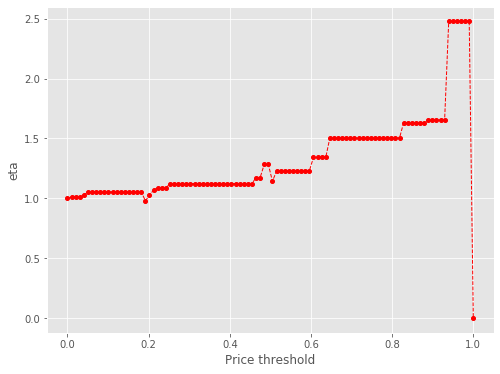

10286 21
Number of cells with price above 56.00000000000001th percentile:  21


eta =  1.0
eta =  1.0127827809681038
eta =  1.0127827809681038
eta =  1.0127827809681038
eta =  1.03176380114701
eta =  1.053117632911477
eta =  1.053117632911477
eta =  1.053117632911477
eta =  1.053117632911477
eta =  1.053117632911477
eta =  1.053117632911477
eta =  1.053117632911477
eta =  1.053117632911477
eta =  1.053117632911477
eta =  1.053117632911477
eta =  1.053117632911477
eta =  1.053117632911477
eta =  1.053117632911477
eta =  1.053117632911477
eta =  0.9799176025415165
eta =  1.0240748967845597
eta =  1.070045955393842
eta =  1.0856178652994615
eta =  1.0856178652994615
eta =  1.0856178652994615
eta =  1.1233086628620894
eta =  1.1233086628620894
eta =  1.1233086628620894
eta =  1.1233086628620894
eta =  1.1233086628620894
eta =  1.1233086628620894
eta =  1.1233086628620894
eta =  1.1233086628620894
eta =  1.1233086628620894
eta =  1.1233086628620894
eta =  1.1233086628620894
eta =  1.1233086628620894
eta =  1.1233086628620894
eta =  1.1233086628620894
eta =  1.123308662

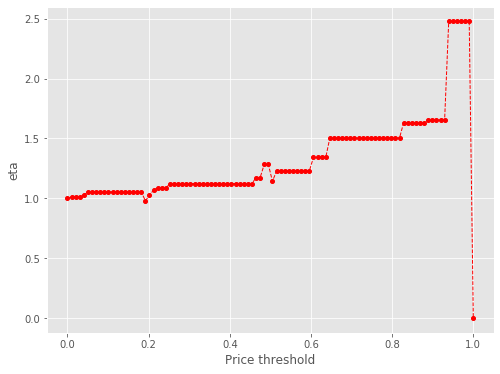

10286 20
Number of cells with price above 57.00000000000001th percentile:  20


eta =  1.0
eta =  1.0398257678757312
eta =  1.0398257678757312
eta =  1.0398257678757312
eta =  1.0398257678757312
eta =  1.0398257678757312
eta =  1.0398257678757312
eta =  1.0398257678757312
eta =  1.0398257678757312
eta =  1.0398257678757312
eta =  1.0398257678757312
eta =  1.0398257678757312
eta =  1.0398257678757312
eta =  1.0398257678757312
eta =  1.0398257678757312
eta =  1.0398257678757312
eta =  0.9675496275764365
eta =  1.0111495930111114
eta =  1.0565404304869808
eta =  1.071915800406614
eta =  1.071915800406614
eta =  1.071915800406614
eta =  1.1091308856854136
eta =  1.1091308856854136
eta =  1.1091308856854136
eta =  1.1091308856854136
eta =  1.1091308856854136
eta =  1.1091308856854136
eta =  1.1091308856854136
eta =  1.1091308856854136
eta =  1.1091308856854136
eta =  1.1091308856854136
eta =  1.1091308856854136
eta =  1.1091308856854136
eta =  1.1091308856854136
eta =  1.1091308856854136
eta =  1.1091308856854136
eta =  1.1091308856854136
eta =  1.1091308856854136
eta 

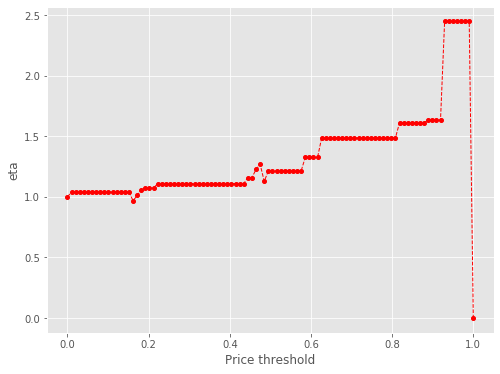

10286 20
Number of cells with price above 58.00000000000001th percentile:  20


eta =  1.0
eta =  1.0398257678757312
eta =  1.0398257678757312
eta =  1.0398257678757312
eta =  1.0398257678757312
eta =  1.0398257678757312
eta =  1.0398257678757312
eta =  1.0398257678757312
eta =  1.0398257678757312
eta =  1.0398257678757312
eta =  1.0398257678757312
eta =  1.0398257678757312
eta =  1.0398257678757312
eta =  1.0398257678757312
eta =  1.0398257678757312
eta =  1.0398257678757312
eta =  0.9675496275764365
eta =  1.0111495930111114
eta =  1.0565404304869808
eta =  1.071915800406614
eta =  1.071915800406614
eta =  1.071915800406614
eta =  1.1091308856854136
eta =  1.1091308856854136
eta =  1.1091308856854136
eta =  1.1091308856854136
eta =  1.1091308856854136
eta =  1.1091308856854136
eta =  1.1091308856854136
eta =  1.1091308856854136
eta =  1.1091308856854136
eta =  1.1091308856854136
eta =  1.1091308856854136
eta =  1.1091308856854136
eta =  1.1091308856854136
eta =  1.1091308856854136
eta =  1.1091308856854136
eta =  1.1091308856854136
eta =  1.1091308856854136
eta 

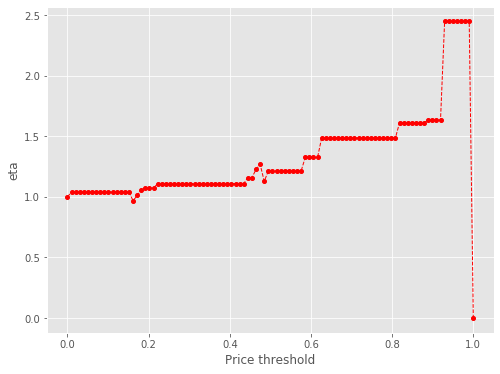

10286 18
Number of cells with price above 59.0th percentile:  18


eta =  1.0
eta =  0.9724221347935985
eta =  0.9724221347935985
eta =  1.0160744839449363
eta =  1.0308609706763083
eta =  1.0308609706763083
eta =  1.0308609706763083
eta =  1.0308609706763083
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.1145021544512086
eta =  1.1145021544512086
eta =  1.1145021544512086
eta =  1.1787711527701266
eta =  1.2191155667769555
eta =  1.084024715401799
et

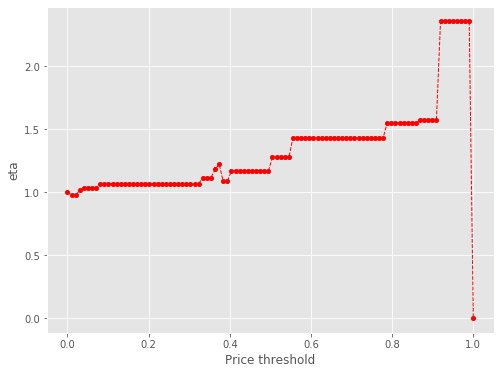

10286 18
Number of cells with price above 60.0th percentile:  18


eta =  1.0
eta =  0.9724221347935985
eta =  0.9724221347935985
eta =  1.0160744839449363
eta =  1.0308609706763083
eta =  1.0308609706763083
eta =  1.0308609706763083
eta =  1.0308609706763083
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.1145021544512086
eta =  1.1145021544512086
eta =  1.1145021544512086
eta =  1.1787711527701266
eta =  1.2191155667769555
eta =  1.084024715401799
et

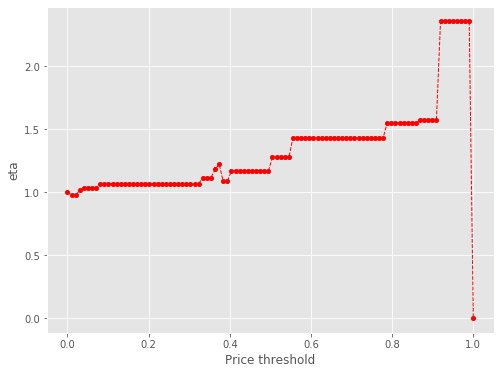

10286 18
Number of cells with price above 61.0th percentile:  18


eta =  1.0
eta =  0.9724221347935985
eta =  0.9724221347935985
eta =  1.0160744839449363
eta =  1.0308609706763083
eta =  1.0308609706763083
eta =  1.0308609706763083
eta =  1.0308609706763083
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.1145021544512086
eta =  1.1145021544512086
eta =  1.1145021544512086
eta =  1.1787711527701266
eta =  1.2191155667769555
eta =  1.084024715401799
et

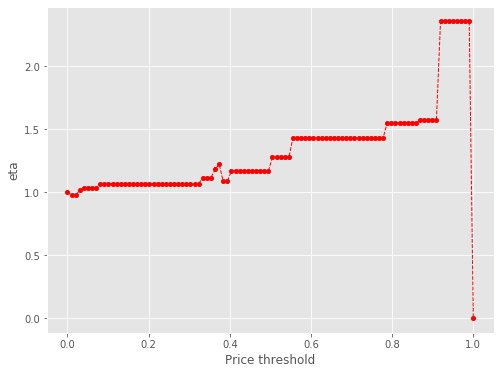

10286 18
Number of cells with price above 62.0th percentile:  18


eta =  1.0
eta =  0.9724221347935985
eta =  0.9724221347935985
eta =  1.0160744839449363
eta =  1.0308609706763083
eta =  1.0308609706763083
eta =  1.0308609706763083
eta =  1.0308609706763083
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.1145021544512086
eta =  1.1145021544512086
eta =  1.1145021544512086
eta =  1.1787711527701266
eta =  1.2191155667769555
eta =  1.084024715401799
et

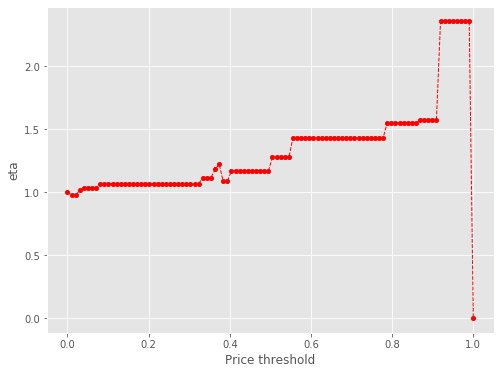

10286 18
Number of cells with price above 63.0th percentile:  18


eta =  1.0
eta =  0.9724221347935985
eta =  0.9724221347935985
eta =  1.0160744839449363
eta =  1.0308609706763083
eta =  1.0308609706763083
eta =  1.0308609706763083
eta =  1.0308609706763083
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.1145021544512086
eta =  1.1145021544512086
eta =  1.1145021544512086
eta =  1.1787711527701266
eta =  1.2191155667769555
eta =  1.084024715401799
et

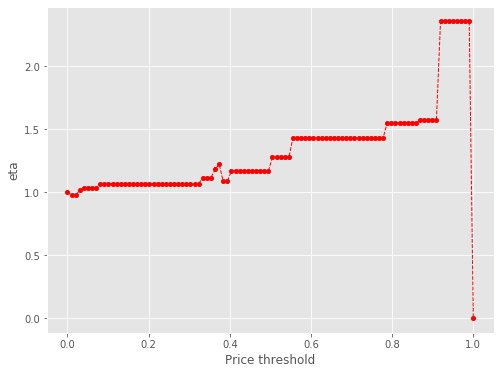

10286 18
Number of cells with price above 64.0th percentile:  18


eta =  1.0
eta =  0.9724221347935985
eta =  0.9724221347935985
eta =  1.0160744839449363
eta =  1.0308609706763083
eta =  1.0308609706763083
eta =  1.0308609706763083
eta =  1.0308609706763083
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.1145021544512086
eta =  1.1145021544512086
eta =  1.1145021544512086
eta =  1.1787711527701266
eta =  1.2191155667769555
eta =  1.084024715401799
et

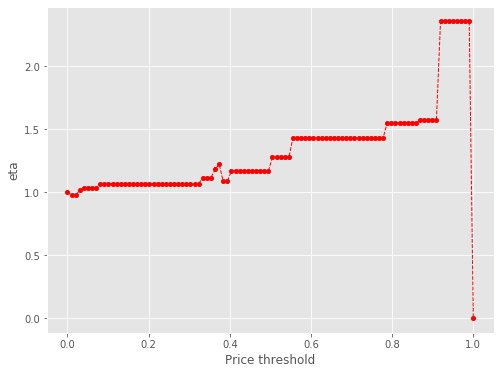

10286 18
Number of cells with price above 65.0th percentile:  18


eta =  1.0
eta =  0.9724221347935985
eta =  0.9724221347935985
eta =  1.0160744839449363
eta =  1.0308609706763083
eta =  1.0308609706763083
eta =  1.0308609706763083
eta =  1.0308609706763083
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.0666507024068719
eta =  1.1145021544512086
eta =  1.1145021544512086
eta =  1.1145021544512086
eta =  1.1787711527701266
eta =  1.2191155667769555
eta =  1.084024715401799
et

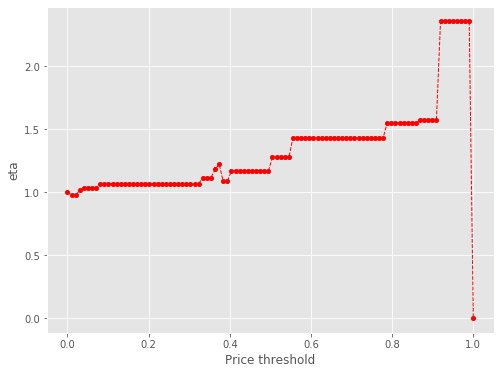

10286 14
Number of cells with price above 66.0th percentile:  14


eta =  1.0
eta =  1.0145525618101965
eta =  1.0145525618101965
eta =  1.0145525618101965
eta =  1.0145525618101965
eta =  1.0497760934469806
eta =  1.0497760934469806
eta =  1.0497760934469806
eta =  1.0497760934469806
eta =  1.0497760934469806
eta =  1.0497760934469806
eta =  1.0497760934469806
eta =  1.0497760934469806
eta =  1.0497760934469806
eta =  1.0497760934469806
eta =  1.0497760934469806
eta =  1.0497760934469806
eta =  1.0497760934469806
eta =  1.0497760934469806
eta =  1.0497760934469806
eta =  1.0497760934469806
eta =  1.0497760934469806
eta =  1.0497760934469806
eta =  1.0497760934469806
eta =  1.0497760934469806
eta =  1.0497760934469806
eta =  1.0497760934469806
eta =  1.0497760934469806
eta =  1.0497760934469806
eta =  1.0497760934469806
eta =  1.0497760934469806
eta =  1.0968705267788283
eta =  1.0968705267788283
eta =  1.0968705267788283
eta =  1.1601227778041587
eta =  1.1998289358115823
eta =  1.0668752463825724
eta =  1.0668752463825724
eta =  1.1488332575015514
e

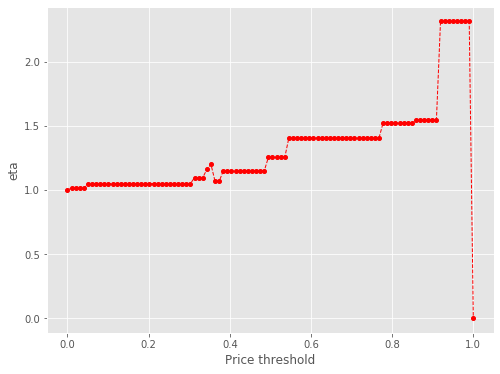

10286 13
Number of cells with price above 67.0th percentile:  13


eta =  1.0
eta =  1.0347182915530144
eta =  1.0347182915530144
eta =  1.0347182915530144
eta =  1.0347182915530144
eta =  1.0347182915530144
eta =  1.0347182915530144
eta =  1.0347182915530144
eta =  1.0347182915530144
eta =  1.0347182915530144
eta =  1.0347182915530144
eta =  1.0347182915530144
eta =  1.0347182915530144
eta =  1.0347182915530144
eta =  1.0347182915530144
eta =  1.0347182915530144
eta =  1.0347182915530144
eta =  1.0347182915530144
eta =  1.0347182915530144
eta =  1.0347182915530144
eta =  1.0347182915530144
eta =  1.0347182915530144
eta =  1.0347182915530144
eta =  1.0347182915530144
eta =  1.0347182915530144
eta =  1.0347182915530144
eta =  1.0347182915530144
eta =  1.0347182915530144
eta =  1.0811372106948878
eta =  1.0811372106948878
eta =  1.0811372106948878
eta =  1.14348218266211
eta =  1.1826188025890054
eta =  1.0515721772748967
eta =  1.0515721772748967
eta =  1.13235459723424
eta =  1.13235459723424
eta =  1.13235459723424
eta =  1.13235459723424
eta =  1.13

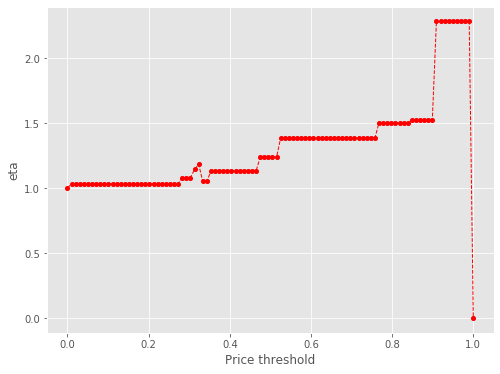

10286 12
Number of cells with price above 68.0th percentile:  12


eta =  1.0
eta =  1.044861407709535
eta =  1.044861407709535
eta =  1.044861407709535
eta =  1.044861407709535
eta =  1.1051144954109695
eta =  1.1429379496268557
eta =  1.1429379496268557
eta =  1.0162883809626928
eta =  1.0162883809626928
eta =  1.0162883809626928
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.1941481441363795
eta =  1.1941481441363795
eta =  1.1941481441363795
eta =  1.1941481441363795
eta =  1.1941481441363795
eta =  1.1941481441363795
eta =  1.1941481441363795
eta =  1.3394884726921634
eta =  1.3394884726921634
eta =  1.3394884726921634
eta =  1.3394884726921634
eta =  1.3394884726921634
eta =  1.3394884726921634
eta =  1.33948847269

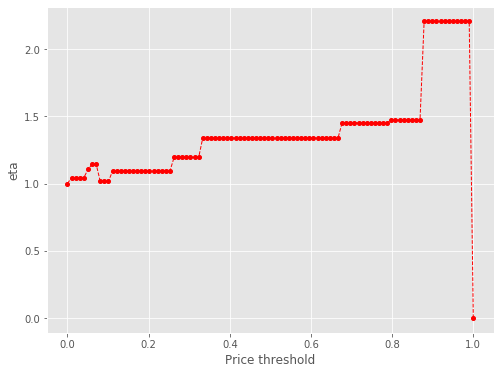

10286 12
Number of cells with price above 69.0th percentile:  12


eta =  1.0
eta =  1.044861407709535
eta =  1.044861407709535
eta =  1.044861407709535
eta =  1.044861407709535
eta =  1.1051144954109695
eta =  1.1429379496268557
eta =  1.1429379496268557
eta =  1.0162883809626928
eta =  1.0162883809626928
eta =  1.0162883809626928
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.1941481441363795
eta =  1.1941481441363795
eta =  1.1941481441363795
eta =  1.1941481441363795
eta =  1.1941481441363795
eta =  1.1941481441363795
eta =  1.1941481441363795
eta =  1.3394884726921634
eta =  1.3394884726921634
eta =  1.3394884726921634
eta =  1.3394884726921634
eta =  1.3394884726921634
eta =  1.3394884726921634
eta =  1.33948847269

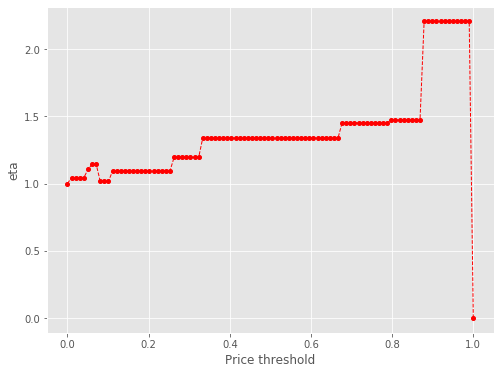

10286 12
Number of cells with price above 70.0th percentile:  12


eta =  1.0
eta =  1.044861407709535
eta =  1.044861407709535
eta =  1.044861407709535
eta =  1.044861407709535
eta =  1.1051144954109695
eta =  1.1429379496268557
eta =  1.1429379496268557
eta =  1.0162883809626928
eta =  1.0162883809626928
eta =  1.0162883809626928
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.1941481441363795
eta =  1.1941481441363795
eta =  1.1941481441363795
eta =  1.1941481441363795
eta =  1.1941481441363795
eta =  1.1941481441363795
eta =  1.1941481441363795
eta =  1.3394884726921634
eta =  1.3394884726921634
eta =  1.3394884726921634
eta =  1.3394884726921634
eta =  1.3394884726921634
eta =  1.3394884726921634
eta =  1.33948847269

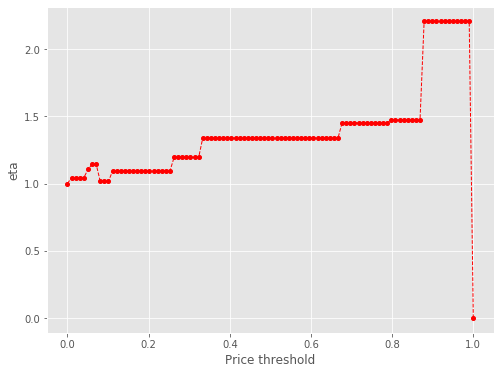

10286 12
Number of cells with price above 71.00000000000001th percentile:  12


eta =  1.0
eta =  1.044861407709535
eta =  1.044861407709535
eta =  1.044861407709535
eta =  1.044861407709535
eta =  1.1051144954109695
eta =  1.1429379496268557
eta =  1.1429379496268557
eta =  1.0162883809626928
eta =  1.0162883809626928
eta =  1.0162883809626928
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.1941481441363795
eta =  1.1941481441363795
eta =  1.1941481441363795
eta =  1.1941481441363795
eta =  1.1941481441363795
eta =  1.1941481441363795
eta =  1.1941481441363795
eta =  1.3394884726921634
eta =  1.3394884726921634
eta =  1.3394884726921634
eta =  1.3394884726921634
eta =  1.3394884726921634
eta =  1.3394884726921634
eta =  1.33948847269

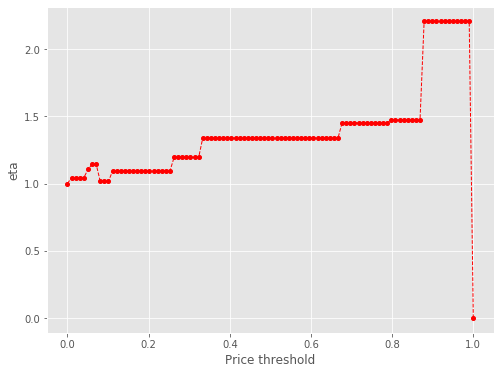

10286 12
Number of cells with price above 72.0th percentile:  12


eta =  1.0
eta =  1.044861407709535
eta =  1.044861407709535
eta =  1.044861407709535
eta =  1.044861407709535
eta =  1.1051144954109695
eta =  1.1429379496268557
eta =  1.1429379496268557
eta =  1.0162883809626928
eta =  1.0162883809626928
eta =  1.0162883809626928
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.1941481441363795
eta =  1.1941481441363795
eta =  1.1941481441363795
eta =  1.1941481441363795
eta =  1.1941481441363795
eta =  1.1941481441363795
eta =  1.1941481441363795
eta =  1.3394884726921634
eta =  1.3394884726921634
eta =  1.3394884726921634
eta =  1.3394884726921634
eta =  1.3394884726921634
eta =  1.3394884726921634
eta =  1.33948847269

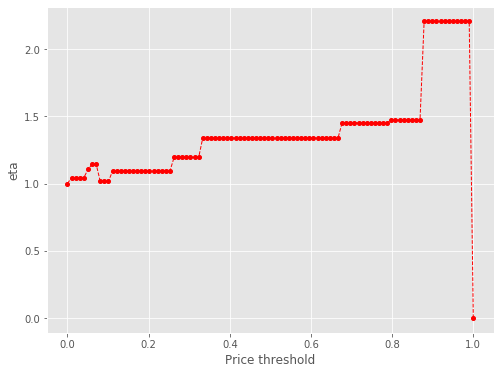

10286 12
Number of cells with price above 73.0th percentile:  12


eta =  1.0
eta =  1.044861407709535
eta =  1.044861407709535
eta =  1.044861407709535
eta =  1.044861407709535
eta =  1.1051144954109695
eta =  1.1429379496268557
eta =  1.1429379496268557
eta =  1.0162883809626928
eta =  1.0162883809626928
eta =  1.0162883809626928
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.1941481441363795
eta =  1.1941481441363795
eta =  1.1941481441363795
eta =  1.1941481441363795
eta =  1.1941481441363795
eta =  1.1941481441363795
eta =  1.1941481441363795
eta =  1.3394884726921634
eta =  1.3394884726921634
eta =  1.3394884726921634
eta =  1.3394884726921634
eta =  1.3394884726921634
eta =  1.3394884726921634
eta =  1.33948847269

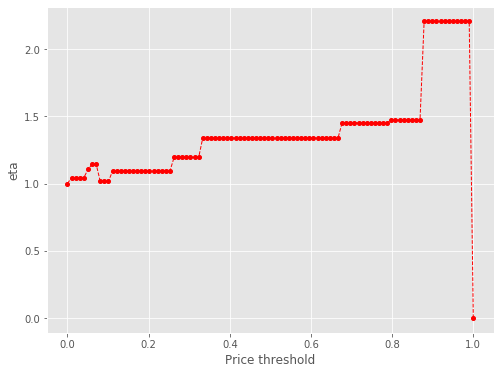

10286 12
Number of cells with price above 74.0th percentile:  12


eta =  1.0
eta =  1.044861407709535
eta =  1.044861407709535
eta =  1.044861407709535
eta =  1.044861407709535
eta =  1.1051144954109695
eta =  1.1429379496268557
eta =  1.1429379496268557
eta =  1.0162883809626928
eta =  1.0162883809626928
eta =  1.0162883809626928
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.1941481441363795
eta =  1.1941481441363795
eta =  1.1941481441363795
eta =  1.1941481441363795
eta =  1.1941481441363795
eta =  1.1941481441363795
eta =  1.1941481441363795
eta =  1.3394884726921634
eta =  1.3394884726921634
eta =  1.3394884726921634
eta =  1.3394884726921634
eta =  1.3394884726921634
eta =  1.3394884726921634
eta =  1.33948847269

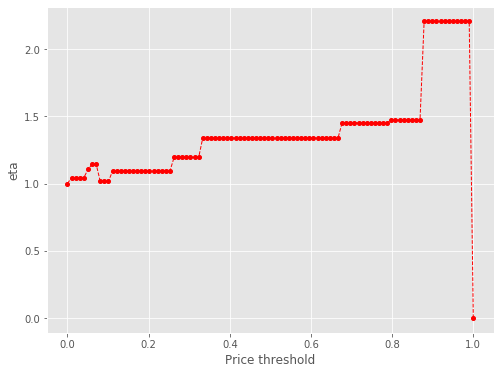

10286 12
Number of cells with price above 75.0th percentile:  12


eta =  1.0
eta =  1.044861407709535
eta =  1.044861407709535
eta =  1.044861407709535
eta =  1.044861407709535
eta =  1.1051144954109695
eta =  1.1429379496268557
eta =  1.1429379496268557
eta =  1.0162883809626928
eta =  1.0162883809626928
eta =  1.0162883809626928
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.1941481441363795
eta =  1.1941481441363795
eta =  1.1941481441363795
eta =  1.1941481441363795
eta =  1.1941481441363795
eta =  1.1941481441363795
eta =  1.1941481441363795
eta =  1.3394884726921634
eta =  1.3394884726921634
eta =  1.3394884726921634
eta =  1.3394884726921634
eta =  1.3394884726921634
eta =  1.3394884726921634
eta =  1.33948847269

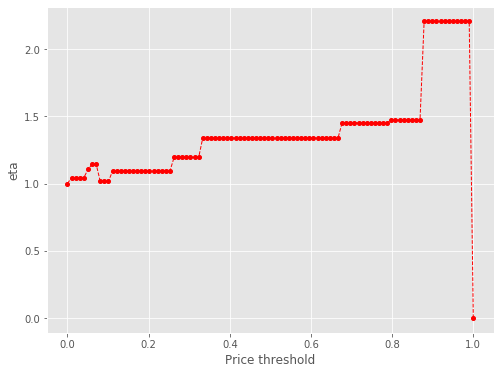

10286 12
Number of cells with price above 76.0th percentile:  12


eta =  1.0
eta =  1.044861407709535
eta =  1.044861407709535
eta =  1.044861407709535
eta =  1.044861407709535
eta =  1.1051144954109695
eta =  1.1429379496268557
eta =  1.1429379496268557
eta =  1.0162883809626928
eta =  1.0162883809626928
eta =  1.0162883809626928
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.094360278037303
eta =  1.1941481441363795
eta =  1.1941481441363795
eta =  1.1941481441363795
eta =  1.1941481441363795
eta =  1.1941481441363795
eta =  1.1941481441363795
eta =  1.1941481441363795
eta =  1.3394884726921634
eta =  1.3394884726921634
eta =  1.3394884726921634
eta =  1.3394884726921634
eta =  1.3394884726921634
eta =  1.3394884726921634
eta =  1.33948847269

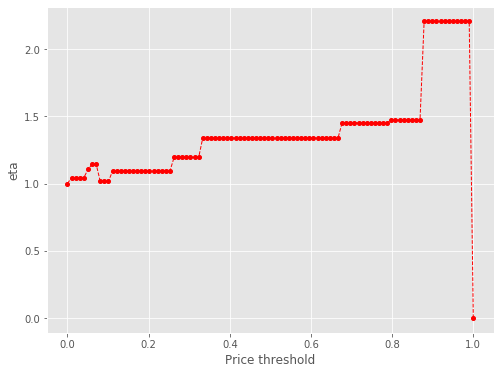

10286 11
Number of cells with price above 77.0th percentile:  11


eta =  1.0
eta =  1.0938655990102233
eta =  1.0938655990102233
eta =  1.0938655990102233
eta =  0.9726537639001542
eta =  0.9726537639001542
eta =  1.0473736229154789
eta =  1.0473736229154789
eta =  1.0473736229154789
eta =  1.0473736229154789
eta =  1.0473736229154789
eta =  1.0473736229154789
eta =  1.0473736229154789
eta =  1.0473736229154789
eta =  1.0473736229154789
eta =  1.0473736229154789
eta =  1.0473736229154789
eta =  1.0473736229154789
eta =  1.0473736229154789
eta =  1.0473736229154789
eta =  1.0473736229154789
eta =  1.0473736229154789
eta =  1.0473736229154789
eta =  1.1428770699399258
eta =  1.1428770699399258
eta =  1.1428770699399258
eta =  1.1428770699399258
eta =  1.1428770699399258
eta =  1.1428770699399258
eta =  1.1428770699399258
eta =  1.281977172100257
eta =  1.281977172100257
eta =  1.281977172100257
eta =  1.281977172100257
eta =  1.281977172100257
eta =  1.281977172100257
eta =  1.281977172100257
eta =  1.281977172100257
eta =  1.281977172100257
eta =  1.2

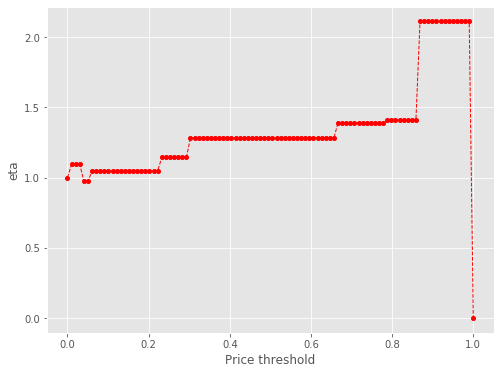

10286 9
Number of cells with price above 78.0th percentile:  9


eta =  1.0
eta =  0.8891894623802533
eta =  0.8891894623802533
eta =  0.9574975425346475
eta =  0.9574975425346475
eta =  0.9574975425346475
eta =  0.9574975425346475
eta =  0.9574975425346475
eta =  0.9574975425346475
eta =  0.9574975425346475
eta =  0.9574975425346475
eta =  0.9574975425346475
eta =  0.9574975425346475
eta =  0.9574975425346475
eta =  0.9574975425346475
eta =  0.9574975425346475
eta =  0.9574975425346475
eta =  0.9574975425346475
eta =  0.9574975425346475
eta =  0.9574975425346475
eta =  1.0448057521637484
eta =  1.0448057521637484
eta =  1.0448057521637484
eta =  1.0448057521637484
eta =  1.0448057521637484
eta =  1.0448057521637484
eta =  1.0448057521637484
eta =  1.0448057521637484
eta =  1.1719695484164099
eta =  1.1719695484164099
eta =  1.1719695484164099
eta =  1.1719695484164099
eta =  1.1719695484164099
eta =  1.1719695484164099
eta =  1.1719695484164099
eta =  1.1719695484164099
eta =  1.1719695484164099
eta =  1.1719695484164099
eta =  1.1719695484164099
e

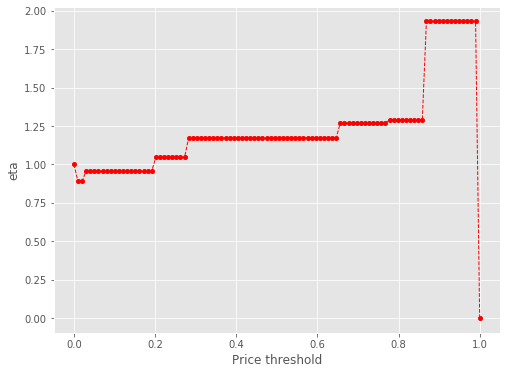

10286 7
Number of cells with price above 79.0th percentile:  7


eta =  1.0
eta =  1.091183742778057
eta =  1.091183742778057
eta =  1.091183742778057
eta =  1.091183742778057
eta =  1.091183742778057
eta =  1.091183742778057
eta =  1.091183742778057
eta =  1.091183742778057
eta =  1.091183742778057
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2

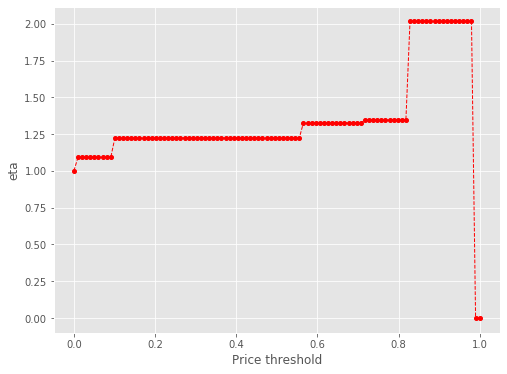

10286 7
Number of cells with price above 80.0th percentile:  7


eta =  1.0
eta =  1.091183742778057
eta =  1.091183742778057
eta =  1.091183742778057
eta =  1.091183742778057
eta =  1.091183742778057
eta =  1.091183742778057
eta =  1.091183742778057
eta =  1.091183742778057
eta =  1.091183742778057
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2

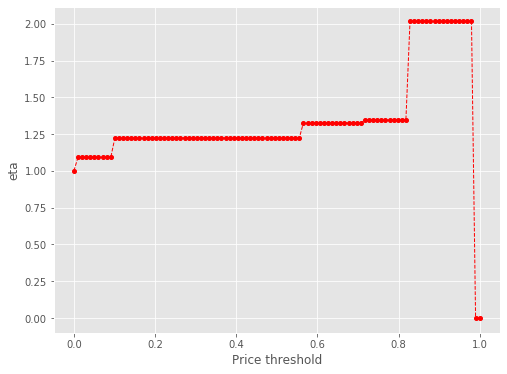

10286 7
Number of cells with price above 81.0th percentile:  7


eta =  1.0
eta =  1.091183742778057
eta =  1.091183742778057
eta =  1.091183742778057
eta =  1.091183742778057
eta =  1.091183742778057
eta =  1.091183742778057
eta =  1.091183742778057
eta =  1.091183742778057
eta =  1.091183742778057
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2

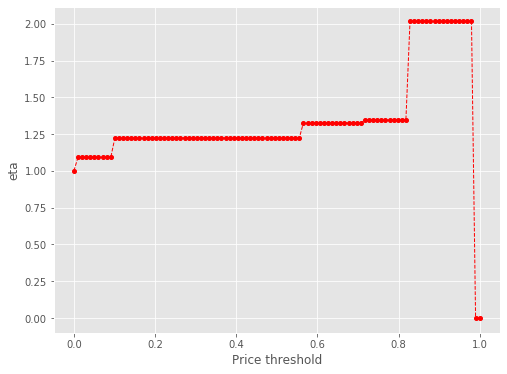

10286 7
Number of cells with price above 82.0th percentile:  7


eta =  1.0
eta =  1.091183742778057
eta =  1.091183742778057
eta =  1.091183742778057
eta =  1.091183742778057
eta =  1.091183742778057
eta =  1.091183742778057
eta =  1.091183742778057
eta =  1.091183742778057
eta =  1.091183742778057
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2239922259372291
eta =  1.2

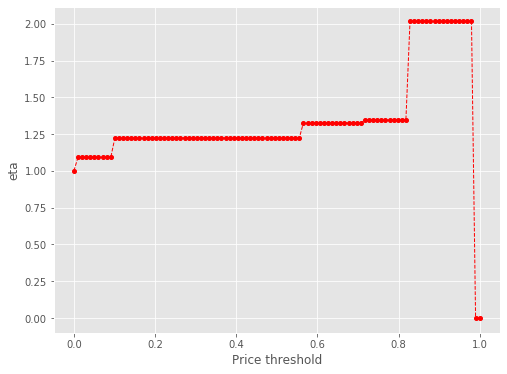

10286 6
Number of cells with price above 83.0th percentile:  6


eta =  1.0
eta =  1.1217104672225535
eta =  1.1217104672225535
eta =  1.1217104672225535
eta =  1.1217104672225535
eta =  1.1217104672225535
eta =  1.1217104672225535
eta =  1.1217104672225535
eta =  1.1217104672225535
eta =  1.1217104672225535
eta =  1.1217104672225535
eta =  1.1217104672225535
eta =  1.1217104672225535
eta =  1.1217104672225535
eta =  1.1217104672225535
eta =  1.1217104672225535
eta =  1.1217104672225535
eta =  1.1217104672225535
eta =  1.1217104672225535
eta =  1.1217104672225535
eta =  1.1217104672225535
eta =  1.1217104672225535
eta =  1.1217104672225535
eta =  1.1217104672225535
eta =  1.1217104672225535
eta =  1.1217104672225535
eta =  1.1217104672225535
eta =  1.1217104672225535
eta =  1.1217104672225535
eta =  1.1217104672225535
eta =  1.1217104672225535
eta =  1.1217104672225535
eta =  1.1217104672225535
eta =  1.1217104672225535
eta =  1.1217104672225535
eta =  1.1217104672225535
eta =  1.1217104672225535
eta =  1.1217104672225535
eta =  1.1217104672225535
e

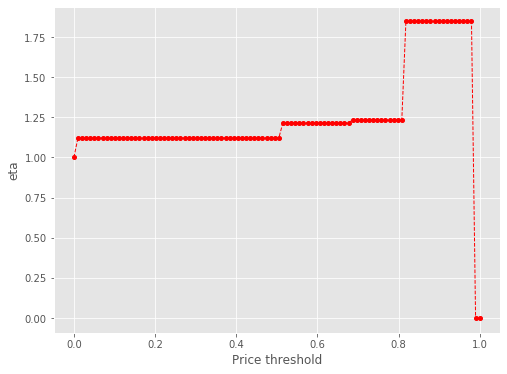

10286 6
Number of cells with price above 84.00000000000001th percentile:  6


eta =  1.0
eta =  1.1217104672225535
eta =  1.1217104672225535
eta =  1.1217104672225535
eta =  1.1217104672225535
eta =  1.1217104672225535
eta =  1.1217104672225535
eta =  1.1217104672225535
eta =  1.1217104672225535
eta =  1.1217104672225535
eta =  1.1217104672225535
eta =  1.1217104672225535
eta =  1.1217104672225535
eta =  1.1217104672225535
eta =  1.1217104672225535
eta =  1.1217104672225535
eta =  1.1217104672225535
eta =  1.1217104672225535
eta =  1.1217104672225535
eta =  1.1217104672225535
eta =  1.1217104672225535
eta =  1.1217104672225535
eta =  1.1217104672225535
eta =  1.1217104672225535
eta =  1.1217104672225535
eta =  1.1217104672225535
eta =  1.1217104672225535
eta =  1.1217104672225535
eta =  1.1217104672225535
eta =  1.1217104672225535
eta =  1.1217104672225535
eta =  1.1217104672225535
eta =  1.1217104672225535
eta =  1.1217104672225535
eta =  1.1217104672225535
eta =  1.1217104672225535
eta =  1.1217104672225535
eta =  1.1217104672225535
eta =  1.1217104672225535
e

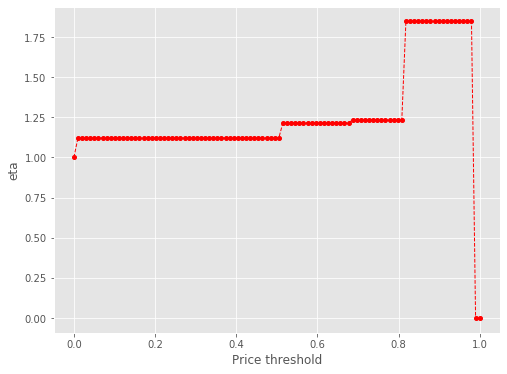

10286 5
Number of cells with price above 85.0th percentile:  5


eta =  1.0
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.09967406826063
eta =  1.09967406826063
eta =  1.09967406826063
eta =  1.09967406826063
eta =  1.09967406826063
eta =  1.0996740682

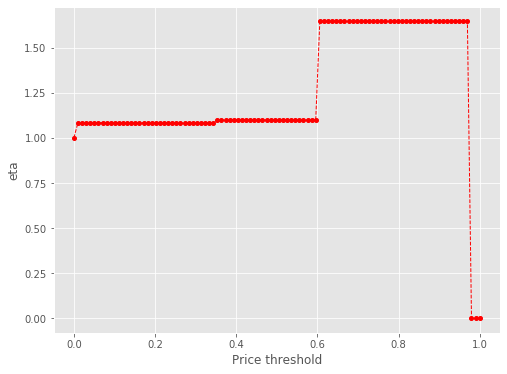

10286 5
Number of cells with price above 86.0th percentile:  5


eta =  1.0
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.09967406826063
eta =  1.09967406826063
eta =  1.09967406826063
eta =  1.09967406826063
eta =  1.09967406826063
eta =  1.0996740682

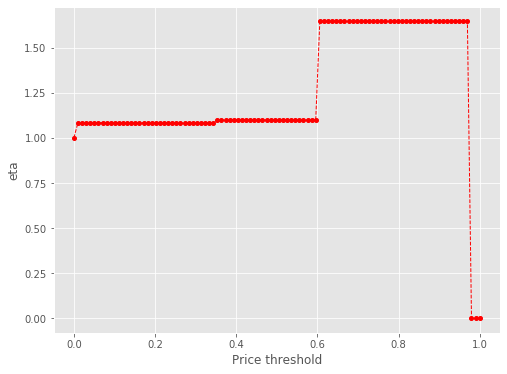

10286 5
Number of cells with price above 87.0th percentile:  5


eta =  1.0
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.09967406826063
eta =  1.09967406826063
eta =  1.09967406826063
eta =  1.09967406826063
eta =  1.09967406826063
eta =  1.0996740682

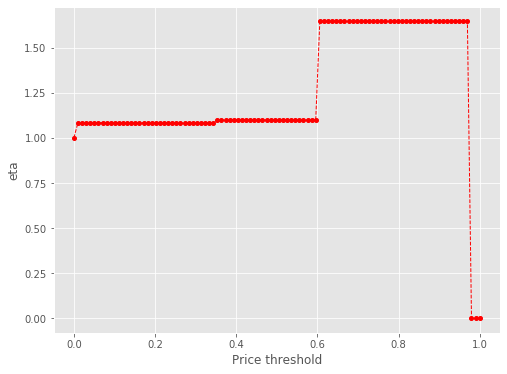

10286 5
Number of cells with price above 88.0th percentile:  5


eta =  1.0
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.09967406826063
eta =  1.09967406826063
eta =  1.09967406826063
eta =  1.09967406826063
eta =  1.09967406826063
eta =  1.0996740682

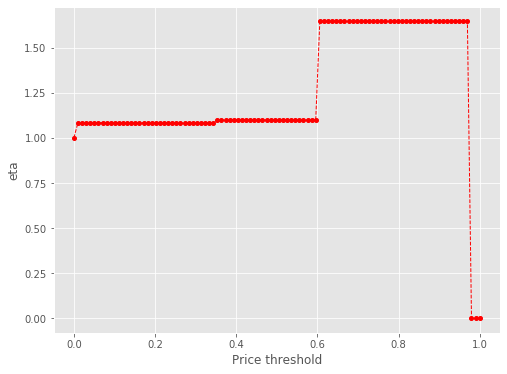

10286 5
Number of cells with price above 89.0th percentile:  5


eta =  1.0
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.09967406826063
eta =  1.09967406826063
eta =  1.09967406826063
eta =  1.09967406826063
eta =  1.09967406826063
eta =  1.0996740682

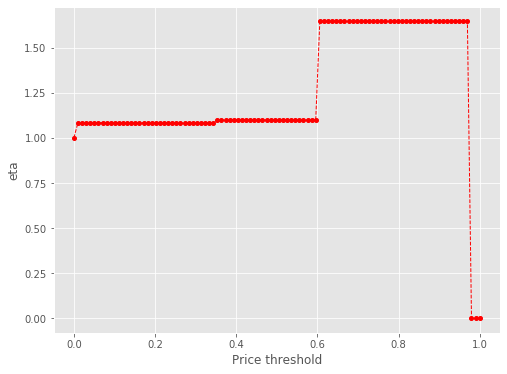

10286 5
Number of cells with price above 90.0th percentile:  5


eta =  1.0
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.09967406826063
eta =  1.09967406826063
eta =  1.09967406826063
eta =  1.09967406826063
eta =  1.09967406826063
eta =  1.0996740682

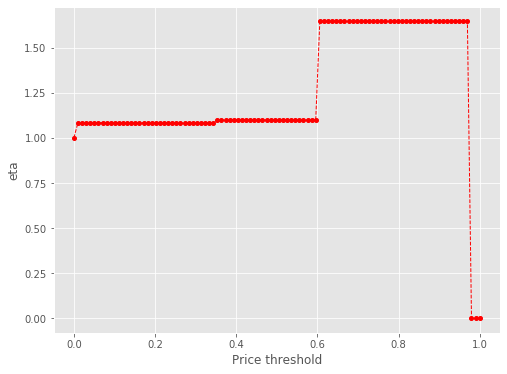

10286 5
Number of cells with price above 91.0th percentile:  5


eta =  1.0
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.09967406826063
eta =  1.09967406826063
eta =  1.09967406826063
eta =  1.09967406826063
eta =  1.09967406826063
eta =  1.0996740682

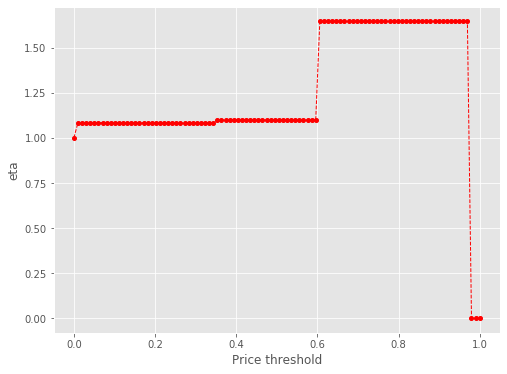

10286 5
Number of cells with price above 92.0th percentile:  5


eta =  1.0
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.084420950405963
eta =  1.09967406826063
eta =  1.09967406826063
eta =  1.09967406826063
eta =  1.09967406826063
eta =  1.09967406826063
eta =  1.0996740682

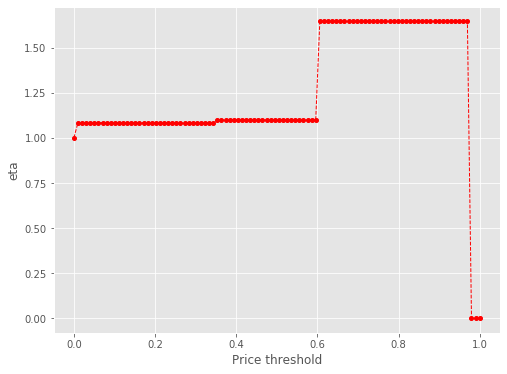

10286 4
Number of cells with price above 93.0th percentile:  4


eta =  1.0
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.51868

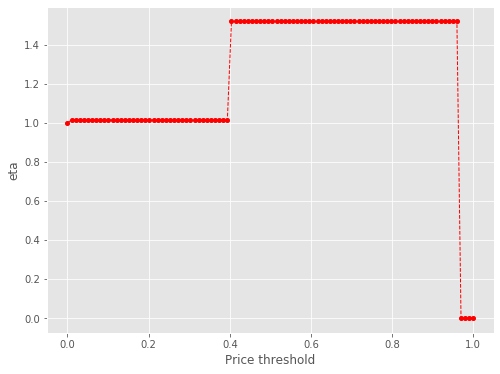

10286 4
Number of cells with price above 94.0th percentile:  4


eta =  1.0
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.51868

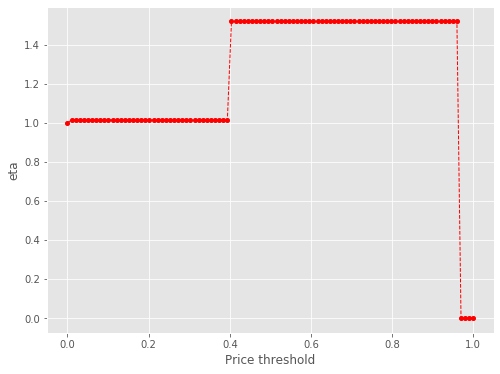

10286 4
Number of cells with price above 95.0th percentile:  4


eta =  1.0
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.014065679798013
eta =  1.51868

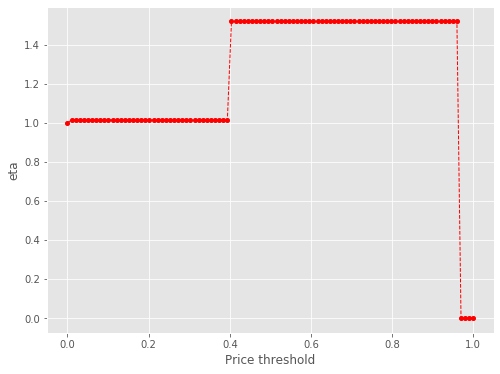

10286 3
Number of cells with price above 96.00000000000001th percentile:  3


eta =  1.0
eta =  1.4976216318666506
eta =  1.4976216318666506
eta =  1.4976216318666506
eta =  1.4976216318666506
eta =  1.4976216318666506
eta =  1.4976216318666506
eta =  1.4976216318666506
eta =  1.4976216318666506
eta =  1.4976216318666506
eta =  1.4976216318666506
eta =  1.4976216318666506
eta =  1.4976216318666506
eta =  1.4976216318666506
eta =  1.4976216318666506
eta =  1.4976216318666506
eta =  1.4976216318666506
eta =  1.4976216318666506
eta =  1.4976216318666506
eta =  1.4976216318666506
eta =  1.4976216318666506
eta =  1.4976216318666506
eta =  1.4976216318666506
eta =  1.4976216318666506
eta =  1.4976216318666506
eta =  1.4976216318666506
eta =  1.4976216318666506
eta =  1.4976216318666506
eta =  1.4976216318666506
eta =  1.4976216318666506
eta =  1.4976216318666506
eta =  1.4976216318666506
eta =  1.4976216318666506
eta =  1.4976216318666506
eta =  1.4976216318666506
eta =  1.4976216318666506
eta =  1.4976216318666506
eta =  1.4976216318666506
eta =  1.4976216318666506
e

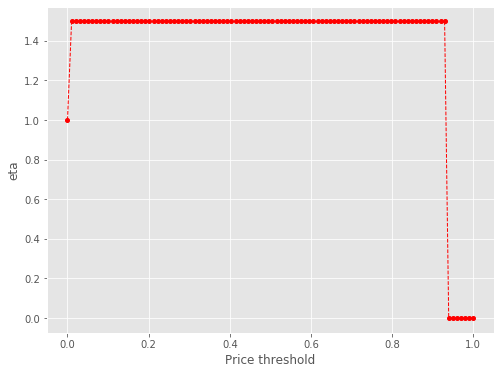

10286 3
Number of cells with price above 97.0th percentile:  3


eta =  1.0
eta =  1.4976216318666506
eta =  1.4976216318666506
eta =  1.4976216318666506
eta =  1.4976216318666506
eta =  1.4976216318666506
eta =  1.4976216318666506
eta =  1.4976216318666506
eta =  1.4976216318666506
eta =  1.4976216318666506
eta =  1.4976216318666506
eta =  1.4976216318666506
eta =  1.4976216318666506
eta =  1.4976216318666506
eta =  1.4976216318666506
eta =  1.4976216318666506
eta =  1.4976216318666506
eta =  1.4976216318666506
eta =  1.4976216318666506
eta =  1.4976216318666506
eta =  1.4976216318666506
eta =  1.4976216318666506
eta =  1.4976216318666506
eta =  1.4976216318666506
eta =  1.4976216318666506
eta =  1.4976216318666506
eta =  1.4976216318666506
eta =  1.4976216318666506
eta =  1.4976216318666506
eta =  1.4976216318666506
eta =  1.4976216318666506
eta =  1.4976216318666506
eta =  1.4976216318666506
eta =  1.4976216318666506
eta =  1.4976216318666506
eta =  1.4976216318666506
eta =  1.4976216318666506
eta =  1.4976216318666506
eta =  1.4976216318666506
e

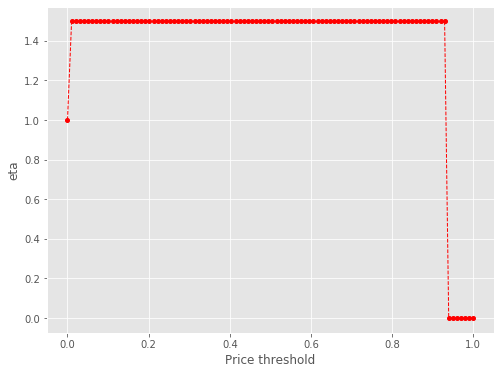

10286 2
Number of cells with price above 98.0th percentile:  2


eta =  1.0
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

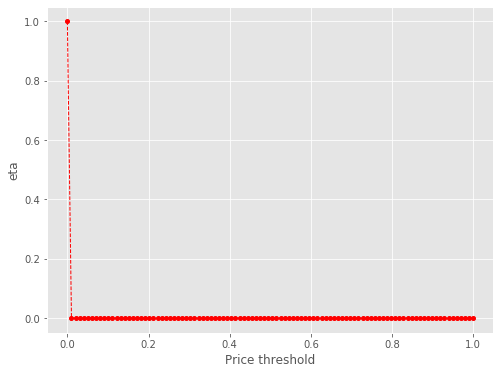

10286 2
Number of cells with price above 99.0th percentile:  2


eta =  1.0
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

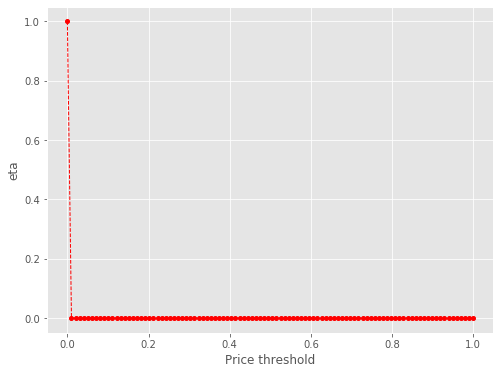

10286 1
Number of cells with price above 100.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning:

invalid value encountered in true_divide



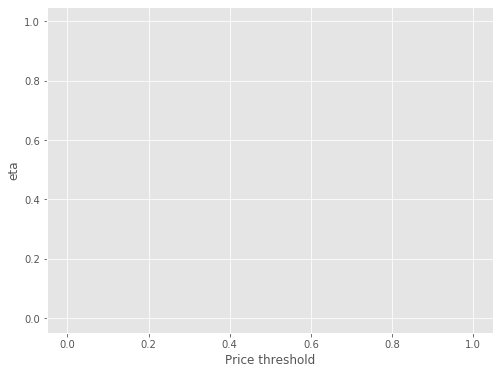


time: 1min 5s


In [28]:
lorentz_vals = poly_prices.zpred.to_dict()
s = [(k, lorentz_vals[k]) for k in sorted(lorentz_vals, key=lorentz_vals.get)]
keys = []
vals = []
for k,v in s:
    keys.append(k)
    vals.append(v)
    

vals = np.array(vals)
#keys = np.array(keys)
keys_initial = np.array(keys)


perc_vals = np.linspace(0.01, 1, 100)
etas_2d = []
for i in tqdm_notebook(perc_vals):
    keys = keys_initial
    vals_cut = vals[vals>=i*vals.max()]
    print(len(vals), len(vals_cut))

    L = np.cumsum(vals_cut)/np.sum(vals_cut)
    keys = keys[vals>=i*vals.max()]
    print('Number of cells with price above {}th percentile: '.format(i*100), len(keys))
    etas = []
    lval = np.linspace(min(vals_cut), max(vals_cut), 100)
    for k in tqdm_notebook(lval):
        loubar_keys = keys[vals_cut>=k]
        dist_mat = mat[keys.reshape(-1,1), keys]

        total_dist = dist_mat.sum()
        dist_corr = dist_mat[dist_mat>0]

        loubar_dist_mat = mat[loubar_keys.reshape(-1,1), loubar_keys]

        loubar_dist = loubar_dist_mat.sum()

        loubar_dist_corr = loubar_dist_mat[loubar_dist_mat>0]
        eta = loubar_dist_corr.mean()/dist_corr.mean()
        etas.append(eta)
        print('eta = ', eta)
    etas_array = np.array(etas)
    etas_array = np.where(np.isnan(etas_array), 0, etas_array)
    lval = (lval - lval.min())/(lval - lval.min()).max()
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(lval, etas_array, color='r', linestyle='--', marker='o', markersize=4, linewidth=1)
    plt.xlabel("Price threshold")
    plt.ylabel("eta")
    plt.show()
    etas_2d.append(etas)
etas_2d = np.array(etas_2d)
etas_2d = np.where(np.isnan(etas_2d), 0, etas_2d)
lval = lval/lval.max()

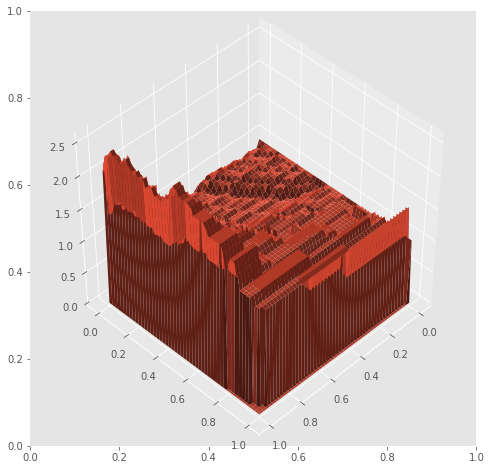

time: 1.04 s


In [29]:
X,Y = np.meshgrid(np.linspace(0,1, 100),np.linspace(0,1, 100))
etas_surface = etas_2d
fig, ax = plt.subplots(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
# Plot a 3D surface
ax.plot_surface(X, Y, etas_surface)
ax.view_init(45, 45)
plt.show()

In [30]:
pickle_in = open("etas_surface_dict.pickle","rb")
etas_surface_dict = pickle.load(pickle_in)
#etas_surface_dict = {}
etas_surface_dict['Busan'] = etas_surface


pickle_out = open("etas_surface_dict.pickle","wb")
pickle.dump(etas_surface_dict, pickle_out)
pickle_out.close()

etas_surface_dict

{'NY': array([[1.        , 0.40697941, 0.38848337, ..., 0.        , 0.        ,
         0.        ],
        [1.        , 0.95418349, 0.92471336, ..., 0.        , 0.        ,
         0.        ],
        [1.        , 0.96911482, 0.94572765, ..., 0.        , 0.        ,
         0.        ],
        ...,
        [1.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]]),
 'Boston': array([[1.        , 0.94621367, 0.92299712, ..., 0.        , 0.        ,
         0.        ],
        [1.        , 0.97340556, 0.95206791, ..., 0.        , 0.        ,
         0.        ],
        [1.        , 0.96708982, 0.94781127, ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.       

time: 22 ms


10286 106
Number of cells with price above 5th percentile:  106
total number of cells:  10286
number of cells within urban airbnb territory:  106


Distance list length NOT equal to # of centers

Mean travel times in minutes:  8.424693264693264
Mean travel times in minutes:  20.963243329043326
Mean travel times in minutes:  37.017313856713855
Mean travel times in minutes:  56.57721660231661
Mean travel times in minutes:  66.69073612183611


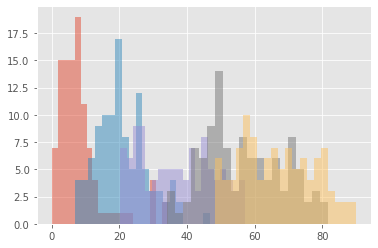

time: 52.9 s


In [37]:
from tqdm import tqdm_notebook

lorentz_vals = poly_prices.zpred.to_dict()
s = [(k, lorentz_vals[k]) for k in sorted(lorentz_vals, key=lorentz_vals.get)]
keys = []
vals = []
for k,v in s:
    keys.append(k)
    vals.append(v)
    

vals = np.array(vals)
keys = np.array(keys)

vals_cut = vals[vals>0.05*vals.max()]
print(len(vals), len(vals_cut))

L = np.cumsum(vals_cut)/np.sum(vals_cut)
keys = keys[vals>0.05*vals.max()]
print('Number of cells with price above 5th percentile: ', len(keys))

print('total number of cells: ', len(polylist))

times_names = ['times_{}'.format(c) for c in range(1, len(centers)+1)]
times_dict = {name:[] for name in times_names}

plist = poly_prices[poly_prices.index.isin(keys)].geometry.tolist()
print('number of cells within urban airbnb territory: ', len(plist))
for poly in tqdm_notebook(plist):
    origin = ox.get_nearest_node(G, poly.centroid.coords[0][::-1])
    dists_to_centers = []
    for node, target in centers.items():
        try:
            if origin!=target:
                path = nx.shortest_path(G, origin, target, weight='length')
                edges = [ tuple( path[i:i+2] ) for i in range( len(path) - 1 ) ]
                dist = np.sum([G.get_edge_data(*edge)[0]['length'] for edge in edges])
                dists_to_centers.append(dist)
        except:
            pass
    if len(dists_to_centers) != 0:
        dists_to_centers = sorted(dists_to_centers)
        #print('distance list length equal to # of centers: ', len(dists_to_centers)==len(centers))
        if len(dists_to_centers)==len(centers):
            for n, dist in enumerate(dists_to_centers):
                time = (dist/3.7)/60
                times_dict['times_{}'.format(n+1)].append(time)
                #print(times_dict['times_{}'.format(n+1)][-1])
        else:
            print('Distance list length NOT equal to # of centers')

#print(distances_dict)
for center in range(1, len(centers)+1):
    print("Mean travel times in minutes: ", np.mean(times_dict['times_{}'.format(center)]))
for center in range(1, len(centers)+1):
    plt.hist(times_dict['times_{}'.format(center)], bins=20, alpha=0.5)
plt.show()

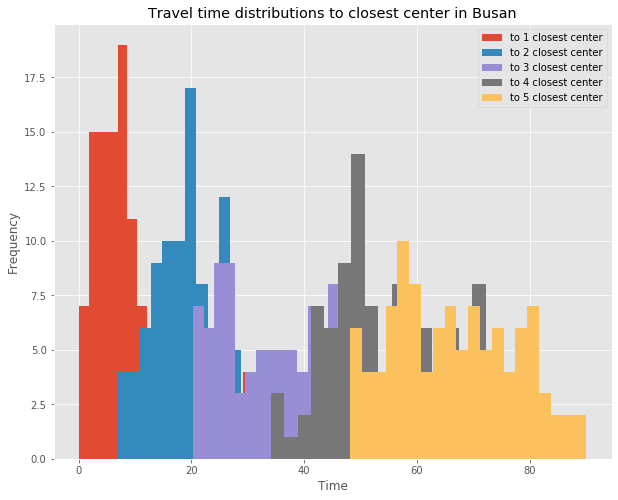

time: 858 ms


In [38]:
for center in range(1, len(centers)+1):
    times_dict['times_{}'.format(center)] = np.array(times_dict['times_{}'.format(center)])

fig, ax = plt.subplots(figsize=(10,8))
for center in range(1, len(centers)+1):
    plt.hist(times_dict['times_{}'.format(center)], bins=20, alpha=1, label='to {} closest center'.format(center))
plt.title('Travel time distributions to closest center in Busan')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [39]:
pickle_in = open("City_Accessibility.pickle","rb")
access_dict = pickle.load(pickle_in)
#access_dict = {}
access_dict['Busan'] = times_dict


pickle_out = open("City_Accessibility.pickle","wb")
pickle.dump(access_dict, pickle_out)
pickle_out.close()

access_dict

{'Paris': {'times_1': array([ 4.73219737,  4.40047807,  7.81577632,  7.07926754,  6.7129386 ,
          7.48037281, 10.85755263,  8.41227193, 14.20045614, 15.15502193,
         16.00692982, 15.80582895, 14.35941228, 14.10681579, 12.26687281,
         13.89203947, 14.31310965, 15.99389474, 16.77728947, 17.82112281,
         20.19769737, 20.40849561, 21.93033333, 22.03087719, 20.6584386 ,
         20.62538596, 19.53197368, 20.61141228, 21.70609211, 23.22407018,
         21.70395614, 23.12607456, 22.79396053, 23.95434211, 21.49400439,
         21.55605702, 22.35374123, 22.36948246, 22.44162719, 21.54410965,
         21.93589912, 21.86757456, 21.86757456, 21.41060088, 21.92571491,
         22.93862281, 23.57200877, 25.13889474, 24.49192982, 26.04400877,
         26.815     , 38.90660088, 38.56507018, 37.89241228, 36.57546491,
         29.87379386, 27.54254825, 25.54755702, 26.98263158, 25.76562281,
         25.03485526, 25.37799123, 25.69687719, 26.07382018, 23.81846491,
         24.034649

time: 1.39 s


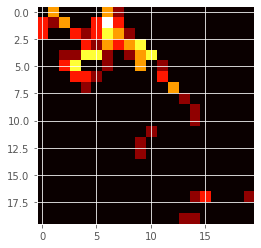

time: 190 ms


In [40]:
x = times_dict['times_{}'.format(1)]
y = times_dict['times_{}'.format(2)]
c_xy = np.histogram2d(x, y, 20)[0]
c_xx = np.histogram2d(x, x, 20)[0]
plt.imshow(c_xy, cmap='hot', interpolation='nearest')
plt.show()

In [41]:
from sklearn.metrics import mutual_info_score

def calc_MI(x, y, bins):
    c_xy = np.histogram2d(x, y, bins)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi

mi_list = []
for center in range(1, len(centers)+1):
    mi_list.append(times_dict['times_{}'.format(center)])

mis = []
for pair in combinations_with_replacement(mi_list, 2):
    MI = calc_MI(pair[0], pair[1], 20)
    print(MI)
    mis.append(MI)
mis = np.array(mis)
avg_mi = np.mean(mis)
print('average mutual information = ', avg_mi)

2.3310761692870727
1.1473820736155653
1.0931203430910983
1.0872435207300974
1.1850750998128938
2.6226223238417736
1.5771716859829021
1.670721175798232
1.722090066893577
2.93895645662355
1.8348177826467302
1.8425304287768838
2.833270298921412
2.1531197517929512
2.9122565068239568
average mutual information =  1.9300969123092464
time: 35 ms


In [42]:
pickle_in = open("Time_distribution_mutual_information.pickle","rb")
MI_dict = pickle.load(pickle_in)
#MI_dict = {}
MI_dict['Busan'] = avg_mi


pickle_out = open("Time_distribution_mutual_information.pickle","wb")
pickle.dump(MI_dict, pickle_out)
pickle_out.close()

MI_dict

{'Beijing': 1.629373608642793,
 'Florence': 2.0836399429599792,
 'Palermo': 1.8596013030930105,
 'Los_Angeles': 1.5602500680599918,
 'Moscow': 1.5631970905638934,
 'Porto': 1.6277816420571996,
 'Prague': 2.176480497902222,
 'Reykjavik': 1.3730161847793374,
 'Riga': 2.240374487910287,
 'Rome': 1.6095563575725969,
 'Seoul': 1.2910685865906735,
 'Siena': 2.7660068415344448,
 'Sydney': 1.2791891753795948,
 'Tallin': 2.3884073435187867,
 'Treviso': 2.631909071373147,
 'Valencia': 2.1872520197930965,
 'Venezia': 2.719891808939249,
 'Verona': 2.7080241467515376,
 'Vicenza': 2.6192607829416756,
 'Vienna': 1.4481542925032476,
 'Wellington': 2.1855226822614866,
 'Zurich': 2.462051055806955,
 'Aarhus': 2.2910468431831847,
 'Milan': 1.6107461389394335,
 'Busan': 1.9300969123092464,
 'Barcelona': 1.6449937230537024,
 'Bologna': 2.7317991260148045,
 'Bremen': 1.9957279038792954,
 'Brno': 2.4300669174144036,
 'Budapest': 2.219525897631017,
 'Dublin': 1.830502368836079,
 'Boston': 1.1451275682586615,


time: 6.99 ms
